# NIST FTIR Database Machine Learning
<b> RDKit Fingerprints from IR Spectra
    
Author: Kevin Patrick Kent

The aim of this notebook is to determine if using FTIR spectral data to predict the presence or absence of MACCS key
fingerprint bits is possible and useful.  Prior work has shown some success with using machine learning to predict
the presence or absence of functional groups (1,2).  In this work, prediction of the bits from MACCS keys was
chosen in order to see if alternate functional groups represented by the bits would be more amenable to FTIR
prediction.  Additionally, if successful, detection of a molecular fingerprint would allow for searching of larger
chemical databases for matches outside the library by generating MACCS keys fingerprints for the library and then searching
for the fingerprint of the unknown against the library of fingerprints.
    
    A) Scrape the FTIR data and molecular information for all molecules in the NIST database
        Used prior work (1,2) and an available API (3,4)
    B) Import and Clean the spectral data (same axes, units, etc.), select data for analysis
        Used prior work on jcamp import (5)
    C) Learn about and Generate MACCS keys fingerprints for all molecules of interest
    D) Perform Exploratory Data Analysis to Understand the Dataset
    E) Evaluate Several typical Classification Models for Initial Modeling (Split the Data into Train and Test)
    F) Generate Fitted Models from the Most Promising Classification Models and Predict the Test Set 
    
References:

1) https://pubs.acs.org/doi/pdf/10.1021/acs.analchem.1c00867

2) https://github.com/Ohio-State-Allen-Lab/FTIRMachineLearning

3) https://www.linkedin.com/pulse/unofficial-nist-webbook-api-how-get-thermochemistry-data-contreras/?trk=pulse-article_more-articles_related-content-card

4) https://github.com/oscarcontrerasnavas/nist-webbook-API

5) https://github.com/nzhagen/jcamp
      Installed this prior to running notebook: 1 ) python -m pip install git+https://github.com/nzhagen/jcamp

My work stored here: 

https://github.com/kevinpatrickkent/FTIRMachineLearning/

# In case you do not feel like scrolling to the bottom here are my conclusions:

# Conclusions and Future Directions

A unique correct match was obtained for 44% of the tested molecules, and a match in the top 10 within the test set of 1648 molecules was obtained for 76% of molecules in the test set. The approach summarized briefly here was to obtain

1) Obtain FTIR spectra, InChI, names, cas, and various other meta data from NIST
2) Clean the data to get spectra in the same state (gas), y-units (transmittince), and x-units (wavenumber)
3) Genearte MACCS keys from the InChI for each molecule with RDKit (166 bits - some removed in cleaning)
4) Normalize the the transmittance spectra with Min Max normalization and reduce dimensionality with PCA (sklearn)
5) Initial modeling with K-Nearest Neighbors, Suppor Vector Classifier, Logisitic Regression, Decision Tree, Random Forest, Adaboost, and Naive-Bayes scored with Jaccard/Tanimoto Index
6) Modeled expected molecular Jaccard Index expected from obtaining particular Jaccard Index Values for MACCS Keys bits
7) Optimized the two most promising models (KNN and SVC) with a scoring metric of getting as many as possible bit Jaccard index values above 0.8 as possible.
8) Chose SVC to move forward (optimized C value of 3) --> Tested different Jaccard value index cutoffs for removing MACCS keys bits from the analysis (tested this on the final test set).
9) Selected a cutoff of 0.3 based on the trade-off between obtaining a higher Jaccard Index and maintaining bits to keep molecules unique from one another.
10) Generated the final SVC model.
Going back through on this post analysis, there is a clear mismatch between the obtained molecular jaccard index (greater thatn 50% above 0.5) and the cutoff for the bits (Jaccard Index of 0.3). If you look back at 6 where I modeled the expected molecular Jaccard index - I did not take into account the distribution of Jaccard index. I simply modeled the Jaccard index as a monolithic value. Perhaps the distribution of Jaccard index for the features would aid future modeling of expected molecular Jaccard index. In fact, some additional work in this area could aid in determining how useful adding more bits would be to this process.

In the future it would be interested to generate these fingerprints for a larger database of values (PubChem for instance) and see how well the fingerprints generated from these spectra allow for identification of a molecule fro PubChem. My guess would be that the lower jaccard index matches would not fare well as the database size increases.

For the preprocessing of the data with PCA, I didn't put any time or analysis into evaluation or optimization of that step. Removing the processing step, using PLS, and peak fitting could all be tried in order to improve the capture of spectral features.

I selected the MACCS keys - but there are many fingerprints available for digitizing chemical structure. I intially started with RDKit fingerprints, but it was not clear to me from the documentation that each bit would come from a unique feature. So, I dropped the RDKit fingerprint in favor of MACCS keys. However, perhaps other fingerprints could be used to generate several potential FTIR fragments to be used in this type analysis. I think this area may lead to the most improvement in future analysis.

The best next step would likely be to expand the matching to a larger database and get a benchmark of where this approach stands right now before making additional improvements. For now, I will be moving on to other projects for a while and hopefully come back at some point to visit this project at a later date.

# Import Statements

In [ ]:
# Kevin Patrick Kent
# updated from original code at https://github.com/Ohio-State-Allen-Lab/FTIRMachineLearning

import os
import time
import requests, urllib
import argparse
import logging
import pandas as pd 
import jcamp #Planning to use this later to import all of the .jdx files
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from scipy import interpolate
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from rdkit import Chem, RDLogger # if needed run pip install rdkit
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import Draw
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from itertools import compress
#from model.utils import set_logger
# Was not able to run this on the first runthrough.  Will try this again later after investigation but continuing for now.

In [ ]:
nist_url = "https://webbook.nist.gov/cgi/cbook.cgi"

#  A) Scrape the FTIR data and molecular information

Used webbook API from here: https://github.com/oscarcontrerasnavas/nist-webbook-API

Used the function from here: https://github.com/Ohio-State-Allen-Lab/FTIRMachineLearning

Used the function from here: https://github.com/Ohio-State-Allen-Lab/FTIRMachineLearning

This code block uses the API referenced above to pull all molecules on NIST webbook and store them in a dataframe.

In [ ]:
# I chose 40000 here because there are currently 37495 molecules on webbook

# Perform an inital query to see how many items are present in the database
url = 'https://nist-api.fly.dev/substances?page=1&per_page=10'
response = requests.get(url)
json = response.json()
tot = json['totalItems'] #Get the total number of items and store it for the next request

url = 'https://nist-api.fly.dev/substances?page=1&per_page=' + str(tot+1000)
response = requests.get(url) 
json = response.json()
df = pd.DataFrame(json['items'])
df.head()

# Here I'm making the cas the index for easy referencing

df.set_index('cas', inplace = True)

This function is pulled from work to support the paper referenced above on machine learning for functional group ID.
FTIR spectra are pulled from the NIST database by their CAS number.

Future: Consider making a fork of the API above to pull the spectra

In [ ]:
def scrape_data(cas_ls, params, data_dir):
	'''Collect data from NIST database and store them in jdx format.
    Args:
        cas_ls: (list) CAS ids to download data for
		params: (dict) queries to be added to url
		data_dir: (string) path to store the data
    Returns:
        None
    '''	
    
    #Create directory for the relevant spetra 
	spectra_path = os.path.join(data_dir, params['Type'].lower(), '')
	if not os.path.exists(spectra_path):
		os.makedirs(spectra_path)

	num_created = 0
	for cas_id in cas_ls:
		params['JCAMP'] = 'C' + cas_id
		response = requests.get(nist_url, params=params)

		if response.text == '##TITLE=Spectrum not found.\n##END=\n':
			continue
		num_created+=1
		logging.info('Creating {} spectra for id: {}. Total spectra created {}'.format(params['Type'].lower(), cas_id, num_created))
		with open(spectra_path +cas_id +'.jdx', 'wb') as data:
			data.write(response.content)

In [ ]:
# Do not run this each time as it takes several hours to download these spectra

#Create data directory to store logs and spectra
data_dir = './data'
if not os.path.exists(data_dir):
	os.makedirs(data_dir)

logging.info('Scrape IR spectra')
# Taking this out because I'm running from the command line
#if args.scrap_IR:
cas_ids = df.index
params={'JCAMP': '', 'Type': 'IR', 'Index': 0}	
scrape_data(cas_ids, params, data_dir)

In [ ]:
def scrape_inchi(cas_ls, params, data_dir):
	'''Collect Inchi keys from NIST database and store them in txt format.
    Args:
        cas_ls: (list) CAS ids to download data for
		params: (dict) queries to be added to url
		data_dir: (string) path to store the data
    Returns:
        None
    '''	

	#Create file path for storing inchi keys
	inchi_path = os.path.join(data_dir, 'inchi.txt')
	num_created = 0
	with open(inchi_path,'a') as file:
		content = '{}\t{}\n'.format('cas_id', 'inchi')
		file.write(content)

		for cas_id in cas_ls:
			params['GetInChI'] = 'C' + cas_id
			response = requests.get(nist_url, params=params)

			num_created+=1
			logging.info('Creating InChi key for id: {}. Total keys created {}'.format(cas_id, num_created))
			content = '{}\t{}\n'.format(cas_id,response.content.decode("utf-8"))
			file.write(content)

In [ ]:
# Scrape InCHi keys from NIST
# Note that I manually modified the inchi.txt file to add the InCHi name
# for Diisooctyl phthalate (Cas: 27554-26-3)
# In the future should update to pull from PubChem automatically

#Create data directory to store logs and spectra
data_dir = './data'
if not os.path.exists(data_dir):
	os.makedirs(data_dir)
cas_ids = df.loc[].index

logging.info('Scrape InChi keys')
params={}
scrape_inchi(cas_ids, params, data_dir)

In [ ]:
# Now attach all of the InCHi data to the meta data df

inchi = pd.read_csv('./data/inchi.txt', sep = '\t')
inchi.set_index('cas_id', inplace = True)

df = df.join(inchi)

df.head()

# Note that several of the NaNs come from me scraping the inchi
# for only the compounds where I have spectra.

# Pull in All of the Data from the JCAMP files with jcamp

https://github.com/nzhagen/jcamp 

In [ ]:
# Making sure I'm able to get the data with the jcamp module

path = 'C:\\Users\\kevin\\Documents\\Python Scripts\\data\\ir\\'
cas = 99980286
data = jcamp.jcamp_readfile(path + str(cas) + '.jdx')

plt.figure()
plt.plot(data['x'], data['y'], color = 'black')
plt.title(data['title'])
plt.xlabel(data['xunits'])
plt.ylabel(data['yunits'])

In [ ]:
data

In [ ]:
## Here I'm just going through my strategy for one jcamp before looping through all of them
# Setting the dict that I'll be adding all of the spectra to

spec_dict = {'cas':[], 'x':[], 'y':[]}
spec_dict['cas'].append(str(cas))
spec_dict['x'].append(data['x'])
spec_dict['y'].append(data['y'])

print(spec_dict)

# Then I will drop the spectra from the jcamp dict

del data['x']
del data['y']

meta_dict = {'cas':[str(cas)]}
for key in data:
    meta_dict[key] = [data[key]]

print(meta_dict)



In [ ]:
# This is another to not run everytime.

path = 'C:\\Users\\kevin\\Documents\\Python Scripts\\data\\ir\\'
spec_dict = {'cas':[], 'x':[], 'y':[]}
meta_keys = ['cas', 'title', 'jcamp-dx', 'data type', 'origin', 'owner', 'cas registry no', 'molform', '$nist source', 'state', 'xunits', 'yunits', 'xfactor', 'yfactor', 'deltax', 'firstx', 'lastx', 'firsty', 'maxx', 'minx', 'maxy', 'miny', 'npoints', 'xydata', 'end', 'filename', 'date', '$nist doc file', '$nist psd file', 'spectrometer/data system', 'aperture', 'external diffuse reflectance accessory', 'beamsplitter', 'detector (dia. det. port in sphere)', 'sphere diameter', 'acquisition mode', 'scanner speed', 'coadded scans', 'phase resolution', 'phase correction', 'zerofilling', 'spectral range', 'resolution', 'spectral resolution', 'wavenumber accuracy', 'apodization function', 'low pass filter', 'switch gain on', 'xlabel', 'ylabel', 'class', 'source reference', '$nist image', 'sampling procedure', 'data processing', 'instrument parameters', 'names', 'path length', 'bp', 'instrument resolution', 'ir source', 'detector', 'interferogram zerofill', 'spectral interval after zerofilling', 'apodization', 'folding limits', 'number of interferograms averaged per single channel spectrum', 'mp', 'cas name', 'sample description', 'temperature', '$spectra version', '$uncertainty in y', 'pressure', '$nist id']
meta_dict = {}
for key in meta_keys:
    meta_dict[key] = []
IRSpecCount = 0
NoIRSpecCount = 0

for cas in df.index:
    try:
        data = jcamp.jcamp_readfile(path + cas + '.jdx')
        IRSpecCount += 1
    except:
        NoIRSpecCount += 1
        continue
    
    spec_dict['cas'].append(cas)
    spec_dict['x'].append(data['x'])
    
    spec_dict['y'].append(data['y'])
    del data['x']
    del data['y']
    
    for key in meta_dict:
        if key in data:
            meta_dict[key].append(data[key])
        elif key == 'cas':
            meta_dict[key].append(cas)
        else:
            meta_dict[key].append(np.NaN)

print('This many compounds have IR Spectra:', IRSpecCount)
print('This many compounds have do not have IR Spectra:', NoIRSpecCount)

In [ ]:
# Not running this one because I didn't load this time.

meta_df = pd.DataFrame.from_dict(meta_dict)
meta_df.set_index('cas', inplace = True)

meta_df.head()

In [ ]:
#Not running this one because I didn't load this time.
#Just outputting the data so that I can avoid loading all of this again.

df.to_csv('df.csv')

meta_df.to_csv('meta_df.csv')

pickle.dump( spec_dict, open( "spec_dict.p", "wb" ) )

# Save Point! Start Here to Go Through the Analysis from the above Downloaded Files.

In [1]:
# Kevin Patrick Kent
# updated from original code at https://github.com/Ohio-State-Allen-Lab/FTIRMachineLearning

import os
import time
import requests, urllib
import argparse
import logging
import pandas as pd 
import jcamp #Planning to use this later to import all of the .jdx files
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from scipy import interpolate
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from rdkit import Chem, RDLogger # if needed run pip install rdkit
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import Draw
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from itertools import compress
#from model.utils import set_logger
# Was not able to run this on the first runthrough.  Will try this again later after investigation but continuing for now.

In [2]:
# Need to add in a load function right here so that I can skip the part above.
# Alright there we go picking up from here.  Will need to come back and make this less clunky.
# Maybe I'll just have a whole section of 'run this once' type of code

df = pd.read_csv('df.csv')
df.loc[:,'cas'] = df.loc[:,'cas'].astype(str) #Had to set this line because pandas made cas an int64
df.set_index('cas', inplace = True)

meta_df = pd.read_csv('meta_df.csv')
meta_df.loc[:,'cas'] = meta_df.loc[:,'cas'].astype(str) #Had to set this line because pandas made cas an int64
meta_df.set_index('cas', inplace = True)

spec_dict = pd.read_pickle('spec_dict.p')

C:\Users\kevin\AppData\Local\Temp\ipykernel_15940\1056144230.py:9: DtypeWarning: Columns (27,28,30,31,32,33,34,35,36,39,41,42,43,44,45,46,47,59,60,61,62,63,64,65,66,69,70,72,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_df = pd.read_csv('meta_df.csv')


In [3]:
# Now merging the spectral data into the original NIST Webbook Database

df = df.join(meta_df)

df.head()

name      formula  molecular_weight  \
cas                                                                           
74828                                methane          CH4           16.0425   
58855                                 biotin  C10H16N2O3S          244.3110   
625081    butanoic acid, 3-hydroxy-3-methyl-      C5H10O3          118.1311   
1314916                       lead telluride         PbTe          334.8000   
16853740      ditungsten zirconium octaoxide       O8W2Zr          586.9000   

                                                      image  \
cas                                                           
74828     https://webbook.nist.gov/cgi/cbook.cgi?Struct=...   
58855     https://webbook.nist.gov/cgi/cbook.cgi?Struct=...   
625081    https://webbook.nist.gov/cgi/cbook.cgi?Struct=...   
1314916   https://webbook.nist.gov/cgi/cbook.cgi?Struct=...   
16853740  https://webbook.nist.gov/cgi/cbook.cgi?Struct=...   

                                                      inchi    title jcamp-dx  \
cas                                                                             
74828                                     InChI=1S/CH4/h1H4  Methane     4.24   
58855     InChI=1S/C10H16N2O3S/c13-8(14)4-2-1-3-7-9-6(5-...   Biotin     4.24   
625081                                                  NaN      NaN      NaN   
1314916                                                 NaN      NaN      NaN   
16853740                                                NaN      NaN      NaN   

                  data type  \
cas                           
74828     INFRARED SPECTRUM   
58855     INFRARED SPECTRUM   
625081                  NaN   
1314916                 NaN   
16853740                NaN   

                                                     origin  \
cas                                                           
74828           Sadtler Research Labs Under US-EPA Contract   
58855     Pacific Northwest National Laboratory Under IA...   
625081                                                  NaN   
1314916                                                 NaN   
16853740                                                NaN   

                                                      owner  ...  \
cas                                                          ...   
74828     NIST Standard Reference Data Program\nCollecti...  ...   
58855                                         Public domain  ...   
625081                                                  NaN  ...   
1314916                                                 NaN  ...   
16853740                                                NaN  ...   

         folding limits  \
cas                       
74828               NaN   
58855               NaN   
625081              NaN   
1314916             NaN   
16853740            NaN   

         number of interferograms averaged per single channel spectrum   mp  \
cas                                                                           
74828                                                   NaN             NaN   
58855                                                   NaN             NaN   
625081                                                  NaN             NaN   
1314916                                                 NaN             NaN   
16853740                                                NaN             NaN   

         cas name sample description temperature  $spectra version  \
cas                                                                  
74828         NaN                NaN         NaN               NaN   
58855         NaN                NaN         NaN               NaN   
625081        NaN                NaN         NaN               NaN   
1314916       NaN                NaN         NaN               NaN   
16853740      NaN                NaN         NaN               NaN   

          $uncertainty in y  pressure  $nist id  
cas                                              
7482

In [4]:
# Dropping the rows without any IR spectral data

print('Here is how many rows will be dropped (consistent with above):', df['title'].isna().sum())

df = df.drop(labels = df.loc[df['title'].isna(),:].index.tolist())

Here is how many rows will be dropped (consistent with above): 23659


In [5]:
# Note that I found one of the compounds with an IR spectra that did not have an InCHi
# I pulled the InCHi from pubchem: https://pubchem.ncbi.nlm.nih.gov/compound/Diisooctyl-phthalate

#df.loc[df.inchi.isna(),:]

# Remedied this but leaving this here for documentation
# Eventually I will need to go back and pull missing InCHi names from
# somewhere else like PubChem

# Data Exploration and Cleaning

In [6]:
df.columns

Index(['name', 'formula', 'molecular_weight', 'image', 'inchi', 'title',
       'jcamp-dx', 'data type', 'origin', 'owner', 'cas registry no',
       'molform', '$nist source', 'state', 'xunits', 'yunits', 'xfactor',
       'yfactor', 'deltax', 'firstx', 'lastx', 'firsty', 'maxx', 'minx',
       'maxy', 'miny', 'npoints', 'xydata', 'end', 'filename', 'date',
       '$nist doc file', '$nist psd file', 'spectrometer/data system',
       'aperture', 'external diffuse reflectance accessory', 'beamsplitter',
       'detector (dia. det. port in sphere)', 'sphere diameter',
       'acquisition mode', 'scanner speed', 'coadded scans',
       'phase resolution', 'phase correction', 'zerofilling', 'spectral range',
       'resolution', 'spectral resolution', 'wavenumber accuracy',
       'apodization function', 'low pass filter', 'switch gain on', 'xlabel',
       'ylabel', 'class', 'source reference', '$nist image',
       'sampling procedure', 'data processing', 'instrument parameters',
      

In [7]:
# Here I'm going to need to decide what to work on for the project.  Start with gas spectra likely as the largest sample size

#set this to count it as False if the state was empty - may come back to this later
gas = df.state.str.lower().str.contains('gas', na = False)

print(df.state.value_counts()[df.state.value_counts()>8])


gas                                                            8183
SOLID (MINERAL OIL MULL)                                        417
LIQUID                                                          413
LIQUID (NEAT)                                                   337
SOLID (KBr PELLET)                                              300
                                                               ... 
SOLID (1 mg / 200 mg KBr DISC) VS KBr                             9
liquid                                                            9
SOLID (KCl DISC) VS KCl                                           9
SOLUTION (10% CCl4 FOR 2.5-7.5, 10% CS2 FOR 7.5-16 MICRONS)       9
SOLUTION (10% CCl4 FOR 2.5-7.5, 10% CS2 FOR 7.5-15 MICRON)        9
Name: state, Length: 67, dtype: int64


In [8]:
# Here is something interesting.  There are 809 unlabelled states. Will have to come back to this later.
# This bumped up to 810... Hmmm some other problem in the load

df.state.isna().sum()

810

In [9]:
# What are all of our states that contain gas?

df.loc[gas,:].state.value_counts()

gas                                                                     8183
GAS (100 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                          9
GAS (50 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                           8
GAS                                                                        6
GAS (80 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                           2
GAS (100 mmHg DILUTED TO A TOTAL PRESSURE OF 600 mmHg WITH N2)             2
GAS (200 mmHg DILUTED TO A TOTAL PRESSURE OF 600 mmHg WITH N2)             2
GAS (10 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                           2
GAS (600 mmHg DILUTED TO A TOTAL PRESSURE OF 600 mmHg WITH N2)             2
GAS (60 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                           2
GAS (40 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                           1
GAS (150 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                          1
GAS (106 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                          1

In [10]:
# Defining a new column called clean_state.  I'm going to relabel all of the gas labels above as 'gas'

df['clean_state'] = np.NaN
df.loc[gas,'clean_state'] = 'gas'

In [11]:
# Now check to make sure I did that right
# Will have to do something similar with liquid, solid and solution

df.loc[gas,:].clean_state.value_counts()

gas    8239
Name: clean_state, dtype: int64

In [12]:
# What are the units for y?  All the same? Close one is in extinction coefficient units but if I normalize that won't matter
# With the transmittance spectra I need to convert to absorbance

df.loc[gas,:].yunits.value_counts()

ABSORBANCE                       8183
TRANSMITTANCE                      55
(micromol/mol)-1m-1 (base 10)       1
Name: yunits, dtype: int64

In [13]:
df.loc[gas,'xydata'].value_counts()

(X++(Y..Y))    8239
Name: xydata, dtype: int64

In [14]:
# What about x?  I need to convert micrometers to wavenumbers.  The cm-1 is the same as 1/cm (wavenumbers)

df.loc[gas,:].xunits.value_counts()

1/CM           8230
MICROMETERS       8
cm-1              1
Name: xunits, dtype: int64

In [15]:
# Just quickly fixing the cm-1

quick_cm = (df.loc[gas,:].xunits == 'cm-1').tolist()

df.loc['354336','xunits'] = '1/CM'

df.loc[gas,:].loc[quick_cm,'xunits']


cas
354336    1/CM
Name: xunits, dtype: object

In [16]:
# Check to see if it's fixed.

df.loc[gas,:].xunits.value_counts()

1/CM           8231
MICROMETERS       8
Name: xunits, dtype: int64

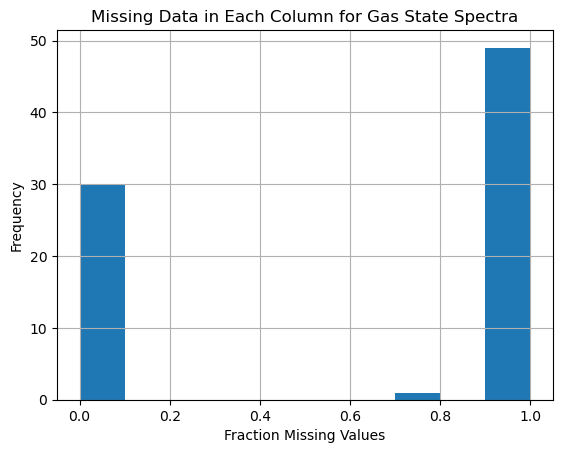

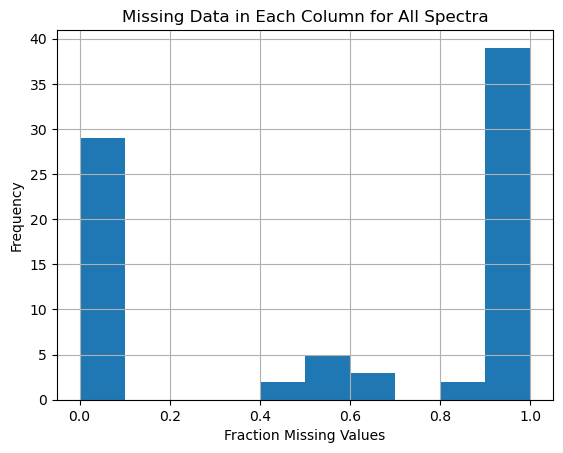

In [17]:
# How many NaNs?  Need to look into this a bit further - probably several columns I can just drop
# Focussing on gas spectra right now to get a good intermediate product.  However, there are columns
# that appear to be more important for other states (solid, solution, liquid).  Will need to investigate
# other states prior to dropping columns.

ax = (df.loc[gas,:].isna().sum()/df.loc[gas,:].shape[0]).hist()
ax.set_xlabel('Fraction Missing Values')
ax.set_ylabel('Frequency')
ax.set_title('Missing Data in Each Column for Gas State Spectra')
plt.show()

ax = (df.isna().sum()/df.shape[0]).hist()
ax.set_xlabel('Fraction Missing Values')
ax.set_ylabel('Frequency')
ax.set_title('Missing Data in Each Column for All Spectra')
plt.show()

In [18]:
# Getting a quick look at the columns so I can choose which ones to convert from wavelenght to wavenumber

df.columns

Index(['name', 'formula', 'molecular_weight', 'image', 'inchi', 'title',
       'jcamp-dx', 'data type', 'origin', 'owner', 'cas registry no',
       'molform', '$nist source', 'state', 'xunits', 'yunits', 'xfactor',
       'yfactor', 'deltax', 'firstx', 'lastx', 'firsty', 'maxx', 'minx',
       'maxy', 'miny', 'npoints', 'xydata', 'end', 'filename', 'date',
       '$nist doc file', '$nist psd file', 'spectrometer/data system',
       'aperture', 'external diffuse reflectance accessory', 'beamsplitter',
       'detector (dia. det. port in sphere)', 'sphere diameter',
       'acquisition mode', 'scanner speed', 'coadded scans',
       'phase resolution', 'phase correction', 'zerofilling', 'spectral range',
       'resolution', 'spectral resolution', 'wavenumber accuracy',
       'apodization function', 'low pass filter', 'switch gain on', 'xlabel',
       'ylabel', 'class', 'source reference', '$nist image',
       'sampling procedure', 'data processing', 'instrument parameters',
      

In [19]:
# Next cleaning task is clear we need to convert from micrometers to 1/cm
# Conversion is wavenumber (1/CM) = 10^4 / wavelength (micrometers)

def wavenumber(wavelength):
    ''' Simple function to convert from wavelength in micrometers to wavenumber is inverse centimeter.'''
    return (10**4)/wavelength

In [20]:
# In order to make this conversion we need to do the following.
# 1) Convert the meta data that will be used in wavenumbers (several items).
# 2) Convert the x-values for the spectra to wavenumbers.
# 3) Setup wavelength flag so that I can know which rows were changed

df.loc[:,'orig_xunits'] = np.NaN # Set up a flag so that I know when I've made the conversion
# I added the above beause the deltax is only meaningful in the original units - there is not an
# easy conversion because it depends on the wavelength.  I'm going to keep the deltax
# but have a flag in the data set to show which were converted.

def convert(cas):
    ''' Collecting all the conversion tasks for wavelength to wavenumber into a function.'''
    meta_mods = ['firstx', 'lastx', 'maxx', 'minx']
    for key in meta_mods:
        df.loc[cas,key] = wavenumber(df.loc[cas,key])
    
    # Find the location of the spectrum and convert x to wavenumber
    ind = spec_dict['cas'].index(cas)
    spec_dict['x'][ind] = wavenumber(spec_dict['x'][ind])
    
    # Lastly change the unit to the new unit
    df.loc[cas,'orig_xunits'] = df.loc[cas,'xunits']
    df.loc[cas,'xunits'] = '1/CM'
    
    return
    

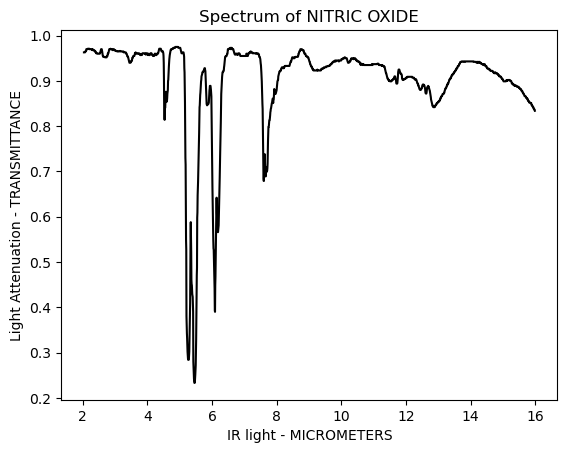

Text(0.5, 1.0, 'Check Before x-axis Conversion')

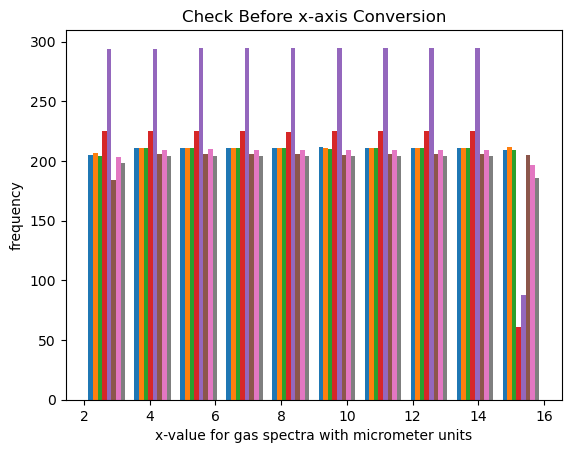

In [21]:
# Before I run this function I want to have some visualization of the x-values from spec_dict
# to make sure that I've done what I expect to do

x_check = []
microm = df.xunits.str.lower().str.contains('micrometer', na = False)

i = 0
for cas in df.loc[gas & microm,:].index:
    ind = spec_dict['cas'].index(cas)
    if i == 0:
        plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
        plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
        plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
        plt.title('Spectrum of ' + df.loc[cas,'title'])
        plt.show()
    x_check.append(spec_dict['x'][ind].tolist())
    i += 1

plt.hist(x_check)

plt.xlabel('x-value for gas spectra with micrometer units')
plt.ylabel('frequency')
  
plt.title('Check Before x-axis Conversion')
    

In [22]:
# Run the function to convert to wavenumber

for cas in df.loc[gas & microm, :].index:
    convert(cas)

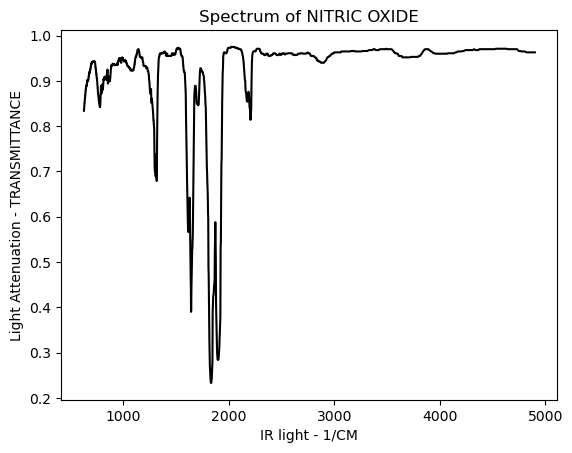

Text(0.5, 1.0, 'Check Before x-axis Conversion')

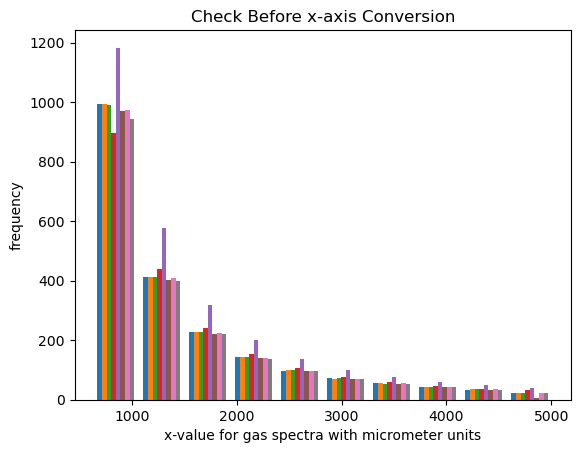

In [23]:
# Now after let's check and see how things went

x_check = []

i = 0
for cas in df.loc[gas & microm,:].index:
    ind = spec_dict['cas'].index(cas)
    if i == 0:
        plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
        plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
        plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
        plt.title('Spectrum of ' + df.loc[cas,'title'])
        plt.show()
    x_check.append(spec_dict['x'][ind].tolist())
    i += 1

plt.hist(x_check)

plt.xlabel('x-value for gas spectra with micrometer units')
plt.ylabel('frequency')
  
plt.title('Check Before x-axis Conversion')

In [24]:
# Check to see if it's fixed - Looks good only one unit present

df.loc[gas,:].xunits.value_counts()

1/CM    8239
Name: xunits, dtype: int64

In [25]:
# Check to see if my flag tells me where the inaccurate deltax are located - looks good

df.loc[gas,:].orig_xunits.value_counts()

MICROMETERS    8
Name: orig_xunits, dtype: int64

That went as expected now move on to checking on other items that may need cleaned up

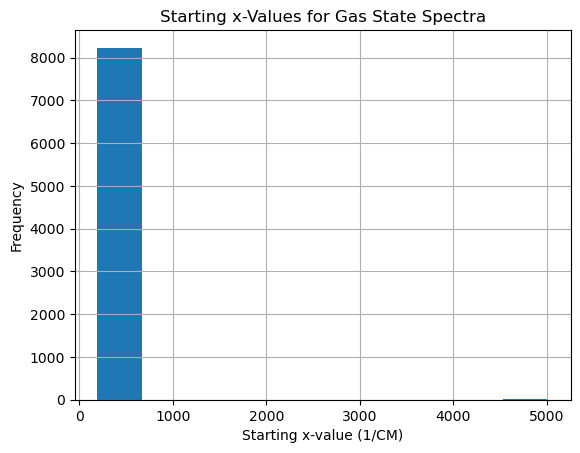

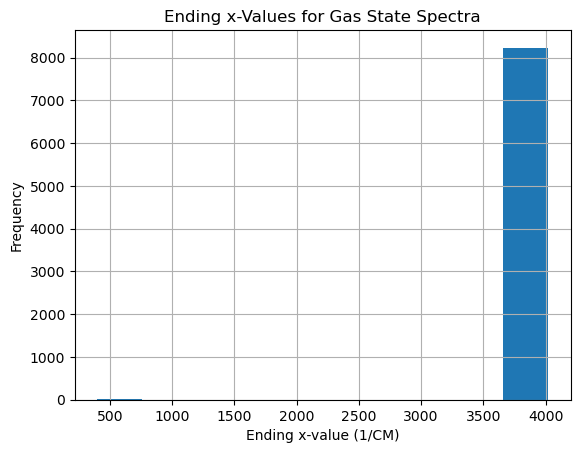

In [26]:
# Looking at histograms of the starting and ending wavenumbers for the data it's
# clear that we've got some spectra in descending order.  Need to fix that.

ax = df.loc[gas,'firstx'].hist()
ax.set_xlabel('Starting x-value (1/CM)')
ax.set_ylabel('Frequency')
ax.set_title('Starting x-Values for Gas State Spectra')
plt.show()

ax = df.loc[gas,'lastx'].hist()
ax.set_xlabel('Ending x-value (1/CM)')
ax.set_ylabel('Frequency')
ax.set_title('Ending x-Values for Gas State Spectra')
plt.show()



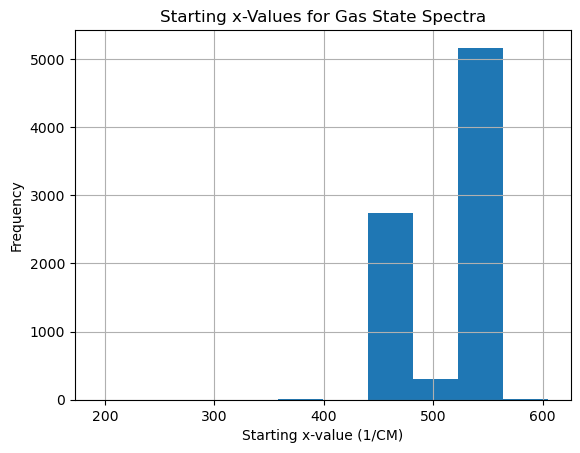

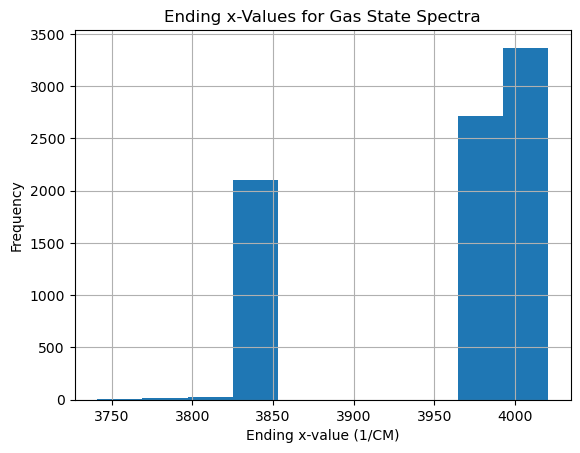

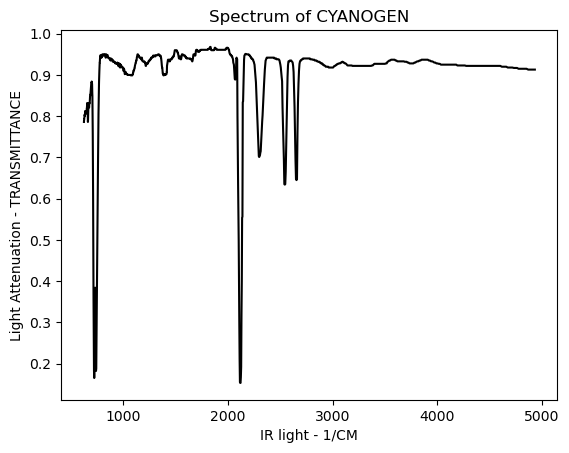

The first x-value in spec_dict for cas: 460195 is 4933.399111988159


In [27]:
# Going to do a quick investigation before I fix this.

# selecting values where the starting x is above the mid point
rev_spec = df.loc[gas,'firstx'] > 2000

# Now looking at the starting point without the reverse spectra
# OK good we can see that the distribution is narrow around
# typical starting and ending wavenumbers for IR spectra
ax = df.loc[(gas & ~rev_spec),'firstx'].hist()
ax.set_xlabel('Starting x-value (1/CM)')
ax.set_ylabel('Frequency')
ax.set_title('Starting x-Values for Gas State Spectra')
plt.show()

ax = df.loc[(gas & ~rev_spec),'lastx'].hist()
ax.set_xlabel('Ending x-value (1/CM)')
ax.set_ylabel('Frequency')
ax.set_title('Ending x-Values for Gas State Spectra')
plt.show()

# Just plotting another quick spectrum to show the spectra before transformation
# the transformation we're doing (reversing x) should have no impact on the
# spectrum.
cas = df.loc[(gas & rev_spec),:].index[1] #chose 1 so I wouldn't get nitric oxide again
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])

In [28]:
# Now go through and reverse the x and y axis

for cas in df.loc[(gas & rev_spec),:].index:
    ind = spec_dict['cas'].index(cas)
    sortind = spec_dict['x'][ind].argsort()
    spec_dict['x'][ind] = spec_dict['x'][ind][sortind]
    spec_dict['y'][ind] = spec_dict['y'][ind][sortind]
    tmp = df.loc[cas,'firstx']
    df.loc[cas,'firstx'] = df.loc[cas,'lastx']
    df.loc[cas,'lastx'] = tmp
    

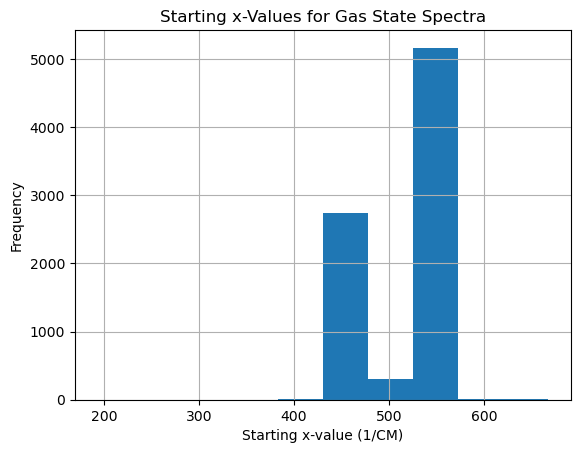

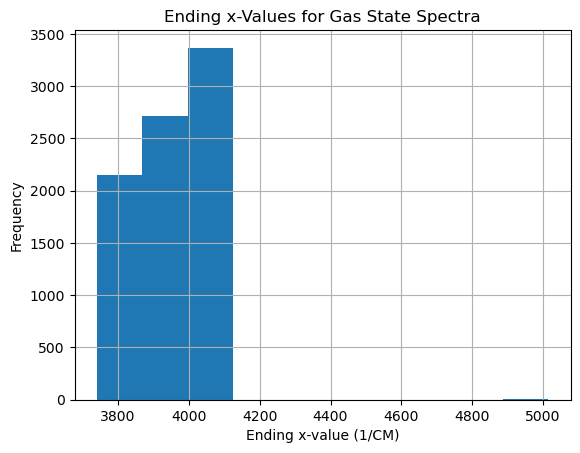

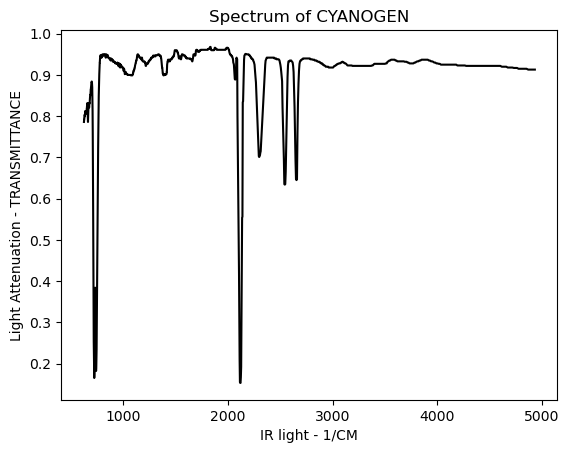

The first x-value in spec_dict for cas: 460195 is 625.0078125976574


In [29]:
# Now I'm looking at the two histograms and the spectrum again to make sure everything looks as expected

ax = df.loc[gas,'firstx'].hist()
ax.set_xlabel('Starting x-value (1/CM)')
ax.set_ylabel('Frequency')
ax.set_title('Starting x-Values for Gas State Spectra')
plt.show()

ax = df.loc[gas,'lastx'].hist()
ax.set_xlabel('Ending x-value (1/CM)')
ax.set_ylabel('Frequency')
ax.set_title('Ending x-Values for Gas State Spectra')
plt.show()

# Plot spectrum again afterwards (shouls see no difference)

cas = df.loc[(gas & rev_spec),:].index[1] #chose 1 so I wouldn't get nitric oxide again
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])

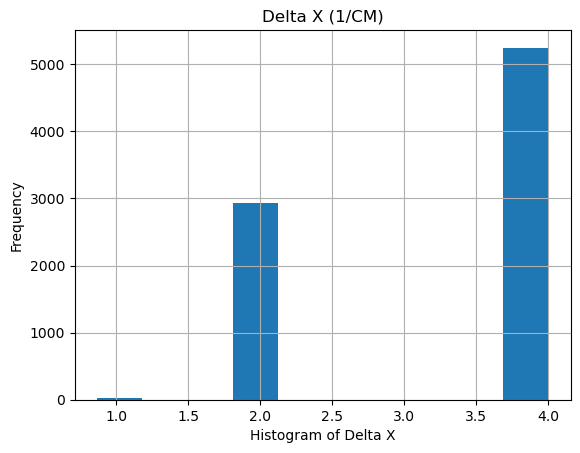

In [30]:
# Now I need to find a common axis to put all of these spectra on for analysis.
# End goal is to get all of these into a dataframe for analysis, so I need the same x-values for all of them

# Note that I'm purposefully removing the spectra in wavelength because the deltax will be off
ax = df.loc[gas & ~microm,'deltax'].hist()
ax.set_xlabel('Histogram of Delta X')
ax.set_ylabel('Frequency')
ax.set_title('Delta X (1/CM)')
plt.show()

In [31]:
# OK so four is the most common but I don't want to lose the resolution for all of those 2s... Will
# go with 2 and interpolate for 4.

two = (df.loc[gas,'deltax'] > 1.5) & (df.loc[gas,'deltax'] < 2.5)

# Now I'm looking at the two histograms again with only the deltax of 4 cm-1 spectra

print(df.loc[gas & two,'firstx'].value_counts())

print(df.loc[gas & two,'lastx'].value_counts())

549.8    2452
549.9     483
Name: firstx, dtype: int64
4000.7    2220
3999.5     483
4000.8     223
3999.2       9
Name: lastx, dtype: int64


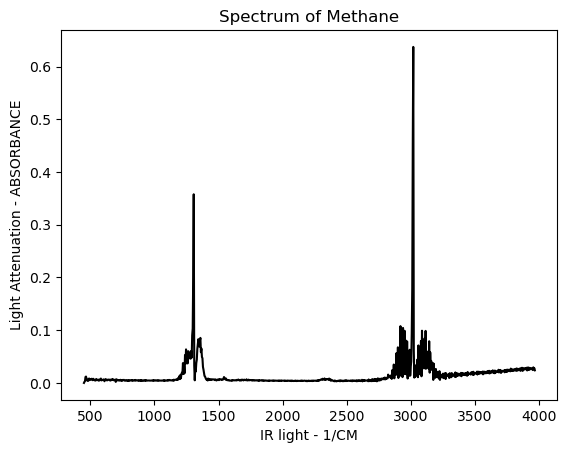

The first x-value in spec_dict for cas: 74828 is 450.0
The last x-value in spec_dict for cas: 74828 is 3966.0


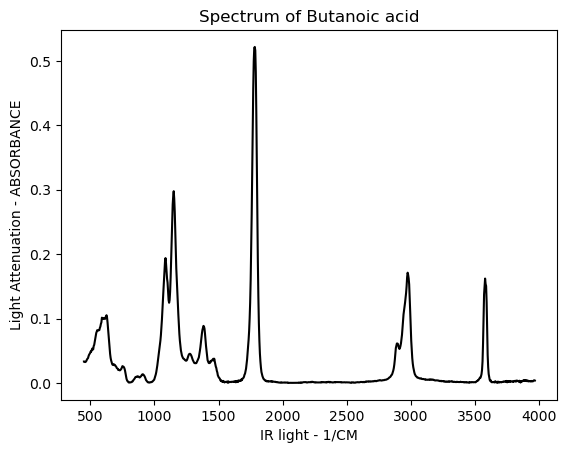

The first x-value in spec_dict for cas: 107926 is 450.0
The last x-value in spec_dict for cas: 107926 is 3966.0


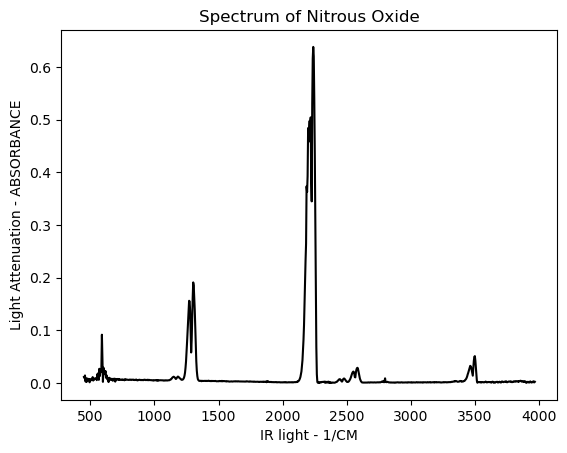

The first x-value in spec_dict for cas: 10024972 is 450.0
The last x-value in spec_dict for cas: 10024972 is 3966.0


In [32]:
# Know from previous method of analysis that deltax of four has some wider range
# spectra.  Need to pull these in order to see how the transformation impacts
# them and how much information we're losing.
# Very briefly let's get a look at what we'll be losing before a transformation

wide_range = (df.loc[gas,'deltax'] == 4) & ((df.loc[gas,'firstx'] < 550) | (df.loc[gas,'lastx'] > 3846))
sum(wide_range)

cas = df.loc[gas & wide_range, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

cas = df.loc[gas & wide_range, :].index[1] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

cas = df.loc[gas & wide_range, :].index[2] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

In [33]:
# What is the value of delta x close to two?

df.loc[gas,'deltax'].value_counts()

4.000000    4818
1.928980    2220
1.929340     483
3.857960     429
1.929000     223
1.929180       9
1.000000       4
0.937503       2
0.939706       1
1.171875       1
0.870107       1
1.006030       1
0.878220       1
0.936331       1
0.964500       1
0.879767       1
0.888327       1
0.936771       1
0.937502       1
0.876682       1
0.866873       1
0.006700       1
0.939705       1
0.938676       1
1.045753       1
1.305486       1
0.006633       1
0.935748       1
1.045755       1
0.006635       1
0.006645       1
0.935163       1
0.949969       1
0.936915       1
0.934581       1
0.006231       1
0.927358       1
0.004749       1
0.006806       1
1.358703       1
0.006863       1
Name: deltax, dtype: int64

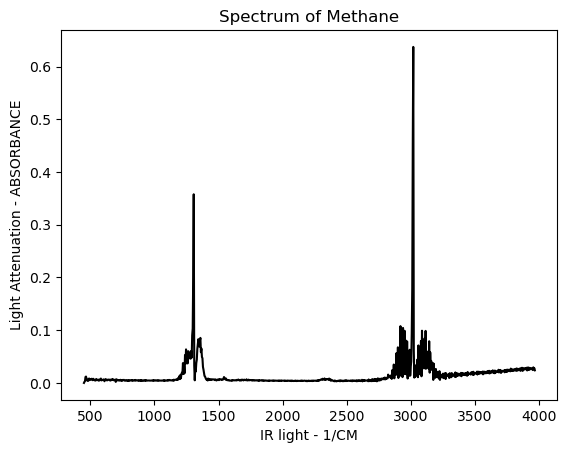

The first x-value in spec_dict for cas: 74828 is 450.0
The last x-value in spec_dict for cas: 74828 is 3966.0


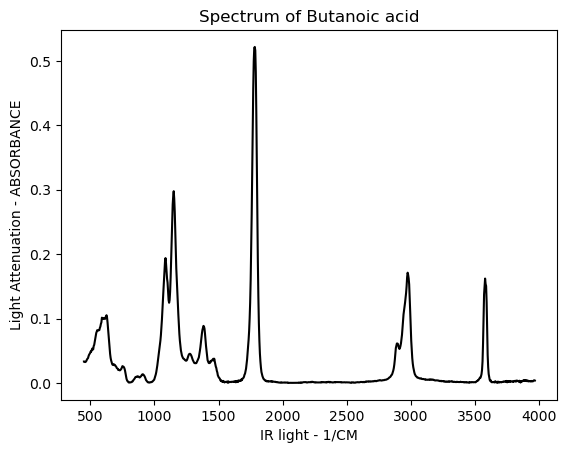

The first x-value in spec_dict for cas: 107926 is 450.0
The last x-value in spec_dict for cas: 107926 is 3966.0


In [34]:
# For the rest of the data points I'm going to need to interpolate to get the data most likely.
# Need to check to see if there are any points where I need extrapolation.

extrap = (df.loc[gas,'firstx'] > 549.8) | (df.loc[gas,'lastx'] < 4000.7)

cas = df.loc[gas & extrap, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

cas = df.loc[gas & extrap, :].index[1] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

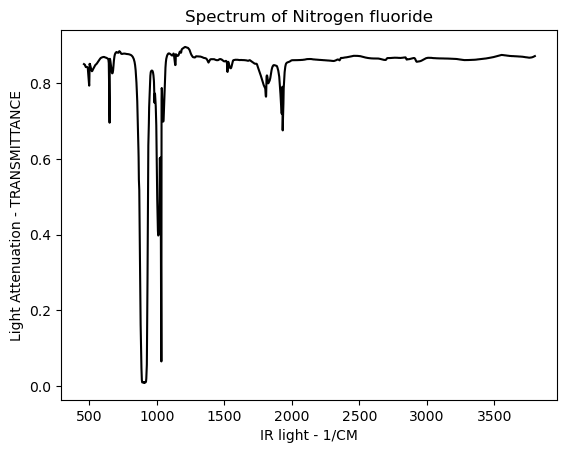

The first x-value in spec_dict for cas: 7783542 is 459.0
The last x-value in spec_dict for cas: 7783542 is 3800.0


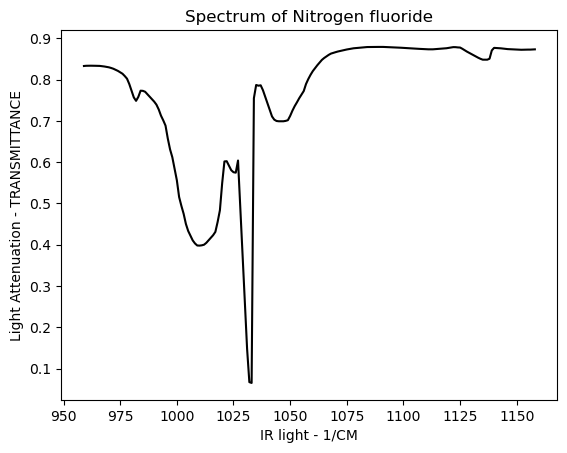

The first x-value in spec_dict for cas: 7783542 is 459.0
The last x-value in spec_dict for cas: 7783542 is 3800.0


In [35]:
# OK now lets look at some of the other types of spectra as well.

# one of the other types has a deltax of 1 cm-1
one = df.loc[gas,'deltax'] == 1

cas = df.loc[gas & one, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

zstrt = 500
zend = 700
cas = df.loc[gas & one, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind][zstrt:zend], spec_dict['y'][ind][zstrt:zend], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

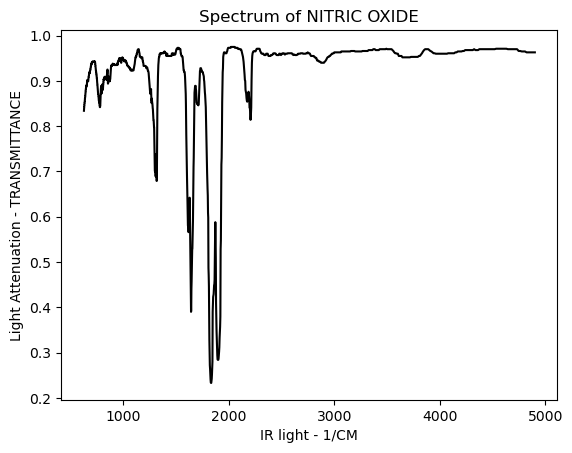

The first x-value in spec_dict for cas: 10102439 is 625.7313234843224
The last x-value in spec_dict for cas: 10102439 is 4901.9607843137255


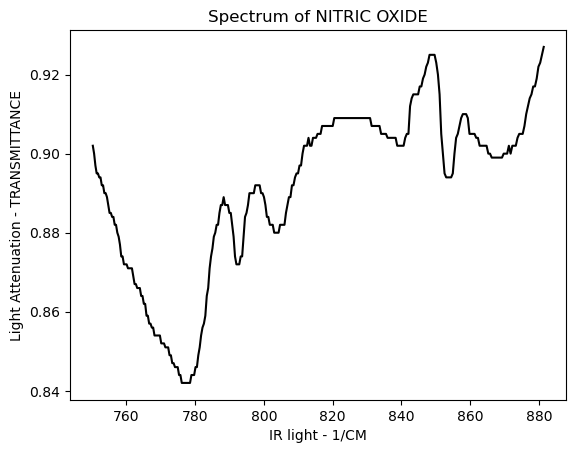

The first x-value in spec_dict for cas: 10102439 is 625.7313234843224
The last x-value in spec_dict for cas: 10102439 is 4901.9607843137255


In [36]:
# Also still have all of the ones converted from wavelength

cas = df.loc[gas & microm, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

zstrt = 400
zend = 700
cas = df.loc[gas & microm, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind][zstrt:zend], spec_dict['y'][ind][zstrt:zend], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

In [37]:
# Hmmm what to do with these lots of things you could imagine doing.  Think I will
# just average the last five data points to replace the missing data points.
# Best would probably be fitting the baseline and using that for extrapolation.
# Could get really fancy and regress the current value to the baseline.

# Now it's time for some interpolation with the gold_x vector above.
# Looks like our range will go from 550 - 3846 as the most common range for deltax of 2 cm-1

#Saving a copy in case I need to revert for testing
tmp_spec_dict = spec_dict

gold_range = (df.loc[gas,'deltax'] == 1.928980) & (df.loc[gas,'firstx'] == 549.8) & (df.loc[gas,'lastx'] == 4000.7)
print('This many spectra already have this x-axis:',sum(gold_range))

cas = df.loc[gas & gold_range,:].index[0]
ind = spec_dict['cas'].index(cas)
gold_x = spec_dict['x'][ind]
print('This is the deltax:', df.loc[cas,'deltax'])

print(gold_x)

for cas in df.loc[gas & ~gold_range,:].index:
    
    # Generate function to interpolate
    ind = spec_dict['cas'].index(cas)
    f = interpolate.interp1d(spec_dict['x'][ind], spec_dict['y'][ind], 
        kind = 'linear', bounds_error = False, 
        fill_value = (np.mean(spec_dict['y'][ind][0:10]),np.mean(spec_dict['y'][ind][-10:-1])))
    
    # Alter spectra with interpolation
    spec_dict['x'][ind] = gold_x
    spec_dict['y'][ind] = f(gold_x)
    
    # Alter meta data
    df.loc[cas,'firstx'] = gold_x[0]
    df.loc[cas,'lastx'] = gold_x[-1]
    df.loc[cas,'maxx'] = gold_x[spec_dict['y'][ind].argmax()]
    df.loc[cas,'minx'] = gold_x[spec_dict['y'][ind].argmin()]
    df.loc[cas,'deltax'] = 1.928980
        

This many spectra already have this x-axis: 2220
This is the deltax: 1.92898
[ 549.759  551.688  553.617 ... 3996.842 3998.771 4000.7  ]


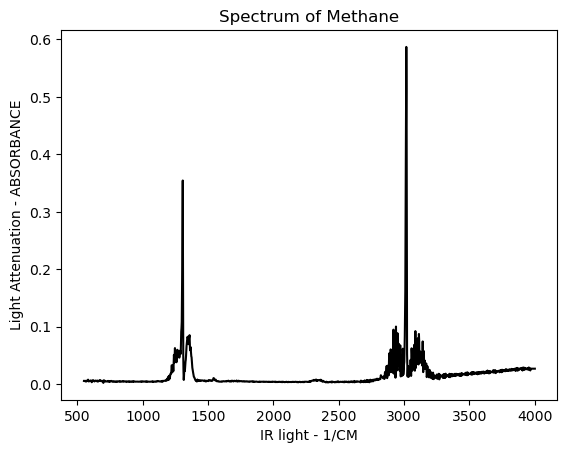

The first x-value in spec_dict for cas: 74828 is 549.759
The last x-value in spec_dict for cas: 74828 is 4000.7


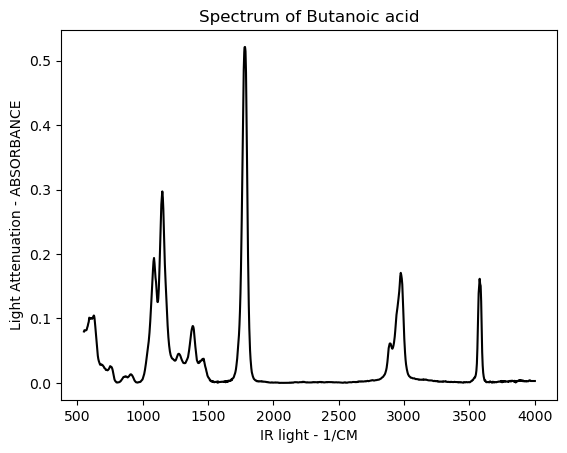

The first x-value in spec_dict for cas: 107926 is 549.759
The last x-value in spec_dict for cas: 107926 is 4000.7


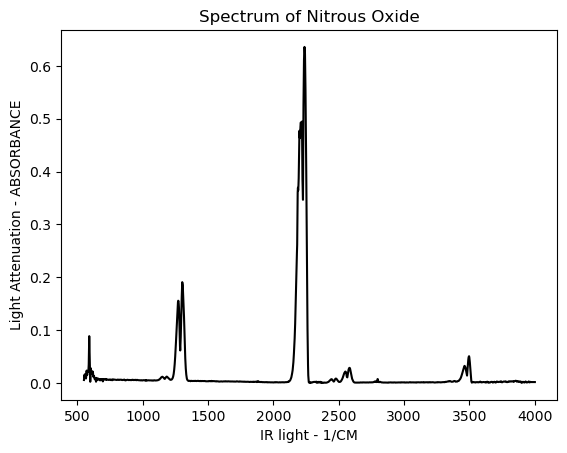

The first x-value in spec_dict for cas: 10024972 is 549.759
The last x-value in spec_dict for cas: 10024972 is 4000.7


In [38]:
# Know from previous method of analysis that deltax of four has some wider range
# spectra.  Need to pull these in order to see how the transformation impacts
# them and how much information we're losing.
# Very briefly let's get a look at what we'll be losing before a transformation

cas = df.loc[gas & wide_range, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

cas = df.loc[gas & wide_range, :].index[1] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

cas = df.loc[gas & wide_range, :].index[2] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

In [39]:
# Did I convert all of these to one deltax? Yes!

df.loc[gas,'deltax'].value_counts()

1.92898    8239
Name: deltax, dtype: int64

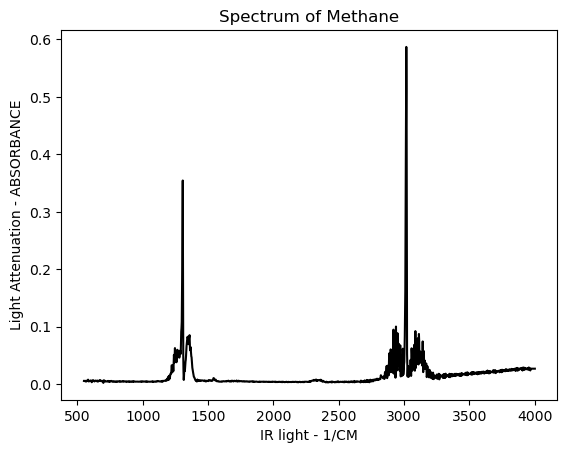

The first x-value in spec_dict for cas: 74828 is 549.759
The last x-value in spec_dict for cas: 74828 is 4000.7


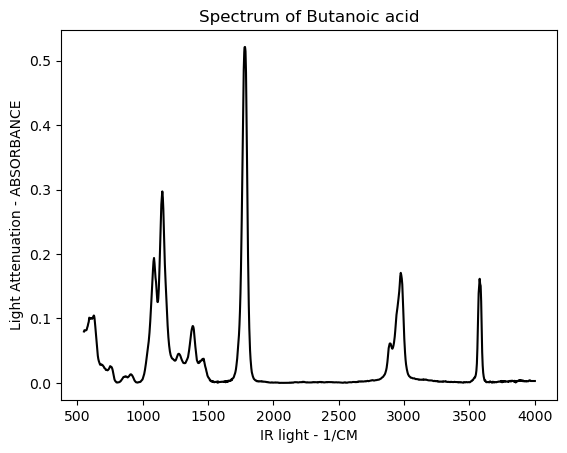

The first x-value in spec_dict for cas: 107926 is 549.759
The last x-value in spec_dict for cas: 107926 is 4000.7


In [40]:
# For the rest of the data points I'm going to need to interpolate to get the data most likely.
# Need to check to see if there are any points where I need extrapolation.

cas = df.loc[gas & extrap, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

cas = df.loc[gas & extrap, :].index[1] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

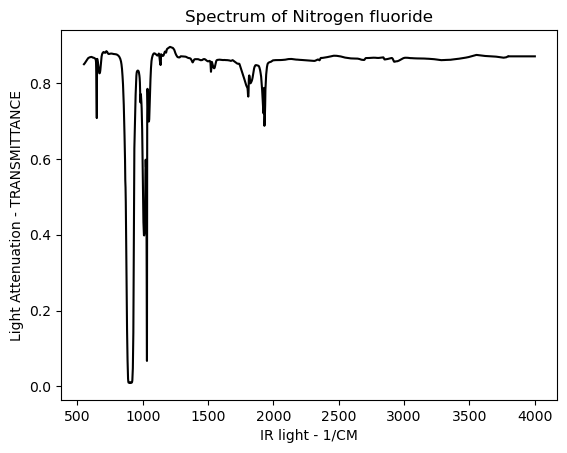

The first x-value in spec_dict for cas: 7783542 is 549.759
The last x-value in spec_dict for cas: 7783542 is 4000.7


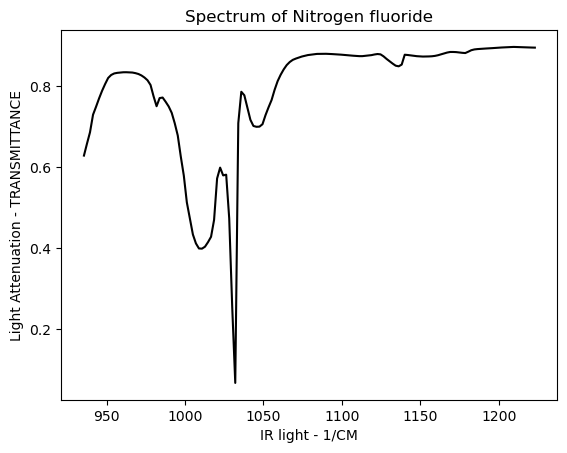

The first x-value in spec_dict for cas: 7783542 is 549.759
The last x-value in spec_dict for cas: 7783542 is 4000.7


In [41]:
# OK now lets look at some of the other types of spectra as well. - 1 cm-1 after conversion

cas = df.loc[gas & one, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

zstrt = 200
zend = 350
cas = df.loc[gas & one, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind][zstrt:zend], spec_dict['y'][ind][zstrt:zend], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

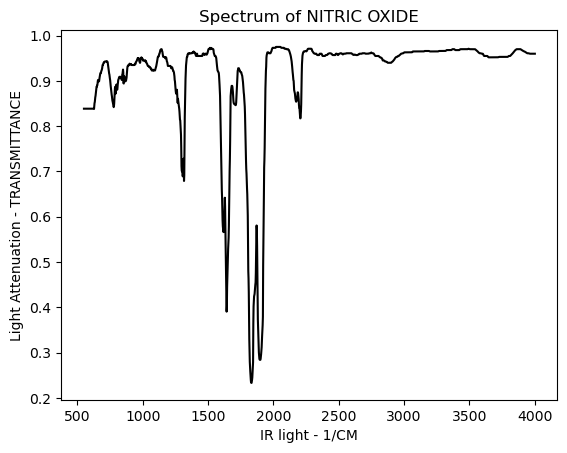

The first x-value in spec_dict for cas: 10102439 is 549.759
The last x-value in spec_dict for cas: 10102439 is 4000.7


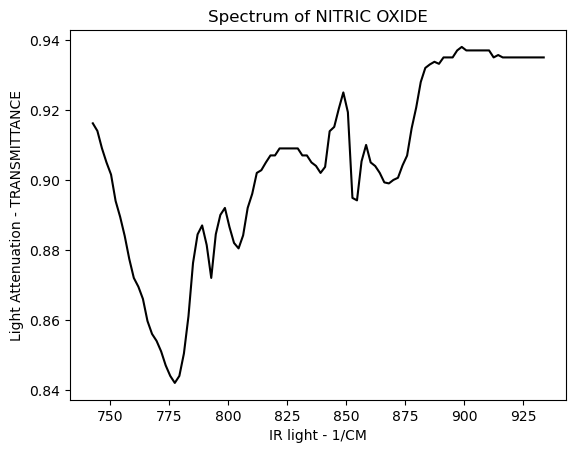

The first x-value in spec_dict for cas: 10102439 is 549.759
The last x-value in spec_dict for cas: 10102439 is 4000.7


In [42]:
# Also still have all of the ones converted from wavelength

cas = df.loc[gas & microm, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

zstrt = 100
zend = 200
cas = df.loc[gas & microm, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind][zstrt:zend], spec_dict['y'][ind][zstrt:zend], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

In [43]:
df.loc[gas,'lastx'].value_counts()

4000.7    8239
Name: lastx, dtype: int64

In [44]:
df.loc[gas,'yunits'].value_counts()

ABSORBANCE                       8183
TRANSMITTANCE                      55
(micromol/mol)-1m-1 (base 10)       1
Name: yunits, dtype: int64

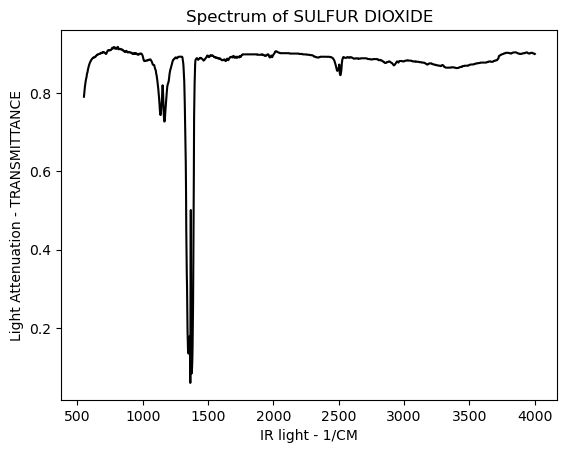

The first x-value in spec_dict for cas: 7446095 is 549.759
The last x-value in spec_dict for cas: 7446095 is 4000.7


In [45]:
# Still need to deal with yunits

trans = df.loc[gas,'yunits'] == 'TRANSMITTANCE'

cas = df.loc[gas & trans, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

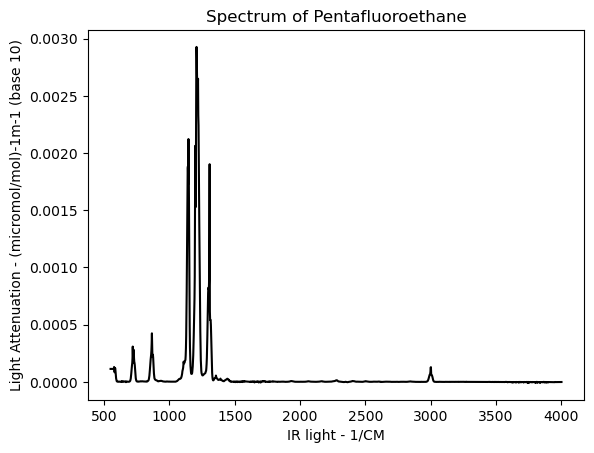

The first x-value in spec_dict for cas: 354336 is 549.759
The last x-value in spec_dict for cas: 354336 is 4000.7


In [46]:
# Check on the one extinction coefficient spectrum

ExtCoeff = (df.loc[gas,'yunits'] == '(micromol/mol)-1m-1 (base 10)')

cas = df.loc[gas & ExtCoeff, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])


# Looks like I should be able to just treat as abosrbance when converting to transmittance (value not outrageously high
# at 10000 or something).  Data will be scaled at the end.

In [47]:
# Getting all absorbance converted

def yconv(absorbance):
    return ((10**(2 - absorbance))/100)

for cas in df.loc[gas & ~trans,:].index:
    ind = spec_dict['cas'].index(cas)
    spec_dict['y'][ind] = yconv(spec_dict['y'][ind])
    df.loc[cas,'yunits'] = 'TRANSMITTANCE'

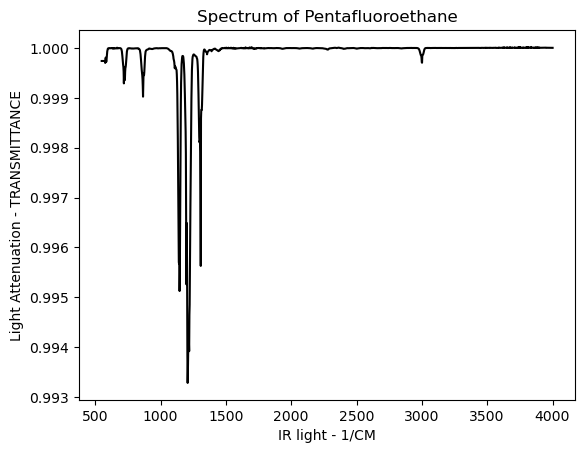

The first x-value in spec_dict for cas: 354336 is 549.759
The last x-value in spec_dict for cas: 354336 is 4000.7


In [48]:
# Checking spectrum after the conversion

cas = df.loc[gas & ExtCoeff, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

In [49]:
# Finally we are ready to get the gas FTIR dataframe!!!
    
gasmat = np.zeros((len(df.loc[gas,:].index), len(gold_x)))
#gasmat[0,:] = gold_x
i = 0

# Make array of all gas indices
for cas in df.loc[gas,:].index:
    ind = spec_dict['cas'].index(cas)
    if len(spec_dict['y'][ind]) != 1790:
        print('y') # error check to see all arrays same length
    if not(np.array_equal(gold_x, spec_dict['x'][ind])):
        print('x') #error check to see if all x = gold_x
    gasmat[i,:] = spec_dict['y'][ind]
    i += 1
    
df_gas = df.loc[gas,:].join(pd.DataFrame(gasmat, index = df.loc[gas,:].index, columns = gold_x))
    



# Data Preparation on the Molecular Side  

The idea here is allow the algorithm to select the functional groups rather than forcing
typical functional groups.  In order to do this I'm going to use the chemical fingerprint
method from RdKit (rdkit fingerprints).  There are several different fingerprints available
and even alternatives using multiple fingerprints to obtain more information, but I'm starting
with the RdKit fingerprint and leaving it open to come back and select another
depending on how well this goes.

Generating these fingerprints is new to me, so I need to do some learning first.

Useful links that helped get me started:

https://www.rdkit.org/docs/Cookbook.html

http://rdkit.blogspot.com/2018/10/using-new-fingerprint-bit-rendering-code.html

https://iwatobipen.wordpress.com/2019/02/08/convert-fingerprint-to-numpy-array-and-conver-numpy-array-to-fingerprint-rdkit-memorandum/


In [50]:
# First see explanations below, but the following molecules will be dropped

# The following two molecules break the valence rule for boron and nitrogen so dropping those from the analysis

problems = ((df_gas.index == '19287457') | (df_gas.index == '4368518'))

df_gas = df_gas.loc[~problems,:]

In [51]:
# First I need some test data and there are typically more interesting functional groups
# on large molecules so I'm going to start there.

df_gas.sort_values('molecular_weight', ascending = False).head(50)

name          formula  \
cas                                                                             
311897                                perfluorotributylamine          C12F27N   
2385855                                                mirex          C10Cl12   
102874                                       tridodecylamine          C36H75N   
2093041    4,4'-bis[2-hydroxyhexafluoroisopropyl]diphenyl...      C18H10F12O3   
335580                                perfluoroheptyl iodide           C7F15I   
143500                                                kepone         C10Cl10O   
2180305       4,4'-bis(2-hydroxyhexafluoroisopropyl)diphenyl      C18H10F12O2   
7695912                   (.+/-.)-«alpha»-tocopherol acetate         C31H52O3   
375951                                perfluorononanoic acid         C9HF17O2   
306945                                      perfluorodecalin           C10F18   
78342                                             dioxathion     C12H26O6P2S4   
6922607                 3,5-di-t-butyl-4-hydroxybenzyl ether         C30H46O3   
175136660    3,3',5,5'-tetrakis(trifluoromethyl)benzophenone        C17H6F12O   
3949471                           hexabutylthiophosphoramide       C24H54N3PS   
84775                                      didecyl phthalate         C28H46O4   
76211      2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9-hexadecafluoro...        C9H2F16O2   
3734494    4,7-methano-1h-indene, 1,2,3,4,5,6,7,8,8-nonac...         C10H5Cl9   
2990172                 p,p'-dibromodiphenyl trichloroethane      C14H9Br2Cl3   
3108245                             ethyl perfluorooctanoate       C10H5F15O2   
35958306         2,2'-ethylidenebis(4,6-di-tert-butylphenol)         C30H46O2   
376181                     1h,1h,9h-hexadecafluoro-1-nonanol         C9H4F16O   
42232291                    hexadecanoic acid, dodecyl ester         C28H56O2   
32509550                      octadecanoic acid, decyl ester         C28H56O2   
118821     phenol, 4,4'-methylenebis[2,6-bis(1,1-dimethyl...         C29H44O2   
37721758                phenol, 2,3,5,6-tetrabromo-4-methyl-         C7H4Br4O   
1031078                                   endosulfan sulfate       C9H6Cl6O4S   
111013                                              squalane           C30H62   
28896493                           p-iodophenyl phenyl ether         C12H8I2O   
77623      2,2'-methylenebis[6-(1-methylcyclohexyl)-p-cre...         C29H40O2   
66230044   benzeneacetic acid, 4-chloro-α-(1-methylethyl)...      C25H22ClNO3   
109799657                       n-octadecyl m-nitrobenzamide       C25H42N2O3   
119073       1,2-benzenedicarboxylic acid, decyl octyl ester         C26H42O4   
7399000                             octadecyltriethoxysilane       C24H52O3Si   
51114126                1,4-bis(heptafluoroisopropyl)benzene         C12H4F14   
335671                          pentadecafluorooctanoic acid         C8HF15O2   
103242             nonanedioic acid, bis(2-ethylhexyl) ester         C25H48O4   
6737424                    1,3-bis(diphenylphosphino)propane         C27H26P2   
21609905                                           leptophos  C13H10BrCl2O2PS   
2879609               phenol, pentachloro-, trichloroacetate          C8Cl8O2   
7683649                                             supraene           C30H50   
57749                                              chlordane         C10H6Cl8   
20244615                 2,4,6-tribromo-2,5-cyclohexadienone         C6H2Br4O   
33213659                                        β-endosulfan       C9H6Cl6O3S   
959988                                          α-endosulfan       C9H6Cl6O3S   
115297                                            endosulfan       C9H6Cl6O3S   
2236524                                  2,2'-diiodobiphenyl          C12H8I2   
70289348                        citric acid, tripentyl ester         C21H38O7   
77907                                 tributyl acetylcitrate         C20H34O8   
304321

In [52]:
# Here I'm making two mol objects from InCHi names for molecules that will have many matching functional groups
# I want to use them to understand the mol object in RDKit

cas1 = '6922607'
cas2 = '28896493'
mol = Chem.inchi.MolFromInchi(df_gas.loc[cas1,'inchi'], sanitize=True, removeHs=False, logLevel=None, treatWarningAsError=False)
mol2 = Chem.inchi.MolFromInchi(df_gas.loc[cas2,'inchi'], sanitize=True, removeHs=False, logLevel=None, treatWarningAsError=False)

In [53]:
# You can get the number of atoms from the mol object

print('Number of bonds in',df.name[cas1],':',mol.GetNumBonds())
print('Number of bonds in',df.name[cas2],':',mol2.GetNumBonds())

Number of bonds in 3,5-di-t-butyl-4-hydroxybenzyl ether : 34
Number of bonds in p-iodophenyl phenyl ether : 15


In [54]:
# You can get the number of atoms from the mol object

print('Number of atoms in',df.name[cas1],':',mol.GetNumAtoms())
print('Number of atoms in',df.name[cas2],':',mol2.GetNumAtoms())

Number of atoms in 3,5-di-t-butyl-4-hydroxybenzyl ether : 33
Number of atoms in p-iodophenyl phenyl ether : 14


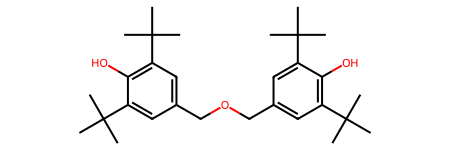

In [55]:
# Here's the structure of molecule 1

mol

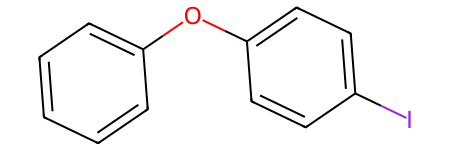

In [56]:
# and molecule 2

mol2

In [57]:
# Going to switch over to MACCs keys

Chem.MACCSkeys.GenMACCSKeys(mol).ToBitString()

'00000000000000000000000000000000000000000000000000000000000000000010000000100000000000100000000000000000000001001100000000000111000100000011010111100110110101011011110'

In [58]:
# From the RDKit documentation these are all of the MACCs keys (bit 0 - 166)

smartsPatts={
  1:('?',0), # ISOTOPE
  #2:('[#104,#105,#106,#107,#106,#109,#110,#111,#112]',0),  # atomic num >103 Not complete
  2:('[#104]',0),  # limit the above def'n since the RDKit only accepts up to #104
  3:('[#32,#33,#34,#50,#51,#52,#82,#83,#84]',0), # Group IVa,Va,VIa Rows 4-6 
  4:('[Ac,Th,Pa,U,Np,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr]',0), # actinide
  5:('[Sc,Ti,Y,Zr,Hf]',0), # Group IIIB,IVB (Sc...)  
  6:('[La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu]',0), # Lanthanide
  7:('[V,Cr,Mn,Nb,Mo,Tc,Ta,W,Re]',0), # Group VB,VIB,VIIB
  8:('[!#6;!#1]1~*~*~*~1',0), # QAAA@1
  9:('[Fe,Co,Ni,Ru,Rh,Pd,Os,Ir,Pt]',0), # Group VIII (Fe...)
  10:('[Be,Mg,Ca,Sr,Ba,Ra]',0), # Group IIa (Alkaline earth)
  11:('*1~*~*~*~1',0), # 4M Ring
  12:('[Cu,Zn,Ag,Cd,Au,Hg]',0), # Group IB,IIB (Cu..)
  13:('[#8]~[#7](~[#6])~[#6]',0), # ON(C)C
  14:('[#16]-[#16]',0), # S-S
  15:('[#8]~[#6](~[#8])~[#8]',0), # OC(O)O
  16:('[!#6;!#1]1~*~*~1',0), # QAA@1
  17:('[#6]#[#6]',0), #CTC
  18:('[#5,#13,#31,#49,#81]',0), # Group IIIA (B...) 
  19:('*1~*~*~*~*~*~*~1',0), # 7M Ring
  20:('[#14]',0), #Si
  21:('[#6]=[#6](~[!#6;!#1])~[!#6;!#1]',0), # C=C(Q)Q
  22:('*1~*~*~1',0), # 3M Ring
  23:('[#7]~[#6](~[#8])~[#8]',0), # NC(O)O
  24:('[#7]-[#8]',0), # N-O
  25:('[#7]~[#6](~[#7])~[#7]',0), # NC(N)N
  26:('[#6]=;@[#6](@*)@*',0), # C$=C($A)$A
  27:('[I]',0), # I
  28:('[!#6;!#1]~[CH2]~[!#6;!#1]',0), # QCH2Q
  29:('[#15]',0),# P
  30:('[#6]~[!#6;!#1](~[#6])(~[#6])~*',0), # CQ(C)(C)A
  31:('[!#6;!#1]~[F,Cl,Br,I]',0), # QX
  32:('[#6]~[#16]~[#7]',0), # CSN
  33:('[#7]~[#16]',0), # NS
  34:('[CH2]=*',0), # CH2=A
  35:('[Li,Na,K,Rb,Cs,Fr]',0), # Group IA (Alkali Metal)
  36:('[#16R]',0), # S Heterocycle
  37:('[#7]~[#6](~[#8])~[#7]',0), # NC(O)N
  38:('[#7]~[#6](~[#6])~[#7]',0), # NC(C)N
  39:('[#8]~[#16](~[#8])~[#8]',0), # OS(O)O
  40:('[#16]-[#8]',0), # S-O
  41:('[#6]#[#7]',0), # CTN
  42:('F',0), # F
  43:('[!#6;!#1;!H0]~*~[!#6;!#1;!H0]',0), # QHAQH
  44:('?',0), # OTHER
  45:('[#6]=[#6]~[#7]',0), # C=CN
  46:('Br',0), # BR
  47:('[#16]~*~[#7]',0), # SAN
  48:('[#8]~[!#6;!#1](~[#8])(~[#8])',0), # OQ(O)O
  49:('[!+0]',0), # CHARGE  
  50:('[#6]=[#6](~[#6])~[#6]',0), # C=C(C)C
  51:('[#6]~[#16]~[#8]',0), # CSO
  52:('[#7]~[#7]',0), # NN
  53:('[!#6;!#1;!H0]~*~*~*~[!#6;!#1;!H0]',0), # QHAAAQH
  54:('[!#6;!#1;!H0]~*~*~[!#6;!#1;!H0]',0), # QHAAQH
  55:('[#8]~[#16]~[#8]',0), #OSO
  56:('[#8]~[#7](~[#8])~[#6]',0), # ON(O)C
  57:('[#8R]',0), # O Heterocycle
  58:('[!#6;!#1]~[#16]~[!#6;!#1]',0), # QSQ
  59:('[#16]!:*:*',0), # Snot%A%A
  60:('[#16]=[#8]',0), # S=O
  61:('*~[#16](~*)~*',0), # AS(A)A
  62:('*@*!@*@*',0), # A$!A$A
  63:('[#7]=[#8]',0), # N=O
  64:('*@*!@[#16]',0), # A$A!S
  65:('c:n',0), # C%N
  66:('[#6]~[#6](~[#6])(~[#6])~*',0), # CC(C)(C)A
  67:('[!#6;!#1]~[#16]',0), # QS
  68:('[!#6;!#1;!H0]~[!#6;!#1;!H0]',0), # QHQH (&...) SPEC Incomplete
  69:('[!#6;!#1]~[!#6;!#1;!H0]',0), # QQH
  70:('[!#6;!#1]~[#7]~[!#6;!#1]',0), # QNQ
  71:('[#7]~[#8]',0), # NO
  72:('[#8]~*~*~[#8]',0), # OAAO
  73:('[#16]=*',0), # S=A
  74:('[CH3]~*~[CH3]',0), # CH3ACH3
  75:('*!@[#7]@*',0), # A!N$A
  76:('[#6]=[#6](~*)~*',0), # C=C(A)A
  77:('[#7]~*~[#7]',0), # NAN
  78:('[#6]=[#7]',0), # C=N
  79:('[#7]~*~*~[#7]',0), # NAAN
  80:('[#7]~*~*~*~[#7]',0), # NAAAN
  81:('[#16]~*(~*)~*',0), # SA(A)A
  82:('*~[CH2]~[!#6;!#1;!H0]',0), # ACH2QH
  83:('[!#6;!#1]1~*~*~*~*~1',0), # QAAAA@1
  84:('[NH2]',0), #NH2
  85:('[#6]~[#7](~[#6])~[#6]',0), # CN(C)C
  86:('[C;H2,H3][!#6;!#1][C;H2,H3]',0), # CH2QCH2
  87:('[F,Cl,Br,I]!@*@*',0), # X!A$A
  88:('[#16]',0), # S
  89:('[#8]~*~*~*~[#8]',0), # OAAAO
  90:('[$([!#6;!#1;!H0]~*~*~[CH2]~*),$([!#6;!#1;!H0;R]1@[R]@[R]@[CH2;R]1),$([!#6;!#1;!H0]~[R]1@[R]@[CH2;R]1)]',0), # QHAACH2A
  91:('[$([!#6;!#1;!H0]~*~*~*~[CH2]~*),$([!#6;!#1;!H0;R]1@[R]@[R]@[R]@[CH2;R]1),$([!#6;!#1;!H0]~[R]1@[R]@[R]@[CH2;R]1),$([!#6;!#1;!H0]~*~[R]1@[R]@[CH2;R]1)]',0), # QHAAACH2A
  92:('[#8]~[#6](~[#7])~[#6]',0), # OC(N)C
  93:('[!#6;!#1]~[CH3]',0), # QCH3
  94:('[!#6;!#1]~[#7]',0), # QN
  95:('[#7]~*~*~[#8]',0), # NAAO
  96:('*1~*~*~*~*~1',0), # 5 M ring
  97:('[#7]~*~*~*~[#8]',0), # NAAAO
  98:('[!#6;!#1]1~*~*~*~*~*~1',0), # QAAAAA@1
  99:('[#6]=[#6]',0), # C=C
  100:('*~[CH2]~[#7]',0), # ACH2N
  101:('[$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1)]',0), # 8M Ring or larger. This only handles up to ring sizes of 14
  102:('[!#6;!#1]~[#8]',0), # QO
  103:('Cl',0), # CL
  104:('[!#6;!#1;!H0]~*~[CH2]~*',0), # QHACH2A
  105:('*@*(@*)@*',0), # A$A($A)$A
  106:('[!#6;!#1]~*(~[!#6;!#1])~[!#6;!#1]',0), # QA(Q)Q
  107:('[F,Cl,Br,I]~*(~*)~*',0), # XA(A)A
  108:('[CH3]~*~*~*~[CH2]~*',0), # CH3AAACH2A
  109:('*~[CH2]~[#8]',0), # ACH2O
  110:('[#7]~[#6]~[#8]',0), # NCO
  111:('[#7]~*~[CH2]~*',0), # NACH2A
  112:('*~*(~*)(~*)~*',0), # AA(A)(A)A
  113:('[#8]!:*:*',0), # Onot%A%A
  114:('[CH3]~[CH2]~*',0), # CH3CH2A
  115:('[CH3]~*~[CH2]~*',0), # CH3ACH2A
  116:('[$([CH3]~*~*~[CH2]~*),$([CH3]~*1~*~[CH2]1)]',0), # CH3AACH2A
  117:('[#7]~*~[#8]',0), # NAO
  118:('[$(*~[CH2]~[CH2]~*),$(*1~[CH2]~[CH2]1)]',1), # ACH2CH2A > 1
  119:('[#7]=*',0), # N=A
  120:('[!#6;R]',1), # Heterocyclic atom > 1 (&...) Spec Incomplete
  121:('[#7;R]',0), # N Heterocycle
  122:('*~[#7](~*)~*',0), # AN(A)A
  123:('[#8]~[#6]~[#8]',0), # OCO
  124:('[!#6;!#1]~[!#6;!#1]',0), # QQ
  125:('?',0), # Aromatic Ring > 1
  126:('*!@[#8]!@*',0), # A!O!A
  127:('*@*!@[#8]',1), # A$A!O > 1 (&...) Spec Incomplete
  128:('[$(*~[CH2]~*~*~*~[CH2]~*),$([R]1@[CH2;R]@[R]@[R]@[R]@[CH2;R]1),$(*~[CH2]~[R]1@[R]@[R]@[CH2;R]1),$(*~[CH2]~*~[R]1@[R]@[CH2;R]1)]',0), # ACH2AAACH2A
  129:('[$(*~[CH2]~*~*~[CH2]~*),$([R]1@[CH2]@[R]@[R]@[CH2;R]1),$(*~[CH2]~[R]1@[R]@[CH2;R]1)]',0), # ACH2AACH2A
  130:('[!#6;!#1]~[!#6;!#1]',1), # QQ > 1 (&...)  Spec Incomplete
  131:('[!#6;!#1;!H0]',1), # QH > 1
  132:('[#8]~*~[CH2]~*',0), # OACH2A
  133:('*@*!@[#7]',0), # A$A!N
  134:('[F,Cl,Br,I]',0), # X (HALOGEN)
  135:('[#7]!:*:*',0), # Nnot%A%A
  136:('[#8]=*',1), # O=A>1 
  137:('[!C;!c;R]',0), # Heterocycle
  138:('[!#6;!#1]~[CH2]~*',1), # QCH2A>1 (&...) Spec Incomplete
  139:('[O;!H0]',0), # OH
  140:('[#8]',3), # O > 3 (&...) Spec Incomplete
  141:('[CH3]',2), # CH3 > 2  (&...) Spec Incomplete
  142:('[#7]',1), # N > 1
  143:('*@*!@[#8]',0), # A$A!O
  144:('*!:*:*!:*',0), # Anot%A%Anot%A
  145:('*1~*~*~*~*~*~1',1), # 6M ring > 1
  146:('[#8]',2), # O > 2
  147:('[$(*~[CH2]~[CH2]~*),$([R]1@[CH2;R]@[CH2;R]1)]',0), # ACH2CH2A
  148:('*~[!#6;!#1](~*)~*',0), # AQ(A)A
  149:('[C;H3,H4]',1), # CH3 > 1
  150:('*!@*@*!@*',0), # A!A$A!A
  151:('[#7;!H0]',0), # NH
  152:('[#8]~[#6](~[#6])~[#6]',0), # OC(C)C
  153:('[!#6;!#1]~[CH2]~*',0), # QCH2A
  154:('[#6]=[#8]',0), # C=O
  155:('*!@[CH2]!@*',0), # A!CH2!A
  156:('[#7]~*(~*)~*',0), # NA(A)A
  157:('[#6]-[#8]',0), # C-O
  158:('[#6]-[#7]',0), # C-N
  159:('[#8]',1), # O>1
  160:('[C;H3,H4]',0), #CH3
  161:('[#7]',0), # N
  162:('a',0), # Aromatic
  163:('*1~*~*~*~*~*~1',0), # 6M Ring
  164:('[#8]',0), # O
  165:('[R]',0), # Ring
  166:('?',0), # Fragments  FIX: this can't be done in SMARTS
  }

In [59]:
# Now move on to generation of the fingerprints
# The RdKit fingerprint checks for features and then digitzes the chemical structure by storing
# each of those features as bits (0 or 1).
#
# the bitInfo dict is a dictionary containing the bits detected and the instances of those
# bits in the molecule

bmap = {} #empty dict to place the bit mapping to the molecule
fps = Chem.RDKFingerprint(mol, bitInfo = bmap)

# Here I'm converting the fingerprint to a bit string so I can see what the bit string looks like.
# The bit string shows 1 if that feature was detected in the molecule (could be once or 10 times)
# and a 0 if it was not detected

BStr = fps.ToBitString()
print('Bit String:\n',BStr)

# Here are all of the keys in the bitInfo dictionary.  Note that each of the keys is the location
# of the 1 bits in the BitString

print('\nBit Information Dict Keys:\n',bmap.keys())

# Here is the output of one of the bits in the bitmap

print('\nBit 7 examples:\n',bmap[7])

# I would like to use the BitString as the dependent variable to predict with the FTIR spectrum.
# If I want to do this - I have to be able to convert back to a fingerprint for comparison to 
# the database or comparison to another database.

fpscopy = Chem.DataStructs.cDataStructs.CreateFromBitString(BStr)

# Now I want to take the fpscopy and compare back to the fps fingerprint
print('\nTanimoto Similarity of Fingerprint and Fingerprint from Bit String:',Chem.DataStructs.TanimotoSimilarity(fps,fpscopy))

# Excellent the target dependent variable for the model will be the bit string and
# then I can convert back to the fingerprint.
# To my knowledge it's not possible to convert back to the .mol file
# However, I could compare to the library I have or to other libraries of molecules
# to identify molecules.
# Additionally, I could report the bits as being identified in the model.


Bit String:
 000000011000000000000011000001000000000000001000000010000000000000000000000000010000000000011101000000010000000000010001000000000100000000000001000000010000000001010000001001011000100010000000001011100000101010000001100000000000000000010000000000000000000000100000000000010000010000000000000000100000010000001100010000010101000000110101000000001000000000000100000000101000000000000000000000000000000000000111001100000000000001010000000000011100011100000000000001001000000101000000010000000000000000000000000110100000000000001000000000101000110100001000000000000011000000010000100100000000100000001100011001001000000000000000000000000000000110000000100000010000110000010000000000100000010000000010001000001000010001000000000000000000000100010000100010000000100000000101001000010000000011000000100100000001010000011000001000001010001000100100001010000100001101010000000000000100000000000000010000000010100001000100000101000100000100100000100000100010000010100001000000001000000001011010011

In [60]:
bmap

{7: [[0, 25, 2, 24, 32, 13],
  [0, 25, 1, 24, 32, 13],
  [1, 25, 2, 24, 32, 13],
  [3, 27, 5, 26, 32, 15],
  [3, 27, 4, 26, 32, 15],
  [4, 27, 5, 26, 32, 15],
  [6, 29, 8, 28, 33, 17],
  [6, 29, 7, 28, 33, 17],
  [7, 29, 8, 28, 33, 17],
  [9, 31, 11, 30, 33, 19],
  [9, 31, 10, 30, 33, 19],
  [10, 31, 11, 30, 33, 19]],
 8: [[12, 20, 21, 23], [14, 20, 21, 23], [16, 22, 23, 21], [18, 22, 23, 21]],
 22: [[12, 20, 13, 24, 26, 27],
  [12, 14, 15, 27, 13, 25],
  [14, 20, 15, 26, 24, 25],
  [16, 22, 17, 28, 30, 31],
  [16, 18, 19, 31, 17, 29],
  [18, 22, 19, 30, 28, 29]],
 23: [[20, 21, 23],
  [21, 23, 22],
  [12, 20, 14, 15, 26, 21, 13],
  [12, 20, 14, 15, 21, 13, 24],
  [16, 22, 18, 19, 30, 23, 17],
  [16, 22, 18, 19, 23, 17, 28]],
 29: [[0, 25, 2, 24, 26, 13, 12],
  [0, 25, 1, 24, 26, 13, 12],
  [1, 25, 2, 24, 26, 13, 12],
  [3, 27, 5, 26, 24, 15, 14],
  [3, 27, 4, 26, 24, 15, 14],
  [4, 27, 5, 26, 24, 15, 14],
  [6, 29, 8, 28, 30, 17, 16],
  [6, 29, 7, 28, 30, 17, 16],
  [7, 29, 8, 28, 30,

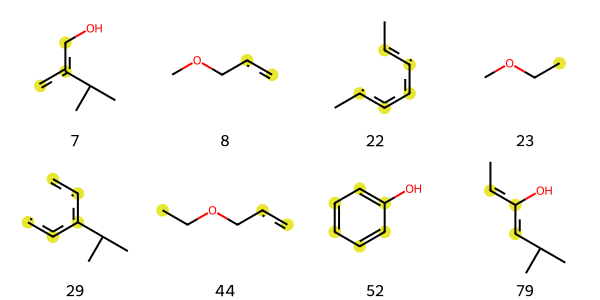

In [61]:
# So what about the bits?  How do they look for these molecules and what are they?

tpls = [(mol,x,bmap) for x in bmap] # make a list of tuples of the mol object, key from bmap, and bmap
Draw.DrawRDKitBits(tpls[0:8],molsPerRow=4,legends=[str(x) for x in bmap][:8]) # Draw the bits on a grid

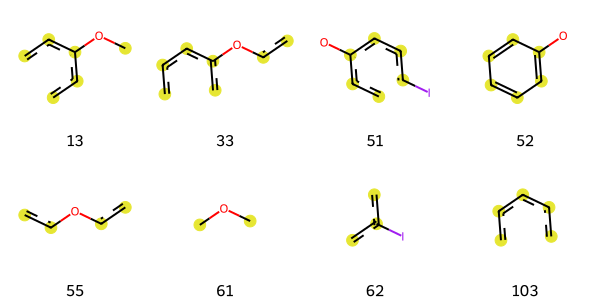

In [62]:
bmap2 = {}
fps2 = Chem.RDKFingerprint(mol2, bitInfo = bmap2)

tpls2 = [(mol2,x,bmap2) for x in bmap2]
Draw.DrawRDKitBits(tpls2[0:8],molsPerRow=4,legends=[str(x) for x in bmap2][0:8])

From the above we can see that it's possible to generate fingerprints for each molecule where each bit
represents whether or not a certain set of atoms and bonds is present.

This set of bits will be the dependent variable for the model.  I can also take the output from the model and
show the bits that are detected as well as generate fingerprints from those bits.

The final metrics of the model could be how well we can predict each of those bits, and the similarity of 
the final prediction to the actual molecule.

In [149]:
#ALright time to generate these bit strings, for the MACCS Keys

# Note these two molecules are causing issues to breaking the octet rule
# for boron and nitrogen.  Going to remove them for now
#problems = ((df_gas.index == '19287457') | (df_gas.index == '4368518'))
# Commenting line above out because I dropped these from analysis

col = ['MK' + str(x) for x in range(0,167)]
mols = [Chem.inchi.MolFromInchi(df_gas.loc[x,'inchi'], sanitize=True, removeHs=False, logLevel=None, treatWarningAsError=True) for x in df_gas.index]
allMKs = [Chem.MACCSkeys.GenMACCSKeys(x) for x in mols]

MK_matrix = np.zeros((df_gas.shape[0], 167))
for MK, i in zip(allMKs, range(0,len(allMKs))):
    MK_matrix[i,:] = MK.ToList() 

df_gas = df_gas.join(pd.DataFrame(MK_matrix, index = df_gas.index, columns = col))
df_gas.loc[:,'mols'] = mols

[23:35:27] Cannot assign bond directions!


In [64]:
# Quick question - Are there any bits with all 0s in the fingerprint?  Yes - will drop these from the analysis

df_gas.loc[:,'MK0':'MK166'].sum().sort_values()

MK0         0.0
MK1         0.0
MK2         0.0
MK35        0.0
MK4         0.0
          ...  
MK162    4728.0
MK163    5107.0
MK160    5268.0
MK164    5379.0
MK165    5623.0
Length: 167, dtype: float64

In [65]:
# Drop these columns

dropcol = df_gas.loc[:,'MK0':'MK166'].loc[:,df_gas.loc[:,'MK0':'MK166'].sum() == 0].columns.tolist()

df_gas = df_gas.drop(columns = dropcol)

In [66]:
# Quick question - Are there any bits with all 0s in the fingerprint?  Yes - will drop these from the analysis

df_gas.loc[:,'MK11':'MK166'].sum().sort_values()

df_gas = df_gas.drop(columns = ['MK12']) # Dropping MK12 because there are only two values (hard to build a model)

In [67]:
# Quick question - Are there any bits with all 1s in the fingerprint?  No

df_gas.loc[:,'MK11':'MK166'].sum().sort_values(ascending = False).tolist()[0:5]

[5623.0, 5379.0, 5268.0, 5107.0, 4728.0]

In [68]:
# Quick question - Are there any molecules with no features (bits)? No

df_gas.loc[:,'MK11':'MK166'].sum(axis = 1).sort_values().tolist()[0:10]

[1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]

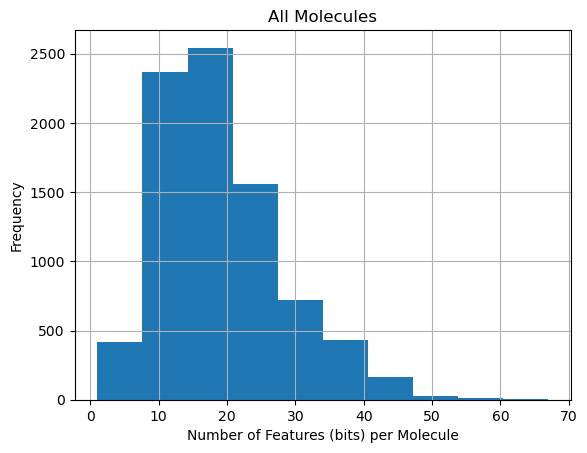

In [69]:
(df_gas.loc[:,'MK11':'MK166'].sum(axis = 1)).hist()
plt.xlabel('Number of Features (bits) per Molecule')
plt.title('All Molecules')
plt.ylabel('Frequency')
plt.show()

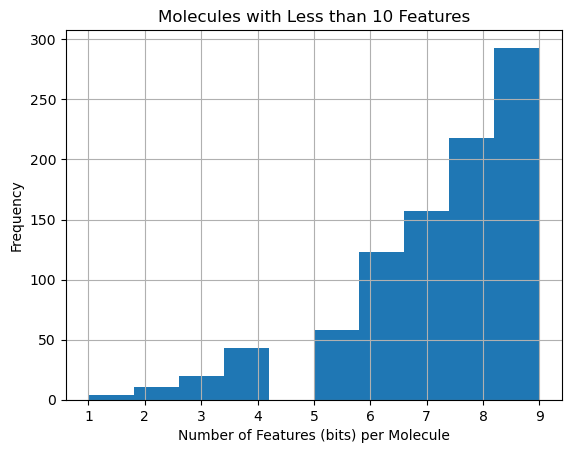

In [70]:
low = df_gas.loc[:,'MK11':'MK166'].sum(axis = 1) < 10
df_gas.loc[low,'MK11':'MK166'].sum(axis = 1).hist()
plt.xlabel('Number of Features (bits) per Molecule')
plt.title('Molecules with Less than 10 Features')
plt.ylabel('Frequency')
plt.show()

# Data Cleaning for Gas Spectra Complete
# On to Initial EDA and Quick Modeling

In [71]:
# At first I converted everything to absorbance because most of the spectra were
# in absorbnce - however, some of the transmittance spectra have 0 transmittance
# which gives infinite absorbance.
# Switched over to transmittance and now the np.isinf() function shows no infinite

spectra = [549.759, 4000.7] # labels of first and last columns of spectra
MKfp = ['MK11','MK166'] # labels of first and last columns of fingerprint bits

np.isinf(df_gas.loc[:,spectra[0]:spectra[1]]).any().any()

False

109999
(2,)


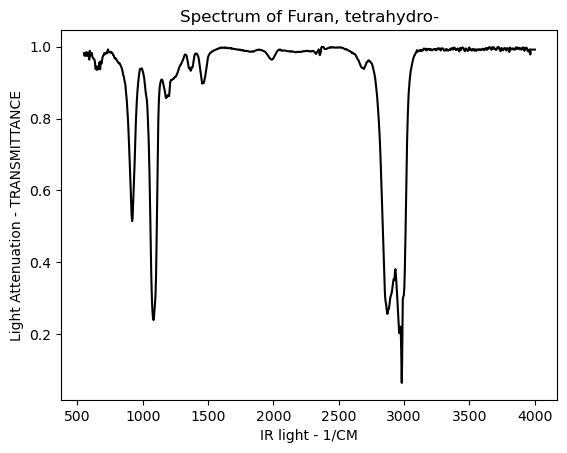

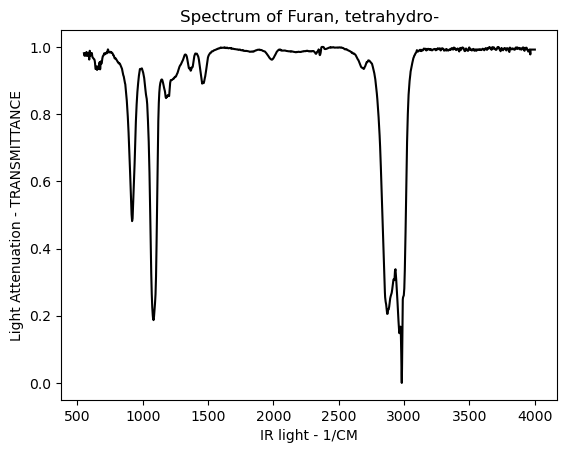

In [72]:
# Here I'm just using the MinMaxScaler() to scale the data

std = MinMaxScaler()

gasmat_std = np.transpose(std.fit_transform(np.transpose(df_gas.loc[:,spectra[0]:spectra[1]].to_numpy())))


# Verifying the scaling works as expected

ind = 300
cas = df_gas.index[ind]
print(cas)
print(df_gas.loc[cas,spectra].shape)
plt.plot(gold_x,df_gas.loc[cas,spectra[0]:spectra[1]], color='black')
plt.xlabel('IR light - ' + df_gas.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df_gas.loc[cas,'yunits'])
plt.title('Spectrum of ' + df_gas.loc[cas,'title'])
plt.show()

plt.plot(gold_x,gasmat_std[ind,:], color='black')
plt.xlabel('IR light - ' + df_gas.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df_gas.loc[cas,'yunits'])
plt.title('Spectrum of ' + df_gas.loc[cas,'title'])
plt.show()

In [73]:
# Time to split up the dataset in train and test
# I want to do some PCA and KNN in the initial EDA
# to help me explore this dataset before decising on
# the approach for modeling

X = gasmat_std
y = df_gas.loc[:,MKfp[0]:MKfp[1]].to_numpy()

# Also getting the indices so that I have the cas numbers

(
 X_train, X_test, 
 y_train, y_test,
 indices_train, indices_test 
) = train_test_split(X, y, df_gas.index, test_size=0.2, random_state=42)

99.01657546153808


(6589, 110)

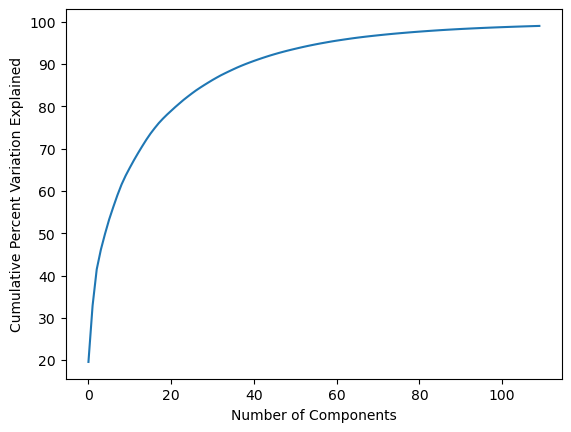

In [74]:
# Now do PCA to reduce the dimensionality of x
# Want to get some idea of how much compression I can
# get with PCA and what type of FTIR features the different
# components are centered around

PC = PCA(n_components = 0.99)
gasmat_pca = PC.fit_transform(X_train)

print(sum(PC.explained_variance_ratio_)*100)

plt.plot(np.cumsum(PC.explained_variance_ratio_*100))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Percent Variation Explained')

gasmat_pca.shape #110 components down from 1790 data points

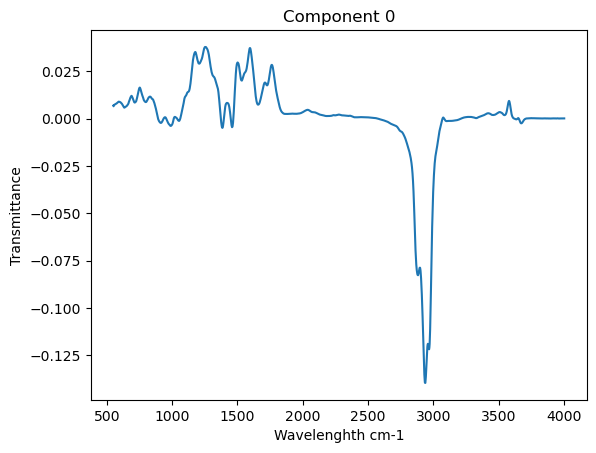

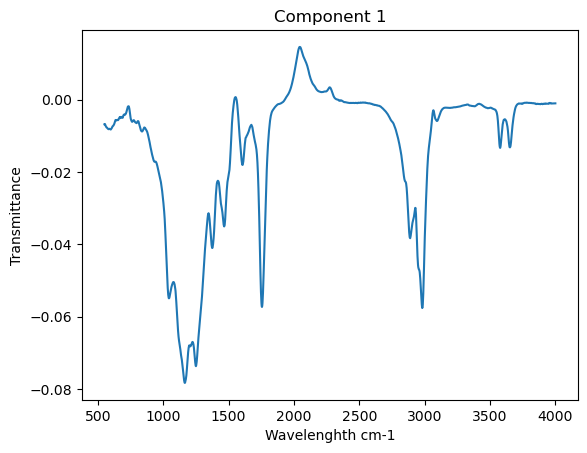

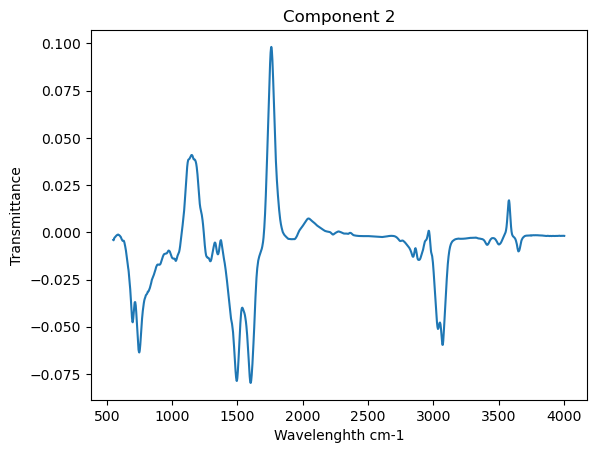

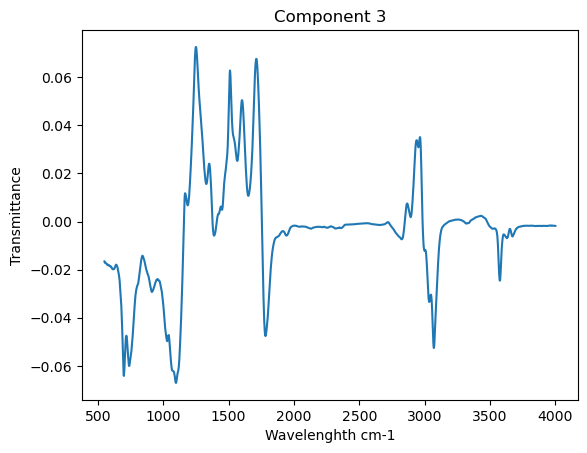

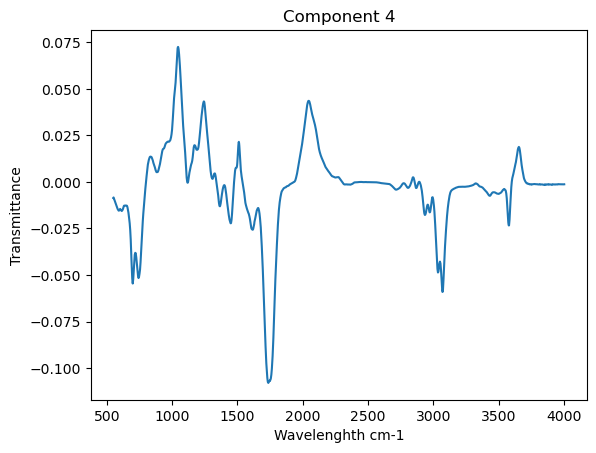

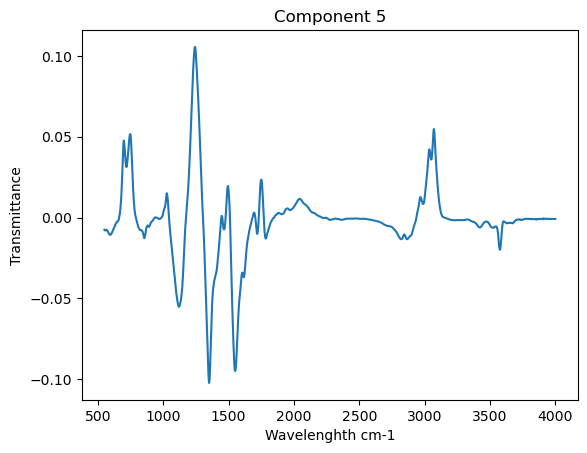

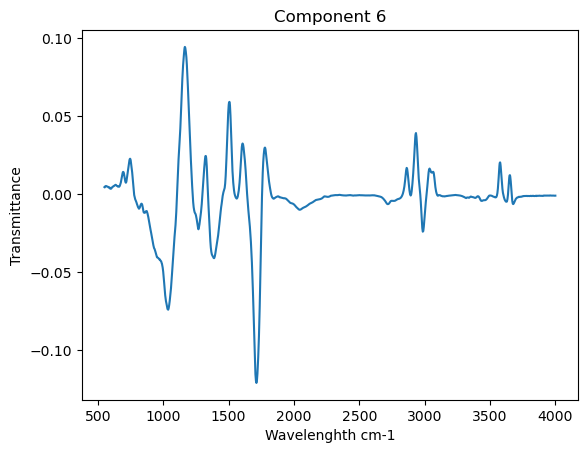

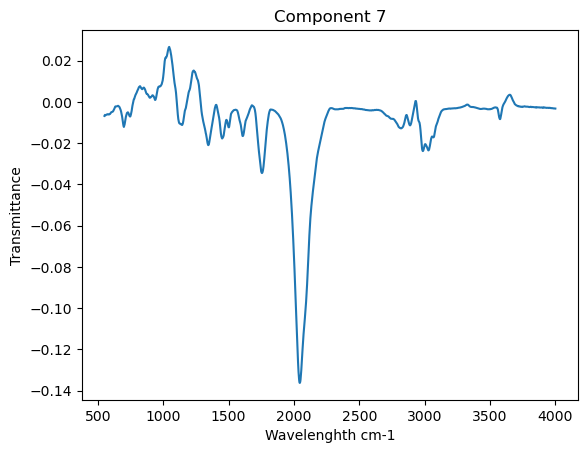

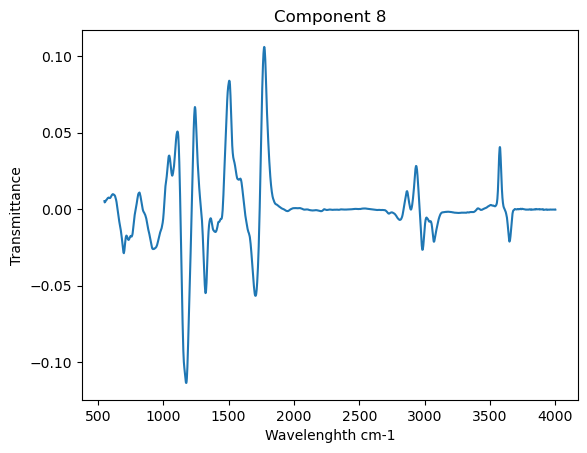

In [75]:
# Since it looks like I'm going to decompose the transmission values with PCA
# let's get a look at the top ten components

for i in range(0,9):
    plt.plot(gold_x,PC.components_[i,:])
    plt.xlabel('Wavelenghth cm-1')
    plt.ylabel('Transmittance')
    plt.title('Component ' + str(i))
    plt.show()
    


From the plots above you can see various different bands in each component.  The components are not broken into simple peaks as are shown in various tables (i.e. medium band at 1200 cm-1).

99.00651124384596


(6589, 101)

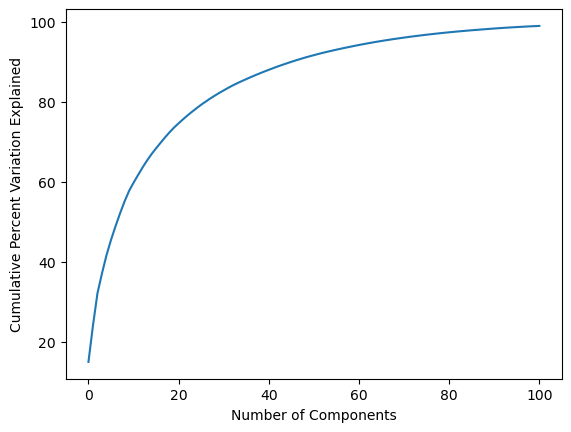

In [76]:
# Now do PCA to reduce the dimensionality of y
# May or may not use this

PCy = PCA(n_components = 0.99)
fp_pca = PCy.fit_transform(y_train)

print(sum(PCy.explained_variance_ratio_)*100)

plt.plot(np.cumsum(PCy.explained_variance_ratio_*100))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Percent Variation Explained')

fp_pca.shape # This compression goes from ~150 to 101 - not much benefit from doing this for the fingerprints




<b> Stopping here and not going to  re-run the initial model fitting

    

In [77]:
# Alright giving this a shot with a K Neighbors Classifier
# Going to fit this with the MultiOutputClassifier wrapper around the KNN classifier
# Going to start out without adding PCA in the pipeline and consider adding back later

bit_df = pd.DataFrame(columns = ['test_accuracy_KNN', 'test_precision_KNN', 'test_recall_KNN', 'test_f1_KNN', 'TP_KNN_test'])
model_df = pd.DataFrame(columns = ['fit_time_KNN', 'predict_time_KNN', 'score_time_KNN'])

# Set up folds for cross validation
kf = KFold(n_splits = 5)
kf.get_n_splits(gasmat_pca)

def score_func(y,y_pred):
    f1_score = np.zeros(y_pred.shape[1])
    acc_score = np.zeros(y_pred.shape[1])
    prec_score = np.zeros(y_pred.shape[1])
    rec_score = np.zeros(y_pred.shape[1])
    truepos_sum = np.zeros(y_pred.shape[1])
    jaccard_score = np.zeros(y_pred.shape[1])
    
    for i in range(y_pred.shape[1]):
        acc_score[i] = metrics.accuracy_score(y[:,i], y_pred[:,i])
        rec_score[i] = metrics.recall_score(y[:,i], y_pred[:,i], zero_division = 1)
        truepos_sum[i] = y[:,i].sum()
        prec_score[i] = metrics.precision_score(y[:,i], y_pred[:,i], zero_division = 0)
        f1_score[i] = metrics.f1_score(y[:,i], y_pred[:,i], zero_division = 0)
        predpos_sum = y_pred[:,i].sum()
        jaccard_score[i] = metrics.jaccard_score(y[:,i], y_pred[:,i], zero_division = 0)
        if truepos_sum[i] == 0:  # If I catch any 0 True positives I want to set precision and f1_score to 1 if no bits were predicted
            if predpos_sum == 0:
                prec_score[i] = 1
                f1_score[i] = 1
                jaccard_score[i] = 1
                       
    return acc_score, prec_score, rec_score, f1_score, truepos_sum, jaccard_score

test_accuracy_KNN = np.zeros((y_train.shape[1],5))
test_precision_KNN = np.zeros((y_train.shape[1],5))
test_recall_KNN = np.zeros((y_train.shape[1],5))
test_f1_KNN = np.zeros((y_train.shape[1],5))
TP_KNN_test = np.zeros((y_train.shape[1],5))
test_jaccard_KNN = np.zeros((y_train.shape[1],5))

for i, (train_index, test_index) in enumerate(kf.split(gasmat_pca)):
    print('Working on Fold:',i,'Model Fitting.............',end='\r')
    clf = MultiOutputClassifier(KNeighborsClassifier())
    start = time.time()
    clf.fit(gasmat_pca[train_index,:],y_train[train_index,:])
    end = time.time()
    model_df.loc[i,'fit_time_KNN'] = end - start
    
    print('Working on Fold:',i,'Predicting.............',end='\r')
    start = time.time()
    y_hat = clf.predict(gasmat_pca[test_index,:])
    end = time.time()
    model_df.loc[i,'predict_time_KNN'] = end - start

    print('Working on Fold:',i,'Scoring.............',end='\r')
    start = time.time()
    test_accuracy_KNN[:,i], test_precision_KNN[:,i], test_recall_KNN[:,i], test_f1_KNN[:,i], TP_KNN_test[:,i], test_jaccard_KNN[:,i] = score_func(y_train[test_index,:],y_hat)
    end = time.time()
    model_df.loc[i,'score_time_KNN'] = end - start
       
    
bit_df = pd.DataFrame(columns = ['test_accuracy_KNN', 'test_precision_KNN', 'test_recall_KNN', 'test_f1_KNN', 'TP_KNN_test'])
bit_df.loc[:,'test_accuracy_KNN'] = np.mean(test_accuracy_KNN, axis = 1)
bit_df.loc[:,'test_precision_KNN'] = np.mean(test_precision_KNN, axis = 1)
bit_df.loc[:,'test_recall_KNN'] = np.mean(test_recall_KNN, axis = 1)
bit_df.loc[:,'test_f1_KNN'] = np.mean(test_f1_KNN, axis = 1)
bit_df.loc[:,'TP_KNN_test'] = np.sum(TP_KNN_test == 0, axis = 1) #sum up 0 value true pos
bit_df.loc[:,'test_jaccard_KNN'] = np.mean(test_jaccard_KNN, axis = 1)

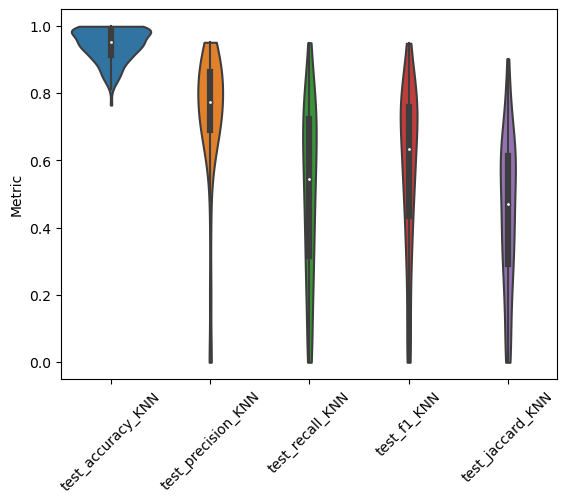

In [78]:
# Alright Let's take a look at these metrics and see what to work with...

sns.violinplot(data = bit_df.loc[:,bit_df.columns.str.contains('test_')], cut = 0); # Drop off the true positives for now
plt.ylabel('Metric');
plt.xticks(rotation = 45);



In [79]:
# Add the total number of molecules with that MACCS key to the bit_df

bit_df.loc[:,'Num_Molecules'] = df_gas.loc[:,MKfp[0]:MKfp[1]].sum(axis = 0).astype(int).tolist()



It looks like with the top and bottom we generally are better at predicting features when more of our dataset has those features.  Should generate a scatter plot and correlation between number of molecules with that feature and the recall score on KNN.

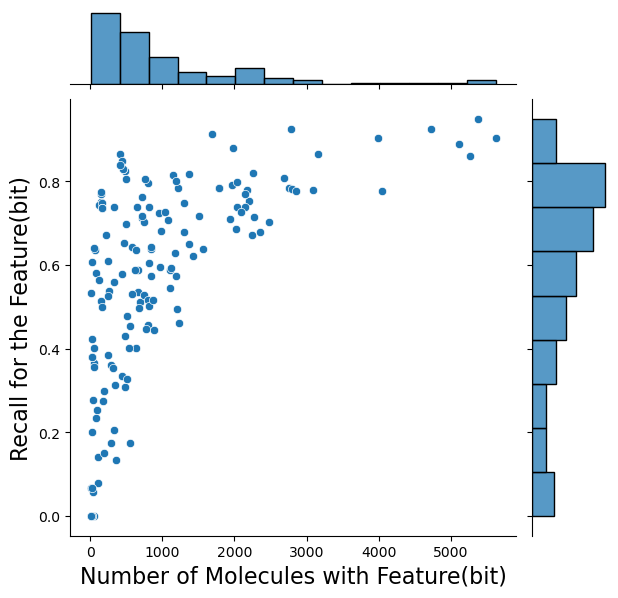

In [80]:
# Note in the plot below the recall certainly appears to be correlated to the
# number of molecules that have that feature.

ax = sns.jointplot(x=bit_df.loc[:,'Num_Molecules'], 
              y=bit_df.loc[:,'test_f1_KNN'].to_numpy().astype(float)
              )

ax.set_axis_labels('Number of Molecules with Feature(bit)', 'Recall for the Feature(bit)', fontsize = 16)



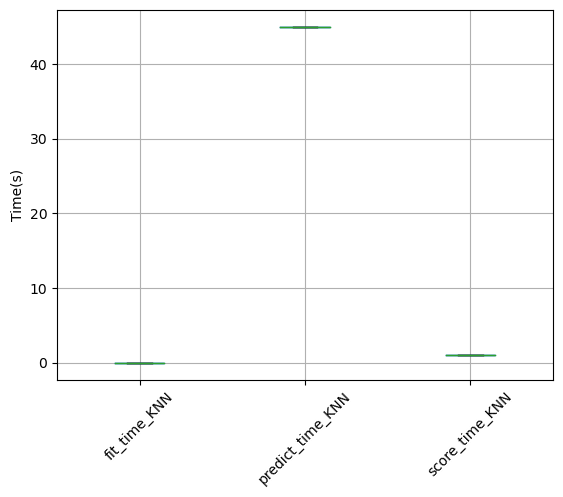

In [81]:
# Alright let's take a look at the times - most of the time is in predicting the KNN model

model_df.astype(int).boxplot()
plt.ylabel('Time(s)');
plt.xticks(rotation = 45);


In [82]:
# Alright giving this a shot with a SVM --> SVC
# Going to fit this with the MultiOutputClassifier wrapper around the SVC classifier
# Going to start out without adding PCA in the pipeline and consider adding back later

test_accuracy_SVC = np.zeros((y_train.shape[1],5))
test_precision_SVC = np.zeros((y_train.shape[1],5))
test_recall_SVC = np.zeros((y_train.shape[1],5))
test_f1_SVC = np.zeros((y_train.shape[1],5))
TP_SVC_test = np.zeros((y_train.shape[1],5))
test_jaccard_SVC = np.zeros((y_train.shape[1],5))

for i, (train_index, test_index) in enumerate(kf.split(gasmat_pca)):
    print('Working on Fold:',i,'Model Fitting.............',end='\r')
    clf = MultiOutputClassifier(svm.SVC())
    start = time.time()
    clf.fit(gasmat_pca[train_index,:],y_train[train_index,:])
    end = time.time()
    model_df.loc[i,'fit_time_SVC'] = end - start
    
    print('Working on Fold:',i,'Predicting.............',end='\r')
    start = time.time()
    y_hat = clf.predict(gasmat_pca[test_index,:])
    end = time.time()
    model_df.loc[i,'predict_time_SVC'] = end - start

    print('Working on Fold:',i,'Scoring.............',end='\r')
    start = time.time()
    test_accuracy_SVC[:,i], test_precision_SVC[:,i], test_recall_SVC[:,i], test_f1_SVC[:,i], TP_SVC_test[:,i], test_jaccard_SVC[:,i] = score_func(y_train[test_index,:],y_hat)
    end = time.time()
    model_df.loc[i,'score_time_SVC'] = end - start
       
    
bit_df.loc[:,'test_accuracy_SVC'] = np.mean(test_accuracy_SVC, axis = 1)
bit_df.loc[:,'test_precision_SVC'] = np.mean(test_precision_SVC, axis = 1)
bit_df.loc[:,'test_recall_SVC'] = np.mean(test_recall_SVC, axis = 1)
bit_df.loc[:,'test_f1_SVC'] = np.mean(test_f1_SVC, axis = 1)
bit_df.loc[:,'TP_SVC_test'] = np.sum(TP_SVC_test == 0, axis = 1) #sum up 0 value true pos
bit_df.loc[:,'test_jaccard_SVC'] = np.mean(test_jaccard_SVC, axis = 1)

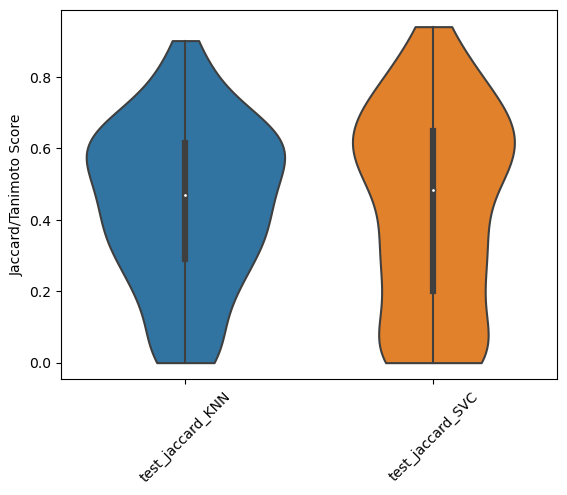

In [83]:
# Alright Let's take a look at these metrics and see what to work with...

sns.violinplot(data = bit_df.loc[:,bit_df.columns.str.contains('jaccard')], cut = 0); # Drop off the true positives for now
plt.ylabel('Jaccard/Tanimoto Score');
plt.xticks(rotation = 45);

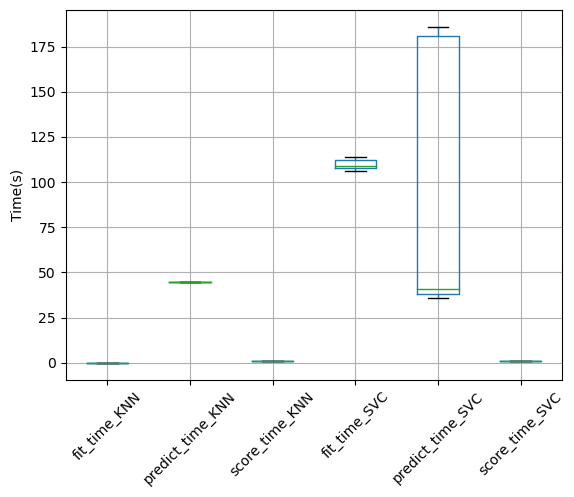

In [84]:
# Alright let's take a look at the times - most of the time is in predicting the KNN model

model_df.astype(int).boxplot()
plt.ylabel('Time(s)');
plt.xticks(rotation = 45);

In [85]:
# Alright giving this a shot with Naive Bayes
# Going to fit this with the MultiOutputClassifier wrapper around the NB classifier
# Going to start out without adding PCA in the pipeline and consider adding back later

test_accuracy_NB = np.zeros((y_train.shape[1],5))
test_precision_NB = np.zeros((y_train.shape[1],5))
test_recall_NB = np.zeros((y_train.shape[1],5))
test_f1_NB = np.zeros((y_train.shape[1],5))
TP_NB_test = np.zeros((y_train.shape[1],5))
test_jaccard_NB = np.zeros((y_train.shape[1],5))

for i, (train_index, test_index) in enumerate(kf.split(gasmat_pca)):
    print('Working on Fold:',i,'Model Fitting.............',end='\r')
    clf = MultiOutputClassifier(GaussianNB())
    start = time.time()
    clf.fit(gasmat_pca[train_index,:],y_train[train_index,:])
    end = time.time()
    model_df.loc[i,'fit_time_NB'] = end - start
    
    print('Working on Fold:',i,'Predicting.............',end='\r')
    start = time.time()
    y_hat = clf.predict(gasmat_pca[test_index,:])
    end = time.time()
    model_df.loc[i,'predict_time_NB'] = end - start

    print('Working on Fold:',i,'Scoring.............',end='\r')
    start = time.time()
    test_accuracy_NB[:,i], test_precision_NB[:,i], test_recall_NB[:,i], test_f1_NB[:,i], TP_NB_test[:,i], test_jaccard_NB[:,i] = score_func(y_train[test_index,:],y_hat)
    end = time.time()
    model_df.loc[i,'score_time_NB'] = end - start
       
    
bit_df.loc[:,'test_accuracy_NB'] = np.mean(test_accuracy_NB, axis = 1)
bit_df.loc[:,'test_precision_NB'] = np.mean(test_precision_NB, axis = 1)
bit_df.loc[:,'test_recall_NB'] = np.mean(test_recall_NB, axis = 1)
bit_df.loc[:,'test_f1_NB'] = np.mean(test_f1_NB, axis = 1)
bit_df.loc[:,'TP_NB_test'] = np.sum(TP_NB_test == 0, axis = 1) #sum up 0 value true pos
bit_df.loc[:,'test_jaccard_NB'] = np.mean(test_jaccard_NB, axis = 1)

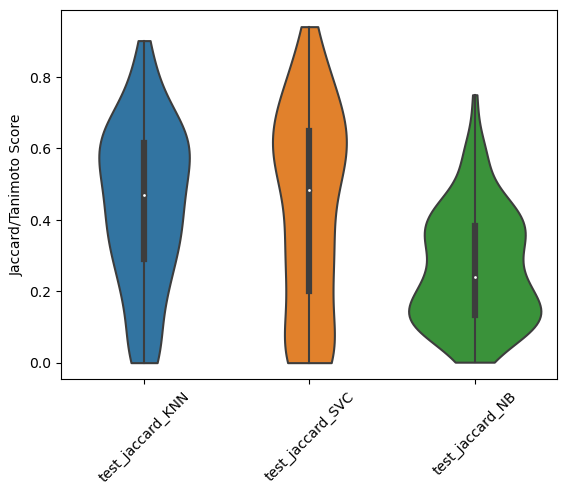

In [86]:
# Alright Let's take a look at these metrics and see what to work with...

sns.violinplot(data = bit_df.loc[:,bit_df.columns.str.contains('jaccard')], cut = 0); # Drop off the true positives for now
plt.ylabel('Jaccard/Tanimoto Score');
plt.xticks(rotation = 45);

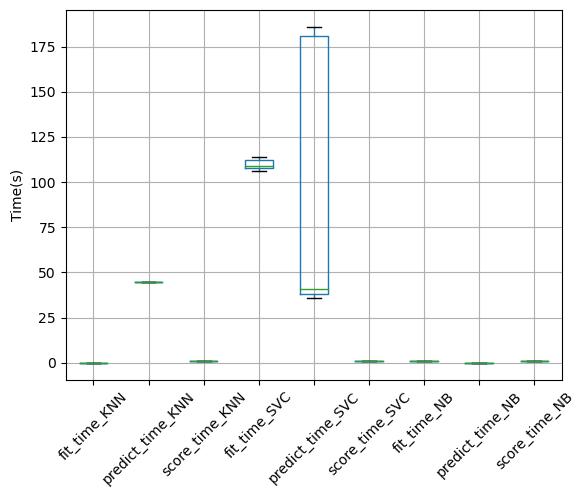

In [87]:
# Alright let's take a look at the times - most of the time is in predicting the KNN model

model_df.astype(int).boxplot()
plt.ylabel('Time(s)');
plt.xticks(rotation = 45);

In [88]:
# Alright giving this a shot with DecisionTrees (DT)
# Going to fit this with the MultiOutputClassifier wrapper around the DT classifier
# Going to start out without adding PCA in the pipeline and consider adding back later

test_accuracy_DT = np.zeros((y_train.shape[1],5))
test_precision_DT = np.zeros((y_train.shape[1],5))
test_recall_DT = np.zeros((y_train.shape[1],5))
test_f1_DT = np.zeros((y_train.shape[1],5))
TP_DT_test = np.zeros((y_train.shape[1],5))
test_jaccard_DT = np.zeros((y_train.shape[1],5))

for i, (train_index, test_index) in enumerate(kf.split(gasmat_pca)):
    print('Working on Fold:',i,'Model Fitting.............',end='\r')
    clf = MultiOutputClassifier(DecisionTreeClassifier())
    start = time.time()
    clf.fit(gasmat_pca[train_index,:],y_train[train_index,:])
    end = time.time()
    model_df.loc[i,'fit_time_DT'] = end - start
    
    print('Working on Fold:',i,'Predicting.............',end='\r')
    start = time.time()
    y_hat = clf.predict(gasmat_pca[test_index,:])
    end = time.time()
    model_df.loc[i,'predict_time_DT'] = end - start

    print('Working on Fold:',i,'Scoring.............',end='\r')
    start = time.time()
    test_accuracy_DT[:,i], test_precision_DT[:,i], test_recall_DT[:,i], test_f1_DT[:,i], TP_DT_test[:,i], test_jaccard_DT[:,i] = score_func(y_train[test_index,:],y_hat)
    end = time.time()
    model_df.loc[i,'score_time_DT'] = end - start
       
    
bit_df.loc[:,'test_accuracy_DT'] = np.mean(test_accuracy_DT, axis = 1)
bit_df.loc[:,'test_precision_DT'] = np.mean(test_precision_DT, axis = 1)
bit_df.loc[:,'test_recall_DT'] = np.mean(test_recall_DT, axis = 1)
bit_df.loc[:,'test_f1_DT'] = np.mean(test_f1_DT, axis = 1)
bit_df.loc[:,'TP_DT_test'] = np.sum(TP_DT_test == 0, axis = 1) #sum up 0 value true pos
bit_df.loc[:,'test_jaccard_DT'] = np.mean(test_jaccard_DT, axis = 1)

In [89]:
# Alright giving this a shot with LogisticRegression (LR)
# Going to fit this with the MultiOutputClassifier wrapper around the LR classifier
# Going to start out without adding PCA in the pipeline and consider adding back later

test_accuracy_LR = np.zeros((y_train.shape[1],5))
test_precision_LR = np.zeros((y_train.shape[1],5))
test_recall_LR = np.zeros((y_train.shape[1],5))
test_f1_LR = np.zeros((y_train.shape[1],5))
TP_LR_test = np.zeros((y_train.shape[1],5))
test_jaccard_LR = np.zeros((y_train.shape[1],5))

for i, (train_index, test_index) in enumerate(kf.split(gasmat_pca)):
    print('Working on Fold:',i,'Model Fitting.............',end='\r')
    clf = MultiOutputClassifier(LogisticRegression(max_iter=5000))
    start = time.time()
    clf.fit(gasmat_pca[train_index,:],y_train[train_index,:])
    end = time.time()
    model_df.loc[i,'fit_time_LR'] = end - start
    
    print('Working on Fold:',i,'Predicting.............',end='\r')
    start = time.time()
    y_hat = clf.predict(gasmat_pca[test_index,:])
    end = time.time()
    model_df.loc[i,'predict_time_LR'] = end - start

    print('Working on Fold:',i,'Scoring.............',end='\r')
    start = time.time()
    test_accuracy_LR[:,i], test_precision_LR[:,i], test_recall_LR[:,i], test_f1_LR[:,i], TP_LR_test[:,i], test_jaccard_LR[:,i] = score_func(y_train[test_index,:],y_hat)
    end = time.time()
    model_df.loc[i,'score_time_LR'] = end - start
       
    
bit_df.loc[:,'test_accuracy_LR'] = np.mean(test_accuracy_LR, axis = 1)
bit_df.loc[:,'test_precision_LR'] = np.mean(test_precision_LR, axis = 1)
bit_df.loc[:,'test_recall_LR'] = np.mean(test_recall_LR, axis = 1)
bit_df.loc[:,'test_f1_LR'] = np.mean(test_f1_LR, axis = 1)
bit_df.loc[:,'TP_LR_test'] = np.sum(TP_LR_test == 0, axis = 1) #sum up 0 value true pos
bit_df.loc[:,'test_jaccard_LR'] = np.mean(test_jaccard_LR, axis = 1)

In [90]:
# Alright giving this a shot with Random Forest (RF)
# Going to fit this with the MultiOutputClassifier wrapper around the RF classifier
# Going to start out without adding PCA in the pipeline and consider adding back later

test_accuracy_RF = np.zeros((y_train.shape[1],5))
test_precision_RF = np.zeros((y_train.shape[1],5))
test_recall_RF = np.zeros((y_train.shape[1],5))
test_f1_RF = np.zeros((y_train.shape[1],5))
TP_RF_test = np.zeros((y_train.shape[1],5))
test_jaccard_RF = np.zeros((y_train.shape[1],5))

for i, (train_index, test_index) in enumerate(kf.split(gasmat_pca)):
    print('Working on Fold:',i,'Model Fitting.............',end='\r')
    clf = MultiOutputClassifier(RandomForestClassifier())
    start = time.time()
    clf.fit(gasmat_pca[train_index,:],y_train[train_index,:])
    end = time.time()
    model_df.loc[i,'fit_time_RF'] = end - start
    
    print('Working on Fold:',i,'Predicting.............',end='\r')
    start = time.time()
    y_hat = clf.predict(gasmat_pca[test_index,:])
    end = time.time()
    model_df.loc[i,'predict_time_RF'] = end - start

    print('Working on Fold:',i,'Scoring.............',end='\r')
    start = time.time()
    test_accuracy_RF[:,i], test_precision_RF[:,i], test_recall_RF[:,i], test_f1_RF[:,i], TP_RF_test[:,i], test_jaccard_RF[:,i] = score_func(y_train[test_index,:],y_hat)
    end = time.time()
    model_df.loc[i,'score_time_RF'] = end - start
       
    
bit_df.loc[:,'test_accuracy_RF'] = np.mean(test_accuracy_RF, axis = 1)
bit_df.loc[:,'test_precision_RF'] = np.mean(test_precision_RF, axis = 1)
bit_df.loc[:,'test_recall_RF'] = np.mean(test_recall_RF, axis = 1)
bit_df.loc[:,'test_f1_RF'] = np.mean(test_f1_RF, axis = 1)
bit_df.loc[:,'TP_RF_test'] = np.sum(TP_RF_test == 0, axis = 1) #sum up 0 value true pos
bit_df.loc[:,'test_jaccard_RF'] = np.mean(test_jaccard_RF, axis = 1)

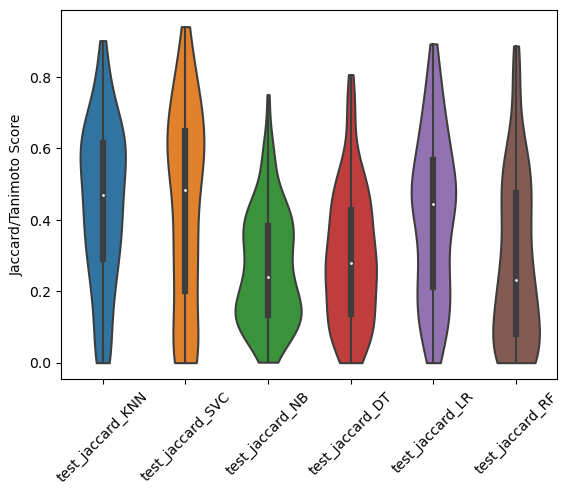

In [91]:
# Alright Let's take a look at these metrics and see what to work with...

sns.violinplot(data = bit_df.loc[:,bit_df.columns.str.contains('jaccard')], cut = 0); # Drop off the true positives for now
plt.ylabel('Jaccard/Tanimoto Score');
plt.xticks(rotation = 45);

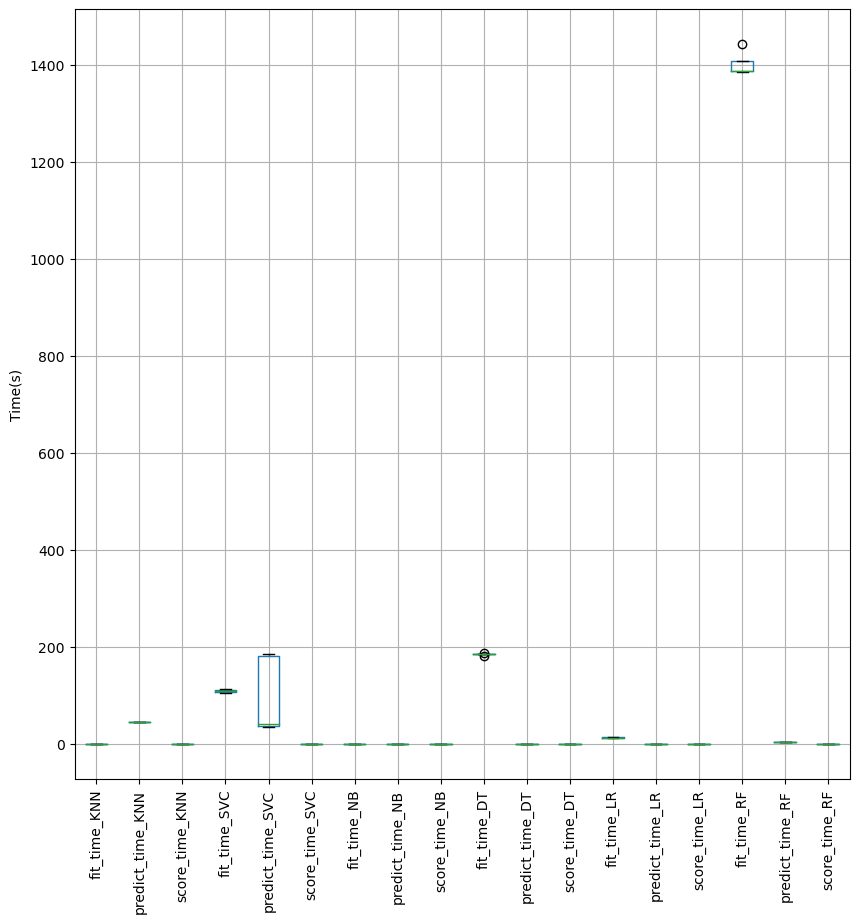

In [92]:
# Alright let's take a look at the times - most of the time is in predicting the KNN model
plt.figure(figsize = (10,10))
model_df.astype(int).boxplot()
plt.ylabel('Time(s)');
plt.xticks(rotation = 90);

In [93]:
# Alright giving this a shot with Multi Layer Perceptron Neural Network (MLP)
# Going to fit this with the MultiOutputClassifier wrapper around the MLP classifier
# Going to start out without adding PCA in the pipeline and consider adding back later

test_accuracy_MLP = np.zeros((y_train.shape[1],5))
test_precision_MLP = np.zeros((y_train.shape[1],5))
test_recall_MLP = np.zeros((y_train.shape[1],5))
test_f1_MLP = np.zeros((y_train.shape[1],5))
TP_MLP_test = np.zeros((y_train.shape[1],5))
test_jaccard_MLP = np.zeros((y_train.shape[1],5))

for i, (train_index, test_index) in enumerate(kf.split(gasmat_pca)):
    print('Working on Fold:',i,'Model Fitting.............',end='\r')
    clf = MultiOutputClassifier(RandomForestClassifier())
    start = time.time()
    clf.fit(gasmat_pca[train_index,:],y_train[train_index,:])
    end = time.time()
    model_df.loc[i,'fit_time_MLP'] = end - start
    
    print('Working on Fold:',i,'Predicting.............',end='\r')
    start = time.time()
    y_hat = clf.predict(gasmat_pca[test_index,:])
    end = time.time()
    model_df.loc[i,'predict_time_MLP'] = end - start

    print('Working on Fold:',i,'Scoring.............',end='\r')
    start = time.time()
    test_accuracy_MLP[:,i], test_precision_MLP[:,i], test_recall_MLP[:,i], test_f1_MLP[:,i], TP_MLP_test[:,i], test_jaccard_MLP[:,i] = score_func(y_train[test_index,:],y_hat)
    end = time.time()
    model_df.loc[i,'score_time_MLP'] = end - start
       
    
bit_df.loc[:,'test_accuracy_MLP'] = np.mean(test_accuracy_MLP, axis = 1)
bit_df.loc[:,'test_precision_MLP'] = np.mean(test_precision_MLP, axis = 1)
bit_df.loc[:,'test_recall_MLP'] = np.mean(test_recall_MLP, axis = 1)
bit_df.loc[:,'test_f1_MLP'] = np.mean(test_f1_MLP, axis = 1)
bit_df.loc[:,'TP_MLP_test'] = np.sum(TP_MLP_test == 0, axis = 1) #sum up 0 value true pos
bit_df.loc[:,'test_jaccard_RF'] = np.mean(test_jaccard_RF, axis = 1)

In [94]:
# Alright giving this a shot with Adaboost (AB)
# Going to fit this with the MultiOutputClassifier wrapper around the AB classifier
# Going to start out without adding PCA in the pipeline and consider adding back later

test_accuracy_AB = np.zeros((y_train.shape[1],5))
test_precision_AB = np.zeros((y_train.shape[1],5))
test_recall_AB = np.zeros((y_train.shape[1],5))
test_f1_AB = np.zeros((y_train.shape[1],5))
TP_AB_test = np.zeros((y_train.shape[1],5))
test_jaccard_AB = np.zeros((y_train.shape[1],5))

for i, (train_index, test_index) in enumerate(kf.split(gasmat_pca)):
    print('Working on Fold:',i,'Model Fitting.............',end='\r')
    clf = MultiOutputClassifier(AdaBoostClassifier())
    start = time.time()
    clf.fit(gasmat_pca[train_index,:],y_train[train_index,:])
    end = time.time()
    model_df.loc[i,'fit_time_AB'] = end - start
    
    print('Working on Fold:',i,'Predicting.............',end='\r')
    start = time.time()
    y_hat = clf.predict(gasmat_pca[test_index,:])
    end = time.time()
    model_df.loc[i,'predict_time_AB'] = end - start

    print('Working on Fold:',i,'Scoring.............',end='\r')
    start = time.time()
    test_accuracy_AB[:,i], test_precision_AB[:,i], test_recall_AB[:,i], test_f1_AB[:,i], TP_AB_test[:,i], test_jaccard_AB[:,i] = score_func(y_train[test_index,:],y_hat)
    end = time.time()
    model_df.loc[i,'score_time_AB'] = end - start
       
    
bit_df.loc[:,'test_accuracy_AB'] = np.mean(test_accuracy_AB, axis = 1)
bit_df.loc[:,'test_precision_AB'] = np.mean(test_precision_AB, axis = 1)
bit_df.loc[:,'test_recall_AB'] = np.mean(test_recall_AB, axis = 1)
bit_df.loc[:,'test_f1_AB'] = np.mean(test_f1_AB, axis = 1)
bit_df.loc[:,'TP_AB_test'] = np.sum(TP_AB_test == 0, axis = 1) #sum up 0 value true pos
bit_df.loc[:,'test_jaccard_AB'] = np.mean(test_jaccard_AB, axis = 1)

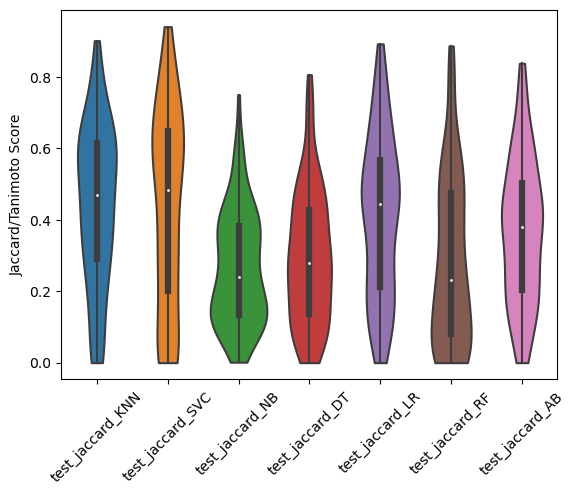

In [95]:
# Alright Let's take a look at these metrics and see what to work with...

sns.violinplot(data = bit_df.loc[:,bit_df.columns.str.contains('jaccard')], cut = 0); # Drop off the true positives for now
plt.ylabel('Jaccard/Tanimoto Score');
plt.xticks(rotation = 45);

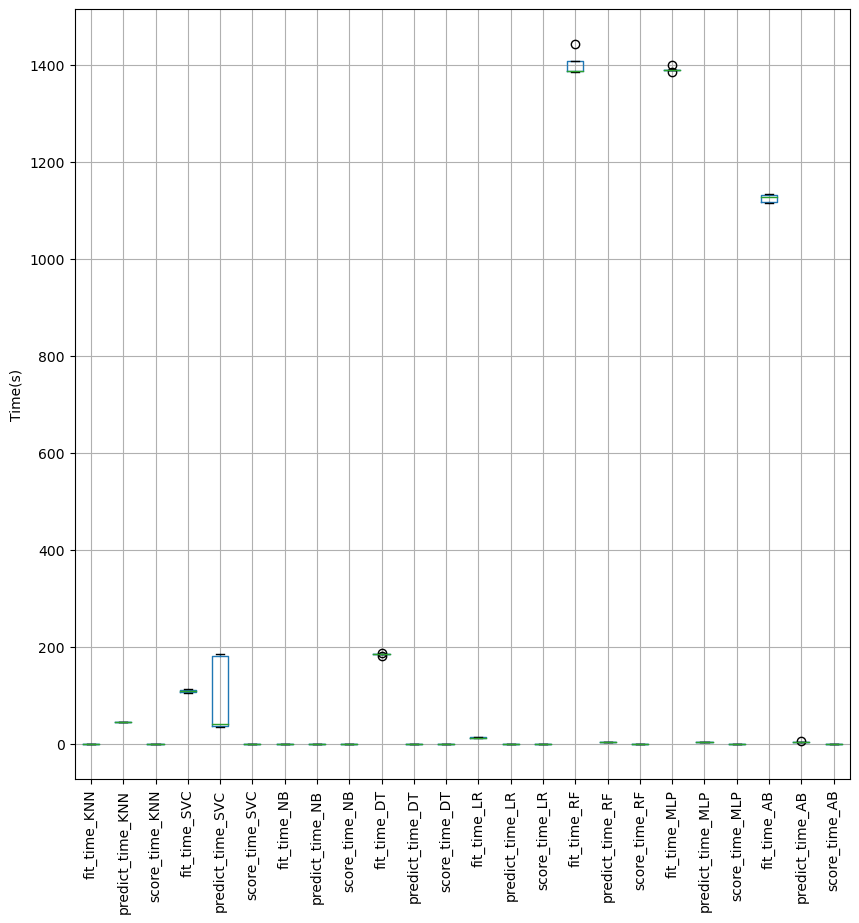

In [96]:
# Alright let's take a look at the times - most of the time is in predicting the KNN model
plt.figure(figsize = (10,10))
model_df.astype(int).boxplot()
plt.ylabel('Time(s)');
plt.xticks(rotation = 90);

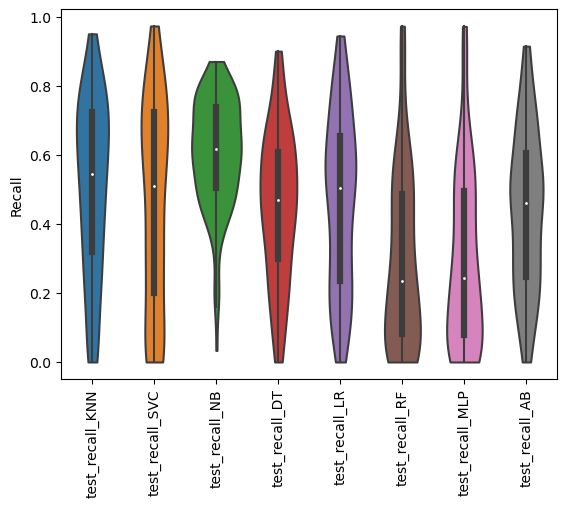

In [97]:
# Alright Let's take a look at these metrics and see what to work with...

sns.violinplot(data = bit_df.loc[:,bit_df.columns.str.contains('recall')], cut = 0); # Drop off the true positives for now
plt.ylabel('Recall');
plt.xticks(rotation = 90);

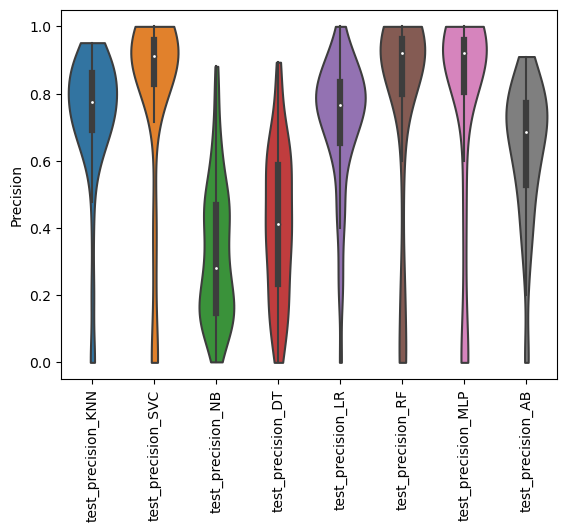

In [98]:
# Alright Let's take a look at these metrics and see what to work with...

sns.violinplot(data = bit_df.loc[:,bit_df.columns.str.contains('precision')], cut = 0); # Drop off the true positives for now
plt.ylabel('Precision');
plt.xticks(rotation = 90);

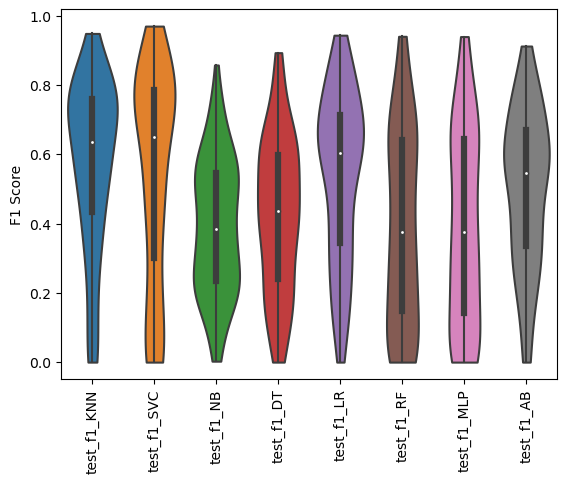

In [99]:
# Alright Let's take a look at these metrics and see what to work with...

sns.violinplot(data = bit_df.loc[:,bit_df.columns.str.contains('f1')], cut = 0); # Drop off the true positives for now
plt.ylabel('F1 Score');
plt.xticks(rotation = 90);

In [100]:
# Saving this dataframe for use later without rerunning the fitting

bit_df.to_csv('bit_df.csv')

# Metric Evaluation Prior to Model Optimization

We have some initial modeling from above - and it appears that jaccard_score will be a good way to go to evaluate models.  Based on the jaccard score the following models would get carried forward for optimization: K-Nearest Neighbors, Support Vector Machine Classifier, Logistic Regression, and Adaboost.

I want to take a moment prior to optimizaing the models and evaluate what metric we need in order to achieve our goal.  Our final goal is to be able to identify fetures which are predictable from the IR spectra and to be able to identify molecules from their FTIR spectra (using the features).  For both of those related goals - we need to set a cutoff for recall, precision, or f1-score in order to ensure success and give an easy cut off for selecting features.  In this section I will do that.

In [101]:
# Simple function to generate fingerprints given a bit length and a number of ones

def fpgen(bits,ones):
    fp = np.zeros(bits)
    fp[np.random.choice(bits,ones, replace = False)] = 1
    
    return fp

In [102]:
# Simple function to generate a y_pred to give a particular jaccard index with y
# The jaccard index is the same as the tanimoto index used to compare chemical fingerprints
# https://en.wikipedia.org/wiki/Jaccard_index
    
def fp_jaccard(fp,jaccard):
    fp_pred = np.zeros(fp.shape)
    APbool = fp == 1
    APidx = np.arange(fp.shape[0])[APbool] # get index of actual positives
    ANidx = np.arange(fp.shape[0])[~APbool] #get index of actual negatives
    AP = APbool.sum() # actual positives
    MP = round(AP*jaccard) # Minimum of true positives as determined by jaccard
    TP = np.random.choice(list(range(MP,AP+1)),1)[0]
    FP = round(TP/jaccard) - AP
    if FP < 0:
        FP = 0
    #print(AP, MP, TP, FP) #Had this in here for troubleshooting
    fp_pred[APidx[np.random.choice(AP,TP, replace = False)]] = 1 # select AP, then randomly select TP
    fp_pred[ANidx[np.random.choice((~APbool).sum(),FP, replace = False)]] = 1 # select AN, then randomly select FP
    
    return fp_pred

In [103]:
# Testing my jaccard/tanimoto simulator

jaccard = 0.76
bits = 1000
ones = 500

y = fpgen(bits,ones)
y_pred = fp_jaccard(y,jaccard)
print('I wanted a jaccard index of:',jaccard,'and I get:',metrics.jaccard_score(y,y_pred))



I wanted a jaccard index of: 0.76 and I get: 0.7602131438721137


In [104]:
jaccard_list = [0.7,0.8,0.9,0.95,0.99]
n = 10

jac_comp = np.zeros((y_train.shape[0],n,len(jaccard_list)))
jac_value = np.zeros((y_train.shape[0],n,len(jaccard_list)))
j = 0
for jaccard in jaccard_list:
    print('Working on feature jaccard index =',jaccard_list[j],'...............',end='\r')
    for i in range(n):
        # Simulating features with difference jaccard scores with the fp_jaccard function above
        print('Working on feature jaccard index =',jaccard_list[j],'Rep:',i,'Sim','...............',end='\r')
        y_pred = np.zeros(y_train.shape)
        for feat in range(y_train.shape[1]):
            y_pred[:,feat] = fp_jaccard(y_train[:,feat],jaccard)
        print('Working on feature jaccard index =',jaccard_list[j],'Rep:',i,'Check','...............',end='\r')
        for molecule in range(y_train.shape[0]):
            print('Working on feature jaccard index =',jaccard_list[j],'Rep:',i,'Check','Mol:',molecule,'...............',end='\r')
            # First use repeat with order = Fortran style to make a 1D array of enough values to fill a matrix
            # of size y_train.  Then reshape the 1D array to the size of y_train.  Find the intersection between the
            # new matrix of all one predicted molecule bit string and the actual matrix of molecule bit strings (y_train).
            # Lastly, sum along the rows in order to sum up the union for each molecule compared with this predicted
            # bit string.
            intersection = (np.reshape(np.repeat(y_pred[molecule,:],
                                                 y_train.shape[0]),
                                                 y_train.shape,
                                                 order = 'F').astype(int) & y_train.astype(int)).sum(axis = 1)
            # Perform the same operation as above, but do it with the or function to get the union of the two matrices
            union = (np.reshape(np.repeat(y_pred[molecule,:],
                                          y_train.shape[0]),
                                          y_train.shape,
                                          order = 'F').astype(int) | y_train.astype(int)).sum(axis = 1)
            # Check to see if the maximum of intersection/union is the correct molecule index
            # if yes store 1 if no store 0 in jac_comp.  Regardless, store the jaccard index in jac_value
            # I was using np.argmax() here - but had to switch because it only finds first max.
            # NOTE THIS MEANS WITH THE FEATURES I HAVE NOW THE MOLECULES ARE NOT UNIQUE
            maxvalind = np.argwhere(intersection/union == np.amax(intersection/union))
            if molecule in maxvalind:
                jac_comp[molecule,i,j] = 1
                jac_value[molecule,i,j] = (intersection[molecule]/union[molecule]).max()
            else:
                jac_comp[molecule,i,j] = 0
                jac_value[molecule,i,j] = (intersection[molecule]/union[molecule]).max()
    j = j + 1
                           



In [105]:
# Reshape the array to format for a datafram and set the index to the df_gas index for the training
# set

# Set column names
col = []

for j in range(jac_comp.shape[2]):
    for i in range(jac_comp.shape[1]):
        col.append('Jac_'+str(jaccard_list[j])+'_Rep'+str(i))

# reshape 3D array to 2d and store in dataframe
sim_df = pd.DataFrame(np.reshape(jac_comp,(jac_comp.shape[0],jac_comp.shape[1]*jac_comp.shape[2]), order = 'F'),
             index = df_gas.loc[indices_train,:].index, columns = col)

simsum_df = pd.DataFrame(index = list(range(len(jac_comp[1]))))
for jaccard in jaccard_list:
    sim_df.loc[:,'Mean_'+str(jaccard)] = sim_df.loc[:,sim_df.columns.str.contains('Jac_'+str(jaccard)+'_Rep')].mean(axis = 1)
    simsum_df.loc[:,'Jac_'+str(jaccard)] = sim_df.loc[:,sim_df.columns.str.contains('Jac_'+str(jaccard)+'_Rep')].sum().tolist()


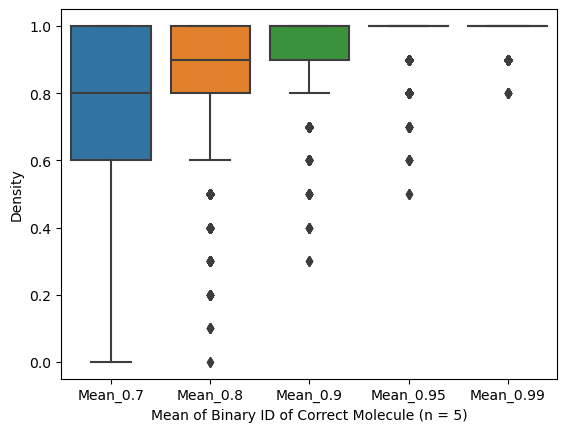

In [106]:
sns.boxplot(data = sim_df.loc[:,sim_df.columns.str.contains('Mean')])
plt.xlabel('Mean of Binary ID of Correct Molecule (n = 5)')
plt.ylabel('Density')
plt.show()

<AxesSubplot:>

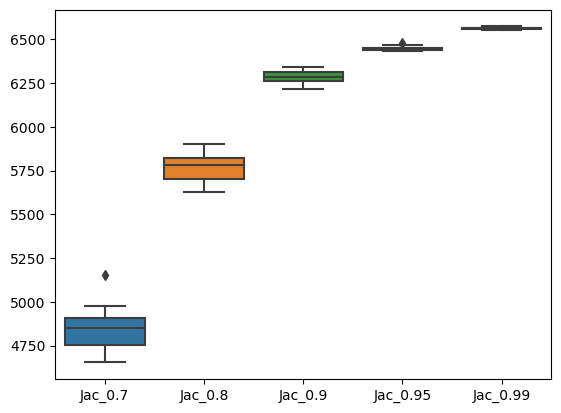

In [107]:
sns.boxplot(data = simsum_df)

<AxesSubplot:>

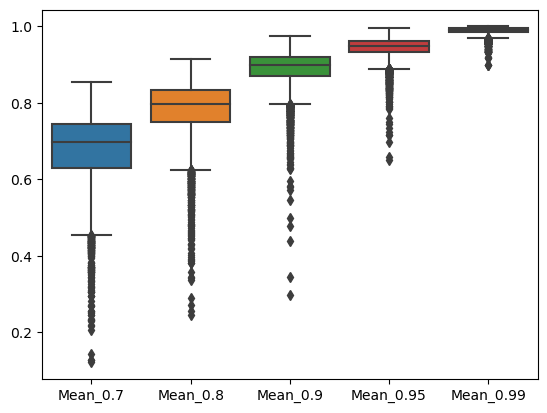

In [108]:
col = []

for j in range(jac_comp.shape[2]):
    for i in range(jac_comp.shape[1]):
        col.append('Jac_'+str(jaccard_list[j])+'_Rep'+str(i))

jdf = pd.DataFrame(np.reshape(jac_value,(jac_value.shape[0],jac_value.shape[1]*jac_value.shape[2]),order = 'F'), columns = col)

simsum_jdf = pd.DataFrame(index = list(range(len(jac_comp[1]))))
for jaccard in jaccard_list:
    jdf.loc[:,'Mean_'+str(jaccard)] = jdf.loc[:,jdf.columns.str.contains('Jac_'+str(jaccard)+'_Rep')].mean(axis = 1)
    simsum_jdf.loc[:,'Jac_'+str(jaccard)] = jdf.loc[:,jdf.columns.str.contains('Jac_'+str(jaccard)+'_Rep')].mean().tolist()

sns.boxplot(data = jdf.loc[:,jdf.columns.str.contains('Mean')])

Text(0.5, 0, 'Number of Features Per Molecule')

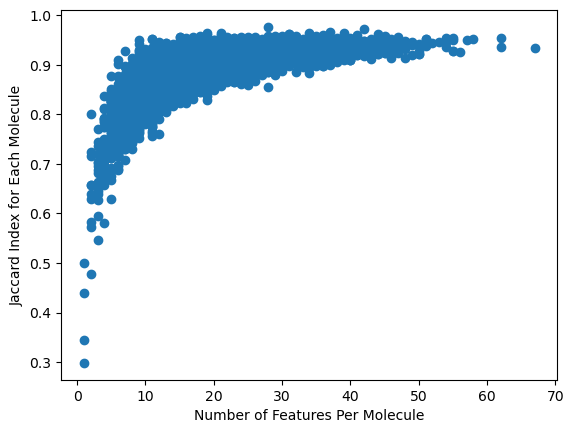

In [114]:
df_gas.loc[:,'features'] = df_gas.loc[:,MKfp[0]:MKfp[1]].sum(axis = 1)

df_gas.loc[:]
plt.scatter(df_gas.loc[indices_train,'features'].to_list(),jdf.loc[:,'Mean_0.9'])
plt.ylabel('Jaccard Index for Each Molecule')
plt.xlabel('Number of Features Per Molecule')

In [115]:
# Outputting these in case I need to come back and re-evaluate

jdf.to_csv('jdf.csv')
simsum_jdf.to_csv('simsum_jdf.csv')
sim_df.to_csv('sim_df.csv')
simsum_df.to_csv('simsum_df.csv')

From reviewing the above information I'd say the following:

The feature jaccard index of 0.9 seems to be a good compromise for filtering down features.  At 0.9 about 50% of the molecules in the database have a jaccard index of near 1.0 (max) - see first plot in this section.

Skipping down to the last plot of the simulated Jaccard Index for each molecule (mean over 10 simulations), we can see that there is a steep drop off in Jaccard index for molecules with less features than 10.  We are likely going to need to drop these molecules from our search or add more features to the database (in addition to MACCS keys).

Lastly, in the second from last plot the meadian Jaccard index we're getting for each molecule is very close to the feature Jaccard index (i.e. set Jaccard index for features to 0.7 and get 0.7 for the molecule).  The outliers in the plot are likely due to the molecules with very few features.

# Final Model Optmization

Going to start from top to bottom with the most promising model first - Support Vector Classifier

In [116]:
# Alright giving this a shot with a SVM --> SVC
# Going to fit this with the MultiOutputClassifier wrapper around the SVC classifier
# Going to start out without adding PCA in the pipeline and consider adding back later

# Set up the score function
def score_func(y,y_pred):
    jaccard_score = np.zeros(y_pred.shape[1])
    
    for i in range(y_pred.shape[1]):
        jaccard_score[i] = metrics.jaccard_score(y[:,i], y_pred[:,i], zero_division = 0)
        if y[:,i].sum() == 0:  # If I catch any 0 True positives I want to set precision and f1_score to 1 if no bits were predicted
            if y_pred[:,i].sum() == 0:
                jaccard_score[i] = 1
    
    return (((jaccard_score > 0.8).sum())/y_pred.shape[1])

# Make Scorer used for grid search
jaccard_cutoff = metrics.make_scorer(score_func)

# Now I need to set up the params
params={ # Will tune degree and gamma depending on which kernel I proceed with next
        'estimator__C': [0.01,0.1,1,10],
        'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

clf = MultiOutputClassifier(svm.SVC())

grid = GridSearchCV(clf, params, cv = 3, scoring = jaccard_cutoff, return_train_score = True, verbose = 2.1)
grid_search = grid.fit(gasmat_pca, y_train)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END estimator__C=0.01, estimator__kernel=linear;, score=(train=0.032, test=0.026) total time= 1.8min
[CV 2/3] END estimator__C=0.01, estimator__kernel=linear;, score=(train=0.026, test=0.019) total time= 1.1min
[CV 3/3] END estimator__C=0.01, estimator__kernel=linear;, score=(train=0.026, test=0.039) total time= 1.2min
[CV 1/3] END estimator__C=0.01, estimator__kernel=poly;, score=(train=0.000, test=0.000) total time= 1.8min
[CV 2/3] END estimator__C=0.01, estimator__kernel=poly;, score=(train=0.000, test=0.000) total time= 1.8min
[CV 3/3] END estimator__C=0.01, estimator__kernel=poly;, score=(train=0.000, test=0.000) total time= 1.8min
[CV 1/3] END estimator__C=0.01, estimator__kernel=rbf;, score=(train=0.000, test=0.000) total time= 2.5min
[CV 2/3] END estimator__C=0.01, estimator__kernel=rbf;, score=(train=0.000, test=0.000) total time= 2.4min
[CV 3/3] END estimator__C=0.01, estimator__kernel=rbf;, score=(train=0.

In [117]:
linear = [x['estimator__kernel'] =='linear' for x in grid_search.cv_results_['params']]
poly = [x['estimator__kernel'] =='poly' for x in grid_search.cv_results_['params']]
rbf = [x['estimator__kernel'] =='rbf' for x in grid_search.cv_results_['params']]
sigmoid = [x['estimator__kernel'] =='sigmoid' for x in grid_search.cv_results_['params']]
C = params['estimator__C']

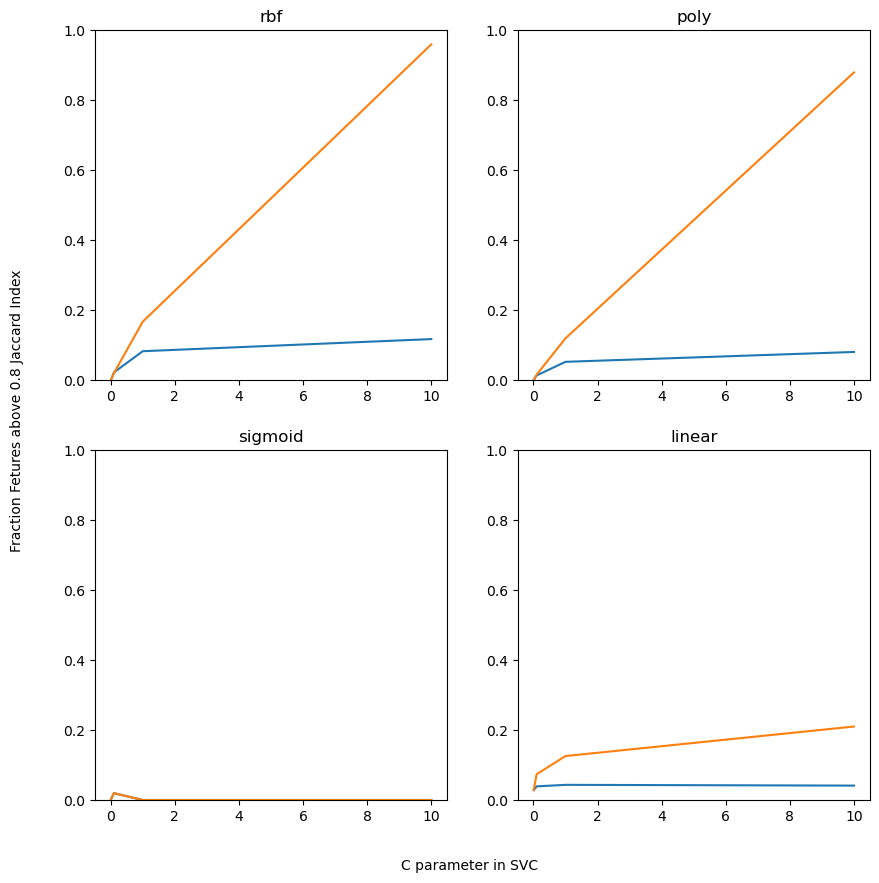

In [118]:
fig = plt.figure(figsize = (10,10))

ax1 = plt.subplot(221)
plt.plot(C,grid_search.cv_results_['mean_test_score'][rbf])
plt.plot(C,grid_search.cv_results_['mean_train_score'][rbf])
ax1.set_ylim([0,1])
ax1.set_title('rbf')
ax4 = plt.subplot(224)
plt.plot(C,grid_search.cv_results_['mean_test_score'][linear])
plt.plot(C,grid_search.cv_results_['mean_train_score'][linear])
ax4.set_ylim([0,1])
ax4.set_title('linear')
ax3 = plt.subplot(223)
plt.plot(C,grid_search.cv_results_['mean_test_score'][sigmoid])
plt.plot(C,grid_search.cv_results_['mean_train_score'][sigmoid])
ax3.set_ylim([0,1])
ax3.set_title('sigmoid')
ax2 = plt.subplot(222)
plt.plot(C,grid_search.cv_results_['mean_test_score'][poly])
plt.plot(C,grid_search.cv_results_['mean_train_score'][poly])
ax2.set_ylim([0,1])
ax2.set_title('poly')

fig.text(0.04, 0.5, 'Fraction Fetures above 0.8 Jaccard Index', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'C parameter in SVC', ha='center')
plt.show()

In [119]:
grid_search.cv_results_

{'mean_fit_time': array([ 67.41224845,  82.79720457,  83.24103189,  78.22800461,
         58.44147817,  73.74646322,  76.79656315,  67.11539745,
        101.89367708,  72.60811027,  70.16452781,  50.98046827,
        467.40858507,  76.46994948,  75.08071049,  44.50359337]),
 'std_fit_time': array([16.81400583,  1.65632226,  1.07640735,  0.61650088,  2.2227333 ,
         0.37671278,  1.53988016,  0.43291846,  1.19423081,  0.60523711,
         1.88239965,  0.83912448, 10.69320026,  0.19933925,  0.09053061,
         0.17883978]),
 'mean_score_time': array([14.22990441, 25.67807094, 65.03684521, 25.58649651, 12.66669512,
        21.28302836, 59.79471294, 20.78696895, 11.59474405, 19.23701374,
        51.58841952, 15.64828054, 11.60708928, 17.78718718, 50.12686459,
        13.46657205]),
 'std_score_time': array([0.07490172, 1.88376792, 0.34027667, 0.20884076, 0.31276689,
        0.31650524, 1.06281853, 0.18594008, 0.03242372, 0.19844714,
        0.37814419, 0.26572545, 0.14597795, 0.022642

In [120]:
# Setting up an appropriate gamma range
# I've been using the default 'scale' setting so gamma = 1/(n_features*X.var())

print("For previous optimization gamma = ",1/(gasmat_pca.shape[1]*gasmat_pca.var()))

For previous optimization gamma =  0.035578602482814296


In [121]:
# Now I need to set up the params
params={ # Will tune degree and gamma depending on which kernel I proceed with next
        'estimator__C': [0.5,1,3,5],
        'estimator__kernel': ['rbf'],
        'estimator__gamma': [0.001, 0.01,'scale', 0.1]
}

clf = MultiOutputClassifier(svm.SVC())

grid = GridSearchCV(clf, params, cv = 3, scoring = jaccard_cutoff, return_train_score = True, verbose = 2.1)
grid_search = grid.fit(gasmat_pca, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END estimator__C=0.5, estimator__gamma=0.001, estimator__kernel=rbf;, score=(train=0.019, test=0.013) total time= 2.1min
[CV 2/3] END estimator__C=0.5, estimator__gamma=0.001, estimator__kernel=rbf;, score=(train=0.019, test=0.019) total time= 2.1min
[CV 3/3] END estimator__C=0.5, estimator__gamma=0.001, estimator__kernel=rbf;, score=(train=0.019, test=0.019) total time= 2.1min
[CV 1/3] END estimator__C=0.5, estimator__gamma=0.01, estimator__kernel=rbf;, score=(train=0.052, test=0.026) total time= 1.9min
[CV 2/3] END estimator__C=0.5, estimator__gamma=0.01, estimator__kernel=rbf;, score=(train=0.052, test=0.019) total time= 1.8min
[CV 3/3] END estimator__C=0.5, estimator__gamma=0.01, estimator__kernel=rbf;, score=(train=0.052, test=0.045) total time= 1.9min
[CV 1/3] END estimator__C=0.5, estimator__gamma=scale, estimator__kernel=rbf;, score=(train=0.084, test=0.071) total time= 2.0min
[CV 2/3] END estimator__C=0.5, e

In [122]:
grid_search.cv_results_

{'mean_fit_time': array([ 72.49106852,  63.76068425,  69.3857433 , 125.49257922,
         70.04007165,  61.52876774,  68.77525854, 128.53639825,
         67.70773594,  61.06918359,  72.84807865, 134.76691651,
         64.66996543,  60.63137984,  72.38866131, 138.57835046]),
 'std_fit_time': array([1.28085516, 0.34480909, 0.39036818, 2.04975438, 1.2331043 ,
        0.44819013, 0.40344245, 2.00238189, 1.28548005, 1.60245635,
        1.93207506, 2.97297622, 0.42947366, 0.75204234, 0.59277891,
        0.63686858]),
 'mean_score_time': array([55.36264992, 47.81299583, 53.99931661, 93.8365643 , 51.67526301,
        45.68403125, 51.46537908, 95.99258836, 47.61926468, 42.7968773 ,
        50.6139528 , 96.0204006 , 48.8102444 , 43.44664534, 50.60185877,
        92.84441598]),
 'std_score_time': array([1.49291469, 0.37935943, 1.84473982, 0.84928347, 0.46877758,
        0.38846872, 0.34571208, 0.71914172, 0.29421134, 0.18159591,
        0.25783544, 1.11926452, 2.04871942, 1.59257078, 0.62410694,


In [123]:
grid_search.cv_results_['params']

[{'estimator__C': 0.5, 'estimator__gamma': 0.001, 'estimator__kernel': 'rbf'},
 {'estimator__C': 0.5, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf'},
 {'estimator__C': 0.5,
  'estimator__gamma': 'scale',
  'estimator__kernel': 'rbf'},
 {'estimator__C': 0.5, 'estimator__gamma': 0.1, 'estimator__kernel': 'rbf'},
 {'estimator__C': 1, 'estimator__gamma': 0.001, 'estimator__kernel': 'rbf'},
 {'estimator__C': 1, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf'},
 {'estimator__C': 1, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'},
 {'estimator__C': 1, 'estimator__gamma': 0.1, 'estimator__kernel': 'rbf'},
 {'estimator__C': 3, 'estimator__gamma': 0.001, 'estimator__kernel': 'rbf'},
 {'estimator__C': 3, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf'},
 {'estimator__C': 3, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'},
 {'estimator__C': 3, 'estimator__gamma': 0.1, 'estimator__kernel': 'rbf'},
 {'estimator__C': 5, 'estimator__gamma': 0.001, 'estimator__kernel'

In [124]:
grid_search.cv_results_['rank_test_score']

array([16, 12,  8, 11, 14, 10,  3,  9, 14,  6,  2,  6, 13,  3,  1,  5])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

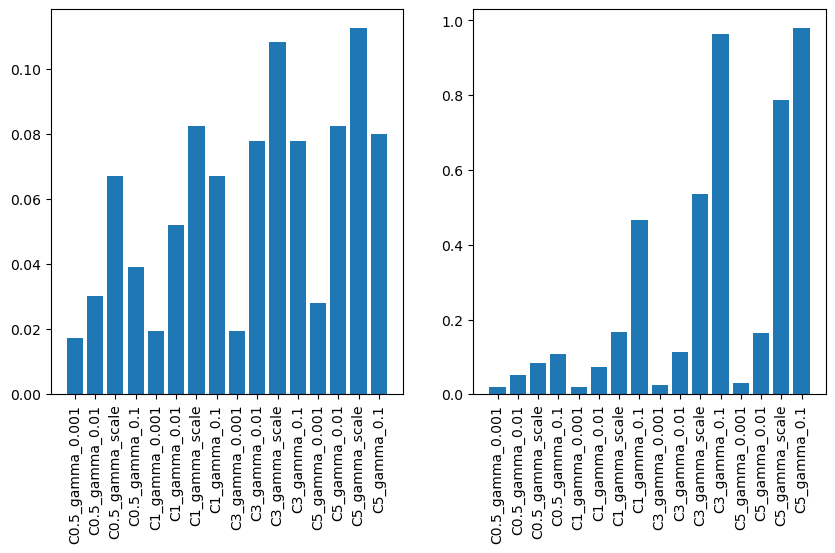

In [125]:
plt.figure(figsize = (10,5))

labels = ['C'+str(x['estimator__C']) + '_gamma_' + str(x['estimator__gamma']) for x in grid_search.cv_results_['params']]
ax1 = plt.subplot(121)
plt.bar(labels,grid_search.cv_results_['mean_test_score'])
plt.xticks(rotation = 90)
ax1 = plt.subplot(122)
plt.bar(labels,grid_search.cv_results_['mean_train_score'])
plt.xticks(rotation = 90)

Text(0, 0.5, 'Fraction Bits with Jaccard Index over 0.8')

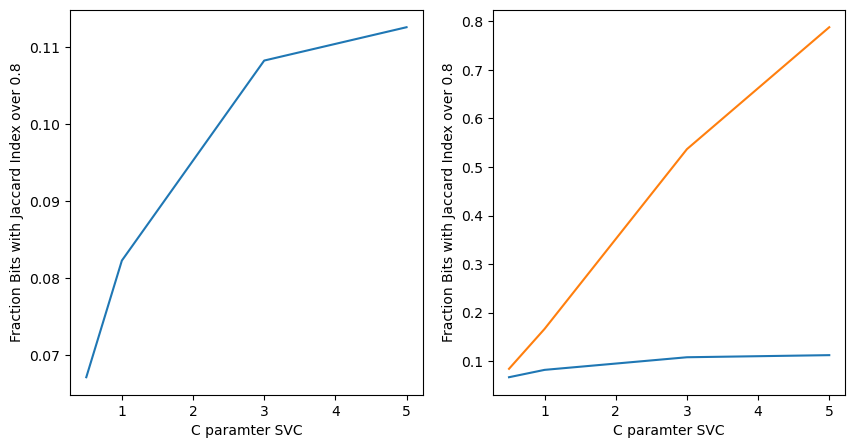

In [126]:
# picking out gamma = 'scale'
gamma_scale = [x['estimator__gamma'] == 'scale' for x in grid_search.cv_results_['params']]
plt.figure(figsize = (10,5))
ax1 = plt.subplot(121)
plt.plot(params['estimator__C'],grid_search.cv_results_['mean_test_score'][gamma_scale])
ax1.set_xlabel('C paramter SVC')
ax1.set_ylabel('Fraction Bits with Jaccard Index over 0.8')
ax2 = plt.subplot(122)
plt.plot(params['estimator__C'],grid_search.cv_results_['mean_test_score'][gamma_scale])
ax1.set_xlabel('C paramter SVC')
ax1.set_ylabel('Fraction Bits with Jaccard Index over 0.8')
plt.plot(params['estimator__C'],grid_search.cv_results_['mean_train_score'][gamma_scale])
ax2.set_xlabel('C paramter SVC')
ax2.set_ylabel('Fraction Bits with Jaccard Index over 0.8')
#ax1 = plt.subplot(122)
#plt.bar(labels,grid_search.cv_results_['mean_train_score'])
#plt.xticks(rotation = 90)

In [127]:
# Now I need to set up the params
params={ # focus on poly this time
        'estimator__C': [0.5,1,3,5],
        'estimator__kernel': ['poly'],
        'estimator__gamma': [0.001, 0.01,0.036,'scale', 0.1],
        'estimator__degree': [2,3,4,5]
}

clf = MultiOutputClassifier(svm.SVC())

grid = GridSearchCV(clf, params, cv = 3, scoring = jaccard_cutoff, return_train_score = True, verbose = 2.1)
grid_search = grid.fit(gasmat_pca, y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV 1/3] END estimator__C=0.5, estimator__degree=2, estimator__gamma=0.001, estimator__kernel=poly;, score=(train=0.000, test=0.000) total time= 1.4min
[CV 2/3] END estimator__C=0.5, estimator__degree=2, estimator__gamma=0.001, estimator__kernel=poly;, score=(train=0.000, test=0.000) total time= 1.4min
[CV 3/3] END estimator__C=0.5, estimator__degree=2, estimator__gamma=0.001, estimator__kernel=poly;, score=(train=0.000, test=0.000) total time= 1.4min
[CV 1/3] END estimator__C=0.5, estimator__degree=2, estimator__gamma=0.01, estimator__kernel=poly;, score=(train=0.000, test=0.000) total time= 1.6min
[CV 2/3] END estimator__C=0.5, estimator__degree=2, estimator__gamma=0.01, estimator__kernel=poly;, score=(train=0.000, test=0.000) total time= 1.6min
[CV 3/3] END estimator__C=0.5, estimator__degree=2, estimator__gamma=0.01, estimator__kernel=poly;, score=(train=0.000, test=0.000) total time= 1.6min
[CV 1/3] END estimator__C=0.5

[CV 1/3] END estimator__C=0.5, estimator__degree=5, estimator__gamma=scale, estimator__kernel=poly;, score=(train=0.039, test=0.019) total time= 2.2min
[CV 2/3] END estimator__C=0.5, estimator__degree=5, estimator__gamma=scale, estimator__kernel=poly;, score=(train=0.039, test=0.006) total time= 2.2min
[CV 3/3] END estimator__C=0.5, estimator__degree=5, estimator__gamma=scale, estimator__kernel=poly;, score=(train=0.039, test=0.013) total time= 2.3min
[CV 1/3] END estimator__C=0.5, estimator__degree=5, estimator__gamma=0.1, estimator__kernel=poly;, score=(train=0.994, test=0.058) total time= 2.2min
[CV 2/3] END estimator__C=0.5, estimator__degree=5, estimator__gamma=0.1, estimator__kernel=poly;, score=(train=0.987, test=0.052) total time= 2.1min
[CV 3/3] END estimator__C=0.5, estimator__degree=5, estimator__gamma=0.1, estimator__kernel=poly;, score=(train=0.987, test=0.052) total time= 2.1min
[CV 1/3] END estimator__C=1, estimator__degree=2, estimator__gamma=0.001, estimator__kernel=po

[CV 2/3] END estimator__C=1, estimator__degree=5, estimator__gamma=0.01, estimator__kernel=poly;, score=(train=0.000, test=0.000) total time= 2.1min
[CV 3/3] END estimator__C=1, estimator__degree=5, estimator__gamma=0.01, estimator__kernel=poly;, score=(train=0.000, test=0.000) total time= 2.0min
[CV 1/3] END estimator__C=1, estimator__degree=5, estimator__gamma=0.036, estimator__kernel=poly;, score=(train=0.078, test=0.026) total time= 2.1min
[CV 2/3] END estimator__C=1, estimator__degree=5, estimator__gamma=0.036, estimator__kernel=poly;, score=(train=0.065, test=0.019) total time= 2.2min
[CV 3/3] END estimator__C=1, estimator__degree=5, estimator__gamma=0.036, estimator__kernel=poly;, score=(train=0.078, test=0.026) total time= 2.1min
[CV 1/3] END estimator__C=1, estimator__degree=5, estimator__gamma=scale, estimator__kernel=poly;, score=(train=0.071, test=0.026) total time= 2.1min
[CV 2/3] END estimator__C=1, estimator__degree=5, estimator__gamma=scale, estimator__kernel=poly;, sco

[CV 3/3] END estimator__C=3, estimator__degree=4, estimator__gamma=0.1, estimator__kernel=poly;, score=(train=0.994, test=0.052) total time= 1.7min
[CV 1/3] END estimator__C=3, estimator__degree=5, estimator__gamma=0.001, estimator__kernel=poly;, score=(train=0.000, test=0.000) total time= 1.3min
[CV 2/3] END estimator__C=3, estimator__degree=5, estimator__gamma=0.001, estimator__kernel=poly;, score=(train=0.000, test=0.000) total time= 1.4min
[CV 3/3] END estimator__C=3, estimator__degree=5, estimator__gamma=0.001, estimator__kernel=poly;, score=(train=0.000, test=0.000) total time= 1.4min
[CV 1/3] END estimator__C=3, estimator__degree=5, estimator__gamma=0.01, estimator__kernel=poly;, score=(train=0.000, test=0.000) total time= 2.0min
[CV 2/3] END estimator__C=3, estimator__degree=5, estimator__gamma=0.01, estimator__kernel=poly;, score=(train=0.000, test=0.000) total time= 2.0min
[CV 3/3] END estimator__C=3, estimator__degree=5, estimator__gamma=0.01, estimator__kernel=poly;, score=

[CV 1/3] END estimator__C=5, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=(train=0.610, test=0.045) total time= 1.8min
[CV 2/3] END estimator__C=5, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=(train=0.617, test=0.058) total time= 1.8min
[CV 3/3] END estimator__C=5, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=(train=0.649, test=0.058) total time= 1.8min
[CV 1/3] END estimator__C=5, estimator__degree=4, estimator__gamma=0.1, estimator__kernel=poly;, score=(train=1.000, test=0.052) total time= 1.7min
[CV 2/3] END estimator__C=5, estimator__degree=4, estimator__gamma=0.1, estimator__kernel=poly;, score=(train=0.994, test=0.045) total time= 1.8min
[CV 3/3] END estimator__C=5, estimator__degree=4, estimator__gamma=0.1, estimator__kernel=poly;, score=(train=0.994, test=0.052) total time= 1.8min
[CV 1/3] END estimator__C=5, estimator__degree=5, estimator__gamma=0.001, estimator__kernel=poly;, score=(

In [128]:
grid_search.cv_results_

{'mean_fit_time': array([ 66.53675373,  74.81068746,  67.98254108,  64.69785794,
         68.18145982,  61.2273674 ,  79.44558843,  72.9142255 ,
         72.16382424,  78.3997364 ,  62.62988353,  88.26939082,
         88.80135647,  89.39417855,  85.62292059,  62.55835756,
         91.36503712, 100.10543974, 103.98944004, 104.01916329,
         69.51750795,  70.40371315,  63.80209653,  64.39813741,
         71.58538032,  63.01412328,  78.77549394,  72.53524717,
         72.27309871,  78.77429287,  60.82695246,  87.74872065,
         88.67589076,  91.62011226,  85.24252295,  63.04311458,
         93.37612685, 101.50197585, 102.77365263, 102.61818226,
         71.93146714,  67.67383854,  66.89669299,  67.21353587,
         82.42159112,  63.41450556,  76.38264251,  74.35572235,
         76.42679365,  79.64048354,  63.84251968,  90.21694199,
         87.98122931,  89.04485671,  85.44373178,  61.0802091 ,
         94.18033139, 101.87010821, 101.83165463, 102.25255799,
         73.67399565,  

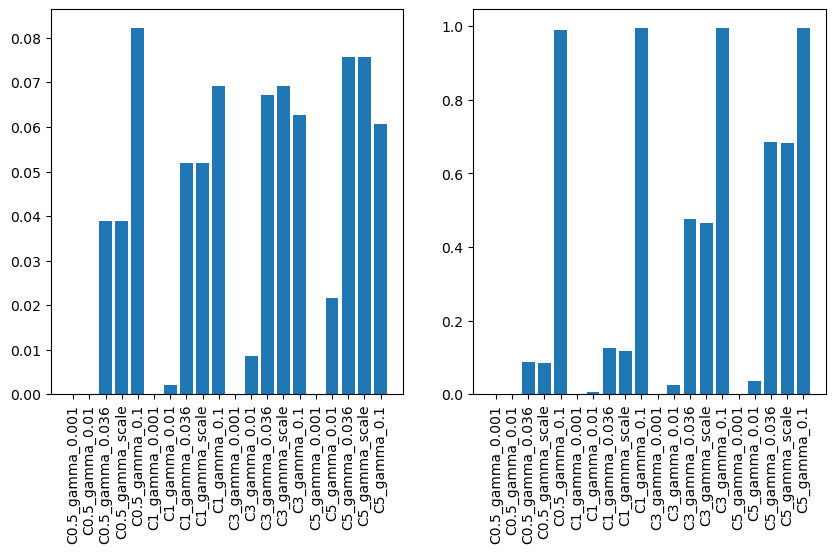

In [129]:
plt.figure(figsize = (10,5))

labels = ['C'+str(x['estimator__C']) + '_gamma_' + str(x['estimator__gamma']) for x in grid_search.cv_results_['params']]
plt.bar(labels, grid_search.cv_results_['mean_test_score'])
ax1 = plt.subplot(121)
plt.bar(labels,grid_search.cv_results_['mean_test_score'])
plt.xticks(rotation = 90);
ax1 = plt.subplot(122)
plt.bar(labels,grid_search.cv_results_['mean_train_score'])
plt.xticks(rotation = 90);


<b> I set gamma = 0.036 for one of the settings because gamma = 'scale' appeared to be an optimum for SVC with an rbf kernel.  As expected gamma = 0.036 and gamma = 'scale' were equivalent.


In [130]:
# Now let's switch gears to look at KNN
params={ 
        'estimator__n_neighbors': list(range(1,11)),
}

clf = MultiOutputClassifier(KNeighborsClassifier())

grid = GridSearchCV(clf, params, cv = 3, scoring = jaccard_cutoff, return_train_score = True, verbose = 2.1)
grid_search = grid.fit(gasmat_pca, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END estimator__n_neighbors=1;, score=(train=1.000, test=0.045) total time=  53.0s
[CV 2/3] END estimator__n_neighbors=1;, score=(train=1.000, test=0.045) total time=  52.8s
[CV 3/3] END estimator__n_neighbors=1;, score=(train=1.000, test=0.045) total time=  52.8s
[CV 1/3] END estimator__n_neighbors=2;, score=(train=0.143, test=0.032) total time=  53.2s
[CV 2/3] END estimator__n_neighbors=2;, score=(train=0.123, test=0.026) total time=  53.2s
[CV 3/3] END estimator__n_neighbors=2;, score=(train=0.149, test=0.039) total time=  53.4s
[CV 1/3] END estimator__n_neighbors=3;, score=(train=0.169, test=0.052) total time=  53.5s
[CV 2/3] END estimator__n_neighbors=3;, score=(train=0.156, test=0.045) total time=  55.4s
[CV 3/3] END estimator__n_neighbors=3;, score=(train=0.136, test=0.052) total time=  54.1s
[CV 1/3] END estimator__n_neighbors=4;, score=(train=0.071, test=0.032) total time=  53.5s
[CV 2/3] END estimator__n_nei

In [131]:
grid_search.cv_results_

{'mean_fit_time': array([0.27007651, 0.27868636, 0.25967677, 0.2659359 , 0.27096828,
        0.27548925, 0.29361582, 0.26667706, 0.26943286, 0.27607981]),
 'std_fit_time': array([0.00041881, 0.00528004, 0.00719125, 0.00418748, 0.00081064,
        0.00752245, 0.04569792, 0.00987893, 0.00328868, 0.00463105]),
 'mean_score_time': array([52.66941277, 53.09940783, 54.14488681, 53.38093019, 54.23759079,
        53.66270375, 53.66062363, 53.711284  , 53.72315629, 54.08490896]),
 'std_score_time': array([0.08420248, 0.05518904, 0.78829599, 0.17355467, 0.82164063,
        0.04514109, 0.0461674 , 0.05152781, 0.08030183, 0.36850361]),
 'param_estimator__n_neighbors': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'estimator__n_neighbors': 1},
  {'estimator__n_neighbors': 2},
  {'estimator__n_neighbors': 3},
  {'estimato

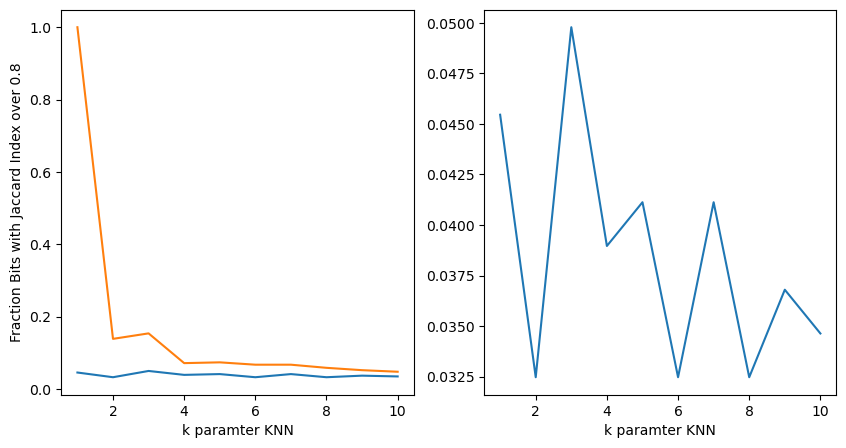

In [132]:
plt.figure(figsize = (10,5))

ax1 = plt.subplot(121)
plt.plot(list(range(1,11)),grid_search.cv_results_['mean_test_score'])
plt.plot(list(range(1,11)),grid_search.cv_results_['mean_train_score'])
ax1.set_xlabel('k paramter KNN')
ax1.set_ylabel('Fraction Bits with Jaccard Index over 0.8')
ax2 = plt.subplot(122)
plt.plot(list(range(1,11)),grid_search.cv_results_['mean_test_score'])
ax2.set_xlabel('k paramter KNN')

plt.show()


<b> Next I want to take the best fits for KNN and SVC and apply them with cross validation to see which features (bits)
<b> I can retain.  Hopefully KNN and SVC work well for different features


In [133]:
# Alright going to fit with optimized SVC model
# Going to fit this with the MultiOutputClassifier wrapper around the SVC classifier
# Going to start out without adding PCA in the pipeline and consider adding back later

def score_func(y,y_pred):
    f1_score = np.zeros(y_pred.shape[1])
    acc_score = np.zeros(y_pred.shape[1])
    prec_score = np.zeros(y_pred.shape[1])
    rec_score = np.zeros(y_pred.shape[1])
    truepos_sum = np.zeros(y_pred.shape[1])
    jaccard_score = np.zeros(y_pred.shape[1])
    
    for i in range(y_pred.shape[1]):
        acc_score[i] = metrics.accuracy_score(y[:,i], y_pred[:,i])
        rec_score[i] = metrics.recall_score(y[:,i], y_pred[:,i], zero_division = 1)
        truepos_sum[i] = y[:,i].sum()
        prec_score[i] = metrics.precision_score(y[:,i], y_pred[:,i], zero_division = 0)
        f1_score[i] = metrics.f1_score(y[:,i], y_pred[:,i], zero_division = 0)
        predpos_sum = y_pred[:,i].sum()
        jaccard_score[i] = metrics.jaccard_score(y[:,i], y_pred[:,i], zero_division = 0)
        if truepos_sum[i] == 0:  # If I catch any 0 True positives I want to set precision and f1_score to 1 if no bits were predicted
            if predpos_sum == 0:
                prec_score[i] = 1
                f1_score[i] = 1
                jaccard_score[i] = 1
                       
    return acc_score, prec_score, rec_score, f1_score, truepos_sum, jaccard_score

test_accuracy_SVCOpt = np.zeros((y_train.shape[1],5))
test_precision_SVCOpt = np.zeros((y_train.shape[1],5))
test_recall_SVCOpt = np.zeros((y_train.shape[1],5))
test_f1_SVCOpt = np.zeros((y_train.shape[1],5))
TP_SVCOpt_test = np.zeros((y_train.shape[1],5))
test_jaccard_SVCOpt = np.zeros((y_train.shape[1],5))

for i, (train_index, test_index) in enumerate(kf.split(gasmat_pca)):
    print('Working on Fold:',i,'Model Fitting.............',end='\r')
    clf = MultiOutputClassifier(svm.SVC(C = 3)) # Only change from opt of kernel, C, and Gamma was to C
    start = time.time()
    clf.fit(gasmat_pca[train_index,:],y_train[train_index,:])
    end = time.time()
    model_df.loc[i,'fit_time_SVCOpt'] = end - start
    
    print('Working on Fold:',i,'Predicting.............',end='\r')
    start = time.time()
    y_hat = clf.predict(gasmat_pca[test_index,:])
    end = time.time()
    model_df.loc[i,'predict_time_SVCOpt'] = end - start

    print('Working on Fold:',i,'Scoring.............',end='\r')
    start = time.time()
    test_accuracy_SVCOpt[:,i], test_precision_SVCOpt[:,i], test_recall_SVCOpt[:,i], test_f1_SVCOpt[:,i], TP_SVCOpt_test[:,i], test_jaccard_SVCOpt[:,i] = score_func(y_train[test_index,:],y_hat)
    end = time.time()
    model_df.loc[i,'score_time_SVCOpt'] = end - start
       
    
bit_df.loc[:,'test_accuracy_SVCOpt'] = np.mean(test_accuracy_SVCOpt, axis = 1)
bit_df.loc[:,'test_precision_SVCOpt'] = np.mean(test_precision_SVCOpt, axis = 1)
bit_df.loc[:,'test_recall_SVCOpt'] = np.mean(test_recall_SVCOpt, axis = 1)
bit_df.loc[:,'test_f1_SVCOpt'] = np.mean(test_f1_SVCOpt, axis = 1)
bit_df.loc[:,'TP_SVCOpt_test'] = np.sum(TP_SVCOpt_test == 0, axis = 1) #sum up 0 value true pos
bit_df.loc[:,'test_jaccard_SVCOpt'] = np.mean(test_jaccard_SVCOpt, axis = 1)

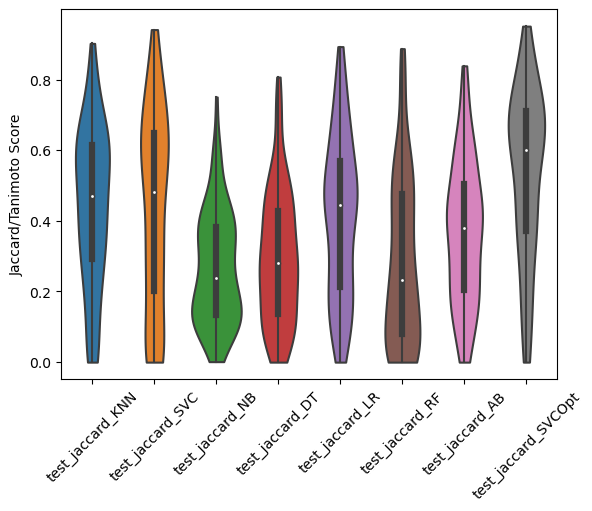

In [134]:
# Alright Let's take a look at these metrics and see how the optimum model compares to all of the vanilla models

sns.violinplot(data = bit_df.loc[:,bit_df.columns.str.contains('jaccard')], cut = 0);
plt.ylabel('Jaccard/Tanimoto Score');
plt.xticks(rotation = 45);

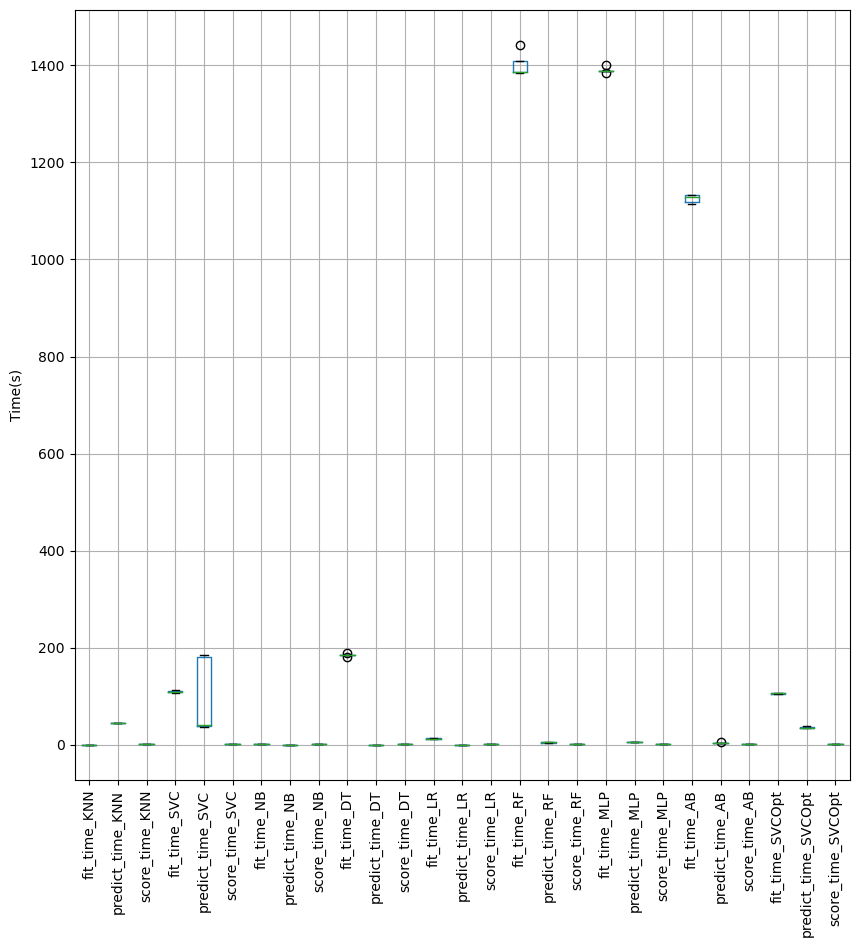

In [135]:
# Alright let's take a look at the times - most of the time is in predicting the KNN model
plt.figure(figsize = (10,10))
model_df.astype(int).boxplot()
plt.ylabel('Time(s)');
plt.xticks(rotation = 90);

In [136]:
bit_df.shape

(154, 54)

In [137]:
bit_df.head()

test_accuracy_KNN  test_precision_KNN  test_recall_KNN  test_f1_KNN  \
0           0.996054                 0.0         0.000000     0.000000   
1           0.997420                 0.0         0.000000     0.000000   
2           0.997117                 0.2         0.200000     0.200000   
3           0.997724                 0.2         0.040000     0.066667   
4           0.996054                 0.2         0.033333     0.057143   

   TP_KNN_test  test_jaccard_KNN  Num_Molecules  test_accuracy_SVC  \
0            0          0.000000             32           0.996054   
1            0          0.000000             18           0.997420   
2            1          0.200000             23           0.997269   
3            0          0.040000             19           0.997572   
4            0          0.033333             37           0.995902   

   test_precision_SVC  test_recall_SVC  ...  test_recall_AB  test_f1_AB  \
0                 0.0              0.0  ...        0.083333    0.123810   
1                 0.0              0.0  ...        0.000000    0.000000   
2                 0.2              0.2  ...        0.200000    0.000000   
3                 0.0              0.0  ...        0.100000    0.133333   
4                 0.0              0.0  ...        0.073333    0.116667   

   TP_AB_test  test_jaccard_AB  test_accuracy_SVCOpt  test_precision_SVCOpt  \
0           0         0.073333              0.996054                    0.0   
1           0         0.000000              0.997420                    0.0   
2           1         0.000000              0.997269                    0.2   
3           0         0.100000              0.997875                    0.4   
4           0         0.068571              0.996358                    0.6   

   test_recall_SVCOpt  test_f1_SVCOpt  TP_SVCOpt_test  test_jaccard_SVCOpt  
0            0.000000        0.000000               0             0.000000  
1            0.000000        0.000000               0             0.000000  
2            0.200000        0.200000               1             0.200000  
3            0.140000        0.200000               0             0.140000  
4            0.106667        0.180952               0             0.106667  

[5 rows x 54 columns]

In [138]:
test_accuracy_KNNOpt = np.zeros((y_train.shape[1],5))
test_precision_KNNOpt = np.zeros((y_train.shape[1],5))
test_recall_KNNOpt = np.zeros((y_train.shape[1],5))
test_f1_KNNOpt = np.zeros((y_train.shape[1],5))
TP_KNNOpt_test = np.zeros((y_train.shape[1],5))
test_jaccard_KNNOpt = np.zeros((y_train.shape[1],5))

for i, (train_index, test_index) in enumerate(kf.split(gasmat_pca)):
    print('Working on Fold:',i,'Model Fitting.............',end='\r')
    clf = MultiOutputClassifier(KNeighborsClassifier(n_neighbors = 3)) # Optimum of k = 3
    start = time.time()
    clf.fit(gasmat_pca[train_index,:],y_train[train_index,:])
    end = time.time()
    model_df.loc[i,'fit_time_KNNOpt'] = end - start
    
    print('Working on Fold:',i,'Predicting.............',end='\r')
    start = time.time()
    y_hat = clf.predict(gasmat_pca[test_index,:])
    end = time.time()
    model_df.loc[i,'predict_time_KNNOpt'] = end - start

    print('Working on Fold:',i,'Scoring.............',end='\r')
    start = time.time()
    test_accuracy_KNNOpt[:,i], test_precision_KNNOpt[:,i], test_recall_KNNOpt[:,i], test_f1_KNNOpt[:,i], TP_KNNOpt_test[:,i], test_jaccard_KNNOpt[:,i] = score_func(y_train[test_index,:],y_hat)
    end = time.time()
    model_df.loc[i,'score_time_KNNOpt'] = end - start
       
    
bit_df.loc[:,'test_accuracy_KNNOpt'] = np.mean(test_accuracy_KNNOpt, axis = 1)
bit_df.loc[:,'test_precision_KNNOpt'] = np.mean(test_precision_KNNOpt, axis = 1)
bit_df.loc[:,'test_recall_KNNOpt'] = np.mean(test_recall_KNNOpt, axis = 1)
bit_df.loc[:,'test_f1_KNNOpt'] = np.mean(test_f1_KNNOpt, axis = 1)
bit_df.loc[:,'TP_KNNOpt_test'] = np.sum(TP_KNNOpt_test == 0, axis = 1) #sum up 0 value true pos
bit_df.loc[:,'test_jaccard_KNNOpt'] = np.mean(test_jaccard_KNNOpt, axis = 1)

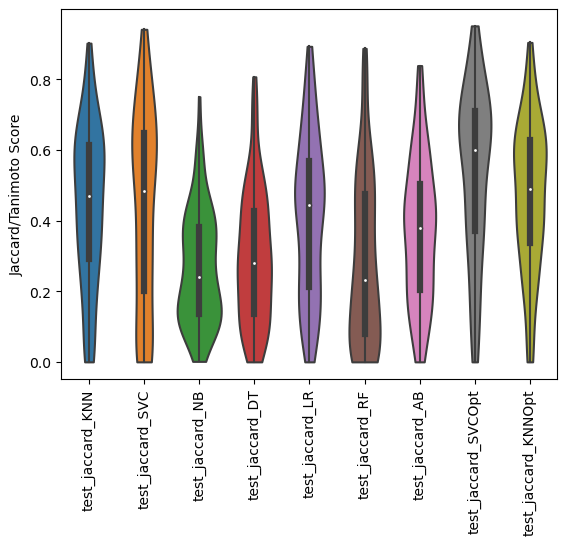

In [139]:
# Alright Let's take a look at these metrics and see how the optimum model compares to all of the vanilla models

sns.violinplot(data = bit_df.loc[:,bit_df.columns.str.contains('jaccard')], cut = 0);
plt.ylabel('Jaccard/Tanimoto Score');
plt.xticks(rotation = 90);

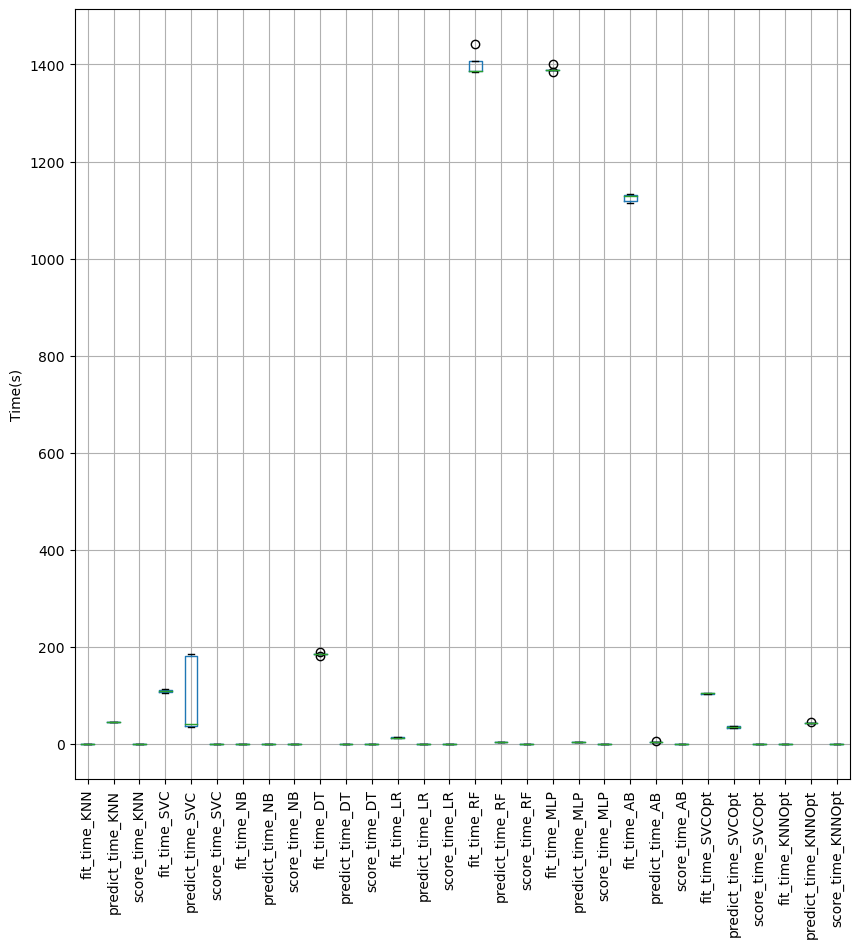

In [140]:
# Alright let's take a look at the times - most of the time is in predicting the KNN model
plt.figure(figsize = (10,10))
model_df.astype(int).boxplot()
plt.ylabel('Time(s)');
plt.xticks(rotation = 90);

(0.0, 1.0)

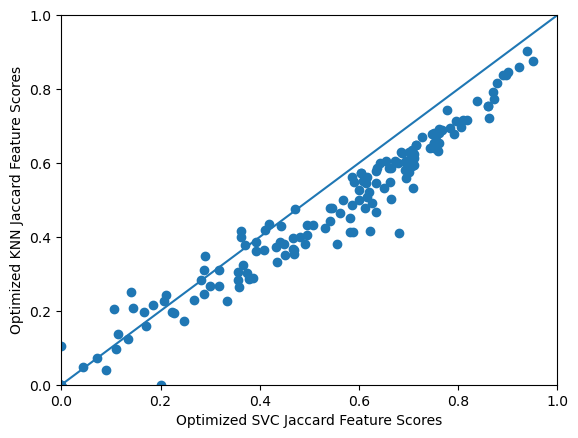

In [141]:
ax = plt.subplot(111)
plt.scatter(bit_df.test_jaccard_SVCOpt, bit_df.test_jaccard_KNNOpt)
plt.plot(np.arange(-0.1,1.1,0.1),np.arange(-0.1,1.1,0.1))
ax.set_xlabel('Optimized SVC Jaccard Feature Scores')
ax.set_ylabel('Optimized KNN Jaccard Feature Scores')
ax.set_ylim([0,1])
ax.set_xlim([0,1])

<b> From the above it's clear that SVC is optimal for all of the features with Jaccard indexes higher than 0.5.

In [142]:
results_dict = {'correct':[],'matches':[],'jacc_index':[], 'cutoff':[], 'j_select':[], 'numAP':[], 'numTP':[],'numMiss':[]}

for jind in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    print('Working on feature jaccard cutoff =',jind,'Fitting...................',end='\r')
    j_select = bit_df.test_jaccard_SVCOpt > jind
    SVCFinal = MultiOutputClassifier(svm.SVC(C = 3)) # Only change from opt of kernel, C, and Gamma was to C
    SVCFinal.fit(gasmat_pca, y_train[:,j_select])
    gasmat_PCA_test = PC.transform(X_test)
    y_hat = SVCFinal.predict(gasmat_PCA_test)
    correct = []
    matches = []
    jacc_index = []
    numAP = []
    numTP = []
    numMiss = []
    
    for molecule in range(y_hat.shape[0]):
            print('Working on feature jaccard cutoff =',jind,'Mol:',molecule,'...............',end='\r')
            # First use repeat with order = Fortran style to make a 1D array of enough values to fill a matrix
            # of size y_train.  Then reshape the 1D array to the size of y_train.  Find the intersection between the
            # new matrix of all one predicted molecule bit string and the actual matrix of molecule bit strings (y_train).
            # Lastly, sum along the rows in order to sum up the union for each molecule compared with this predicted
            # bit string.
            intersection = (np.reshape(np.repeat(y_hat[molecule,:],
                                                 y_test.shape[0]),
                                                 y_test[:,j_select].shape,
                                                 order = 'F').astype(int) & y_test[:,j_select].astype(int)).sum(axis = 1)
            # Perform the same operation as above, but do it with the or function to get the union of the two matrices
            union = (np.reshape(np.repeat(y_hat[molecule,:],
                                          y_test.shape[0]),
                                          y_test[:,j_select].shape,
                                          order = 'F').astype(int) | y_test[:,j_select].astype(int)).sum(axis = 1)
            # Check to see if the maximum of intersection/union is the correct molecule index
            # if yes store 1 if no store 0 in jac_comp.  Regardless, store the jaccard index in jac_value
            # I was using np.argmax() here - but had to switch because it only finds first max.
            # NOTE THIS MEANS WITH THE FEATURES I HAVE NOW THE MOLECULES ARE NOT UNIQUE
            maxvalind = np.argwhere(intersection/union == np.amax(intersection/union))
            matches.append(len(maxvalind))
            jacc_index.append((intersection[molecule]/union[molecule]).max())
            numAP.append(y_test[molecule,j_select].sum())
            numTP.append(intersection[molecule])
            numMiss.append(union[molecule] - intersection[molecule])
            if molecule in maxvalind:
                correct.append(1)
            else:
                correct.append(0)
            
    results_dict['correct'].append(correct)
    results_dict['matches'].append(matches)
    results_dict['jacc_index'].append(jacc_index)
    results_dict['cutoff'].append(jind)
    results_dict['j_select'].append(j_select)
    results_dict['numAP'].append(numAP)
    results_dict['numTP'].append(numTP)
    results_dict['numMiss'].append(numMiss)
            

C:\Users\kevin\AppData\Local\Temp\ipykernel_15940\2092573966.py:37: RuntimeWarning: invalid value encountered in true_divide
  maxvalind = np.argwhere(intersection/union == np.amax(intersection/union))
C:\Users\kevin\AppData\Local\Temp\ipykernel_15940\2092573966.py:39: RuntimeWarning: invalid value encountered in int_scalars
  jacc_index.append((intersection[molecule]/union[molecule]).max())


C:\Users\kevin\AppData\Local\Temp\ipykernel_15940\2092573966.py:37: RuntimeWarning: invalid value encountered in true_divide
  maxvalind = np.argwhere(intersection/union == np.amax(intersection/union))
C:\Users\kevin\AppData\Local\Temp\ipykernel_15940\2092573966.py:39: RuntimeWarning: invalid value encountered in int_scalars
  jacc_index.append((intersection[molecule]/union[molecule]).max())


C:\Users\kevin\AppData\Local\Temp\ipykernel_15940\2092573966.py:37: RuntimeWarning: invalid value encountered in true_divide
  maxvalind = np.argwhere(intersection/union == np.amax(intersection/union))
C:\Users\kevin\AppData\Local\Temp\ipykernel_15940\2092573966.py:39: RuntimeWarning: invalid value encountered in int_scalars
  jacc_index.append((intersection[molecule]/union[molecule]).max())


In [143]:
test_cas = df_gas.loc[indices_test,:].index.tolist()

for idx,cutoff in enumerate(results_dict['cutoff']):
    if idx == 0:
        index = list(zip(np.repeat(cutoff,test_cas[0]),test_cas))
    else:
        index = index + (list(zip(np.repeat(cutoff,test_cas[0]),test_cas)))
        
final_test_df = pd.DataFrame(columns = ['correct', 'matches','jacc_index','numAP', 'numTP', 'numMiss'], index = index)

for idx,cutoff in enumerate(results_dict['cutoff']):
    index = list(zip(np.repeat(cutoff,test_cas[0]),test_cas))
    for col in final_test_df.columns:
        final_test_df.loc[index,col] = results_dict[col][idx]
        
index = pd.MultiIndex.from_tuples(final_test_df.index)
final_test_df.index = index


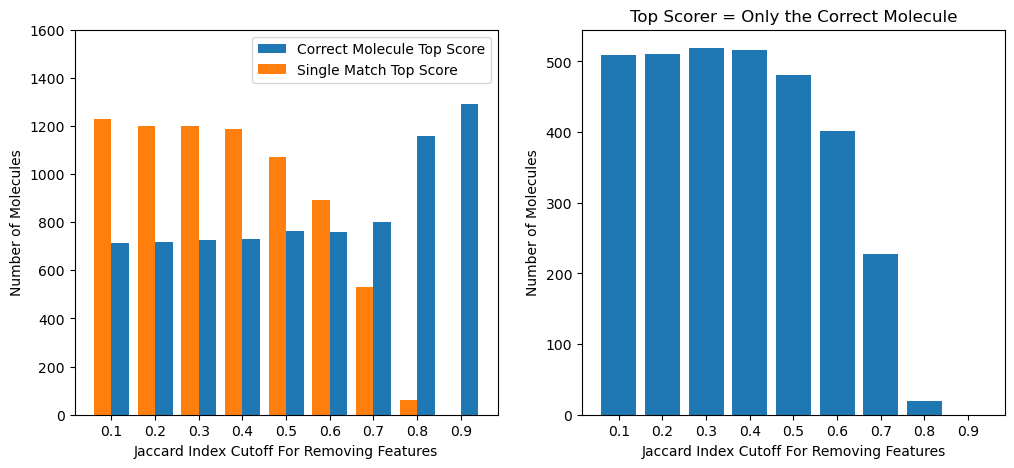

In [144]:
x = [str(cutoff) for cutoff in results_dict['cutoff']]
y = [(final_test_df.loc[(cutoff,slice(None)),:].correct == 1).sum() for cutoff in results_dict['cutoff']]
y2 = [(final_test_df.loc[(cutoff,slice(None)),:].matches == 1).sum() for cutoff in results_dict['cutoff']]
y3 = [((final_test_df.loc[(cutoff,slice(None)),:].matches == 1) & (final_test_df.loc[(cutoff,slice(None)),:].correct == 1)).sum() for cutoff in results_dict['cutoff']]

plt.figure(figsize = (12,5))
ax = plt.subplot(121)

plt.bar(x,y, align = 'edge', width = 0.4)
plt.bar(x,y2, align = 'edge', width = -0.4)
ax.set_xlabel('Jaccard Index Cutoff For Removing Features')
ax.set_ylabel('Number of Molecules')
ax.legend(['Correct Molecule Top Score', 'Single Match Top Score'])
ax.set_ylim([0,1600])

ax = plt.subplot(122)
plt.bar(x,y3, align = 'center', width = 0.8)
ax.set_xlabel('Jaccard Index Cutoff For Removing Features')
ax.set_ylabel('Number of Molecules')
ax.set_title('Top Scorer = Only the Correct Molecule')
plt.show()


<BarContainer object of 9 artists>

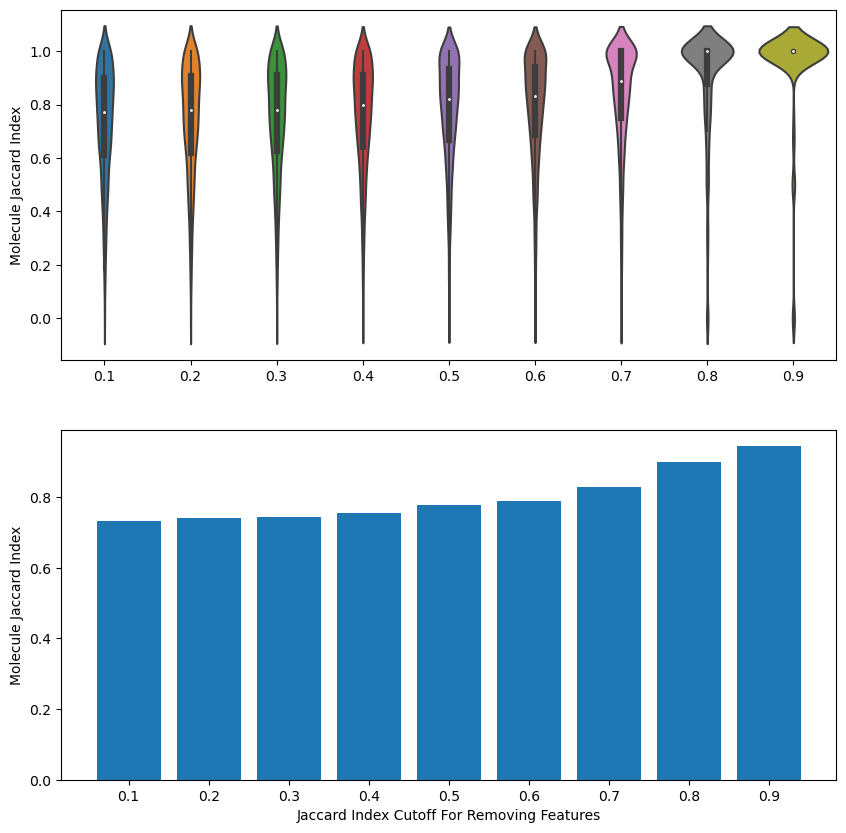

In [145]:
plt.figure(figsize = (10,10))
final_test_df_JI = pd.DataFrame(columns = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
tst = [final_test_df.loc[(col,slice(None)),:].jacc_index.values for col in final_test_df_JI.columns]
ax = plt.subplot(211)
final_test_df_JI = pd.DataFrame(data = tst, index = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
final_test_df_JI = final_test_df_JI.transpose()
sns.violinplot(data = final_test_df_JI)
ax.set_ylabel('Molecule Jaccard Index')
ax = plt.subplot(212)
y4 = final_test_df_JI.mean()
ax.set_xlabel('Jaccard Index Cutoff For Removing Features')
ax.set_ylabel('Molecule Jaccard Index')
plt.bar(x,y4)


<b> Above suprisingly the most unique and correct molecule identifications are given by setting the cutoff for keeping features (bits) in the MACCS keys at a Jaccard index of 0.3.  In light of this information I'll set the Jaccard Index cutoff to 0.3 and generate the final model.  Also of interest is the jaccard index for each molecule stops decreasing once the feature jaccard index drops below ~0.4.  I didn't see this in the simulation of potential results, but I also didn't simulate down to lower bit jaccard index.

Text(0.5, 1.0, 'Jaccard Index Feature Cutoff = 0.7')

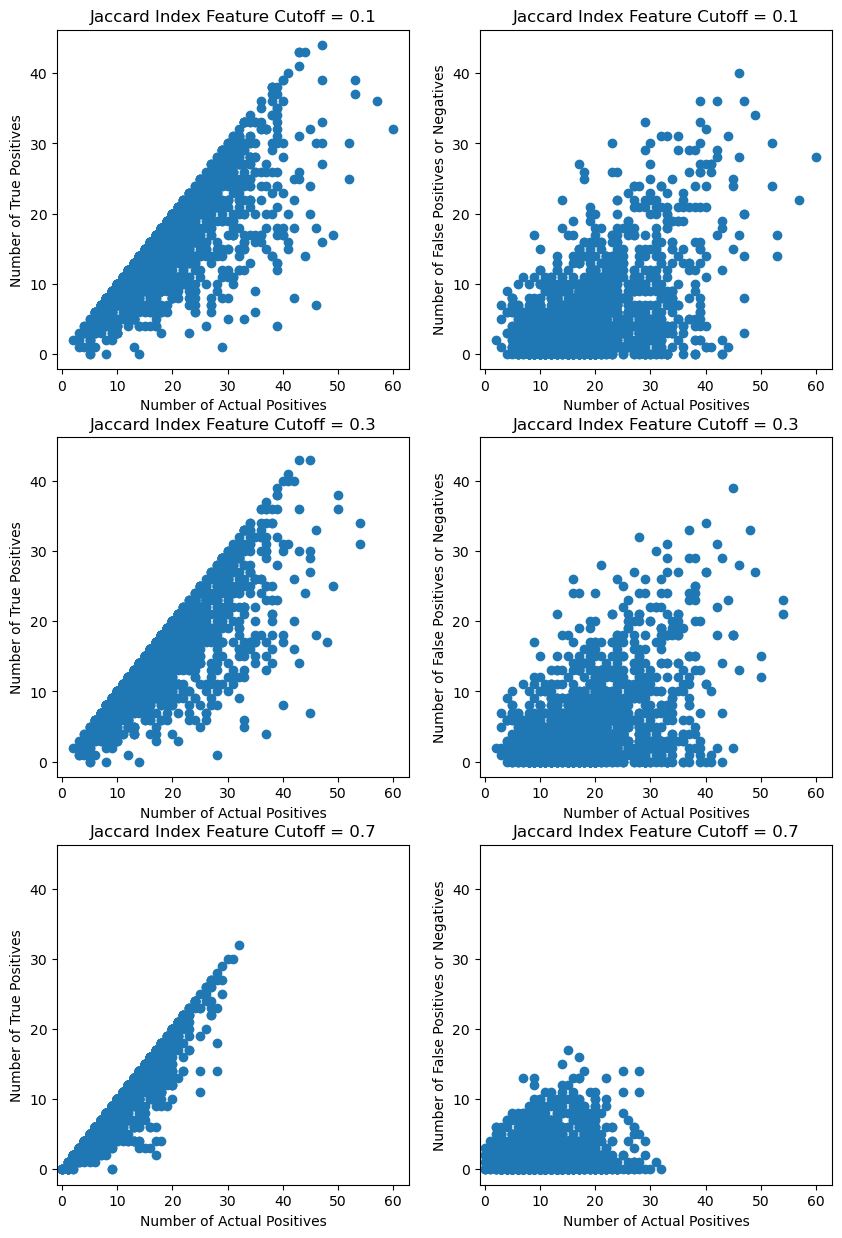

In [146]:
plt.figure(figsize = (10,15))
cutoff = 0.1
ax = plt.subplot(321)
plt.scatter(final_test_df.loc[(cutoff,slice(None)),:].numAP, final_test_df.loc[(cutoff,slice(None)),:].numTP)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_ylabel('Number of True Positives')
ax.set_xlabel('Number of Actual Positives')
ax.set_title('Jaccard Index Feature Cutoff = '+str(cutoff))
ax = plt.subplot(322)
plt.scatter(final_test_df.loc[(cutoff,slice(None)),:].numAP, final_test_df.loc[(cutoff,slice(None)),:].numMiss)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_ylabel('Number of False Positives or Negatives')
ax.set_xlabel('Number of Actual Positives')
ax.set_title('Jaccard Index Feature Cutoff = '+str(cutoff))
cutoff = 0.3
ax = plt.subplot(323)
plt.scatter(final_test_df.loc[(cutoff,slice(None)),:].numAP, final_test_df.loc[(cutoff,slice(None)),:].numTP)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_ylabel('Number of True Positives')
ax.set_xlabel('Number of Actual Positives')
ax.set_title('Jaccard Index Feature Cutoff = '+str(cutoff))
ax = plt.subplot(324)
plt.scatter(final_test_df.loc[(cutoff,slice(None)),:].numAP, final_test_df.loc[(cutoff,slice(None)),:].numMiss)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_ylabel('Number of False Positives or Negatives')
ax.set_xlabel('Number of Actual Positives')
ax.set_title('Jaccard Index Feature Cutoff = '+str(cutoff))
cutoff = 0.7
ax = plt.subplot(325)
plt.scatter(final_test_df.loc[(cutoff,slice(None)),:].numAP, final_test_df.loc[(cutoff,slice(None)),:].numTP)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_ylabel('Number of True Positives')
ax.set_xlabel('Number of Actual Positives')
ax.set_title('Jaccard Index Feature Cutoff = '+str(cutoff))
ax = plt.subplot(326)
plt.scatter(final_test_df.loc[(cutoff,slice(None)),:].numAP, final_test_df.loc[(cutoff,slice(None)),:].numMiss)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_ylabel('Number of False Positives or Negatives')
ax.set_xlabel('Number of Actual Positives')
ax.set_title('Jaccard Index Feature Cutoff = '+str(cutoff))


<b> In the plots above the impact on changing the filter are observed.  As you increase the cutoff you 
prune some of the false negatives and positives, but you lose actual positives through the feature
reduction process.
    

propanoic acid, 2-hydroxy-2-methyl-, ethyl ester alone was correctly identified!


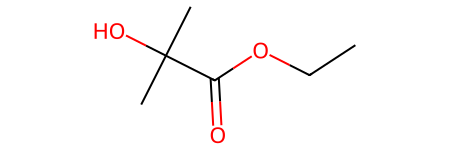

4h-1,3-oxazine, 5,6-dihydro-2,4,4,6-tetramethyl- alone was correctly identified!


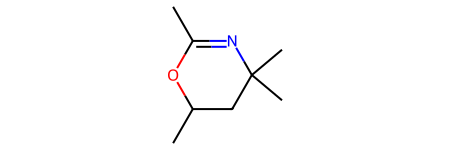

1h-benzotriazole, 5-methyl- alone was correctly identified!


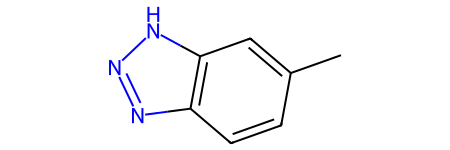

o-fluorothiophenol did not have the highest jaccard index it was in place: 42


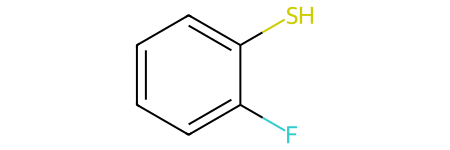

benzene, 1,2,4,5-tetrabromo- was one of the top scores.


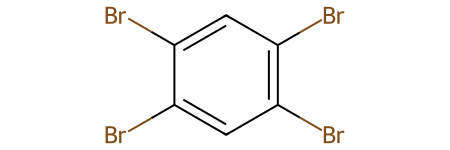

1(4h)-pyridineacetic acid, 3,5-dichloro-4-oxo- alone was correctly identified!


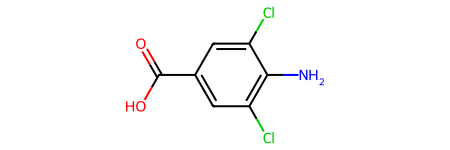

3-methylbenzyl alcohol alone was correctly identified!


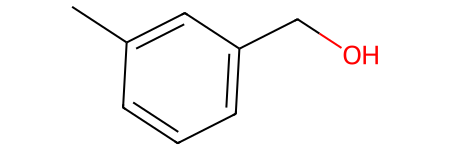

pentanoic acid, propyl ester did not have the highest jaccard index it was in place: 6


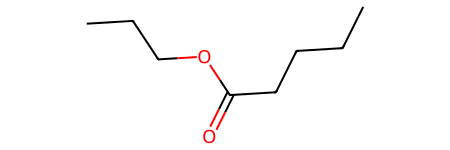

hexanoic acid, pentyl ester was one of the top scores.


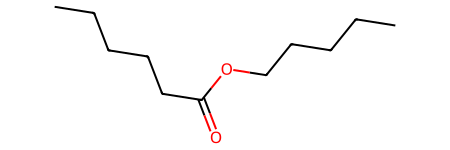

2,6-dimethoxybenzonitrile alone was correctly identified!


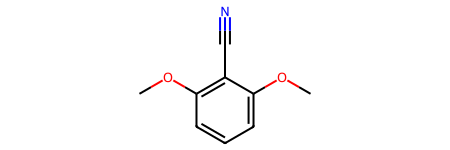

hexane, 1-bromo- alone was correctly identified!


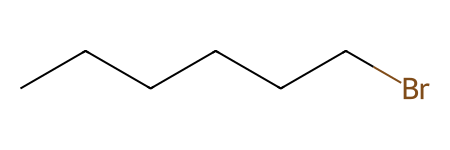

benzene, pentadecyl- did not have the highest jaccard index it was in place: 3


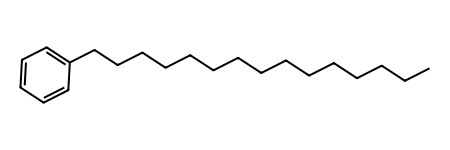

1-methylpentyl cyclopropane was one of the top scores.


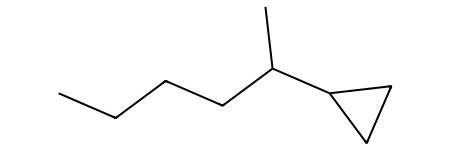

4-tert-butyl-benzophenone alone was correctly identified!


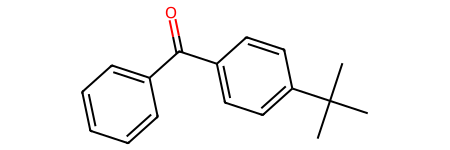

In [153]:
# Setting up the final model fit for iteration 0 of this project

j_select = bit_df.test_jaccard_SVCOpt > 0.3
SVCFinal = MultiOutputClassifier(svm.SVC(C = 3)) # Only change from opt of kernel, C, and Gamma was to C
SVCFinal.fit(gasmat_pca, y_train[:,j_select])
gasmat_PCA_test = PC.transform(X_test)
y_hat = SVCFinal.predict(gasmat_PCA_test)
final_results_dict = {'name':[],'mol':[],'correct_unique':[],'correct':[], 'place':[], 'jacc_index':[]}

for molecule in range(y_hat.shape[0]):
    # First use repeat with order = Fortran style to make a 1D array of enough values to fill a matrix
    # of size y_train.  Then reshape the 1D array to the size of y_train.  Find the intersection between the
    # new matrix of all one predicted molecule bit string and the actual matrix of molecule bit strings (y_train).
    # Lastly, sum along the rows in order to sum up the union for each molecule compared with this predicted
    # bit string.
    intersection = (np.reshape(np.repeat(y_hat[molecule,:],
                    y_test.shape[0]),
                    y_test[:,j_select].shape,
                    order = 'F').astype(int) & y_test[:,j_select].astype(int)).sum(axis = 1)
    # Perform the same operation as above, but do it with the or function to get the union of the two matrices
    union = (np.reshape(np.repeat(y_hat[molecule,:],
              y_test.shape[0]),
              y_test[:,j_select].shape,
              order = 'F').astype(int) | y_test[:,j_select].astype(int)).sum(axis = 1)
    # Check to see if the maximum of intersection/union is the correct molecule index
    # if yes store 1 if no store 0 in jac_comp.  Regardless, store the jaccard index in jac_value
    # I was using np.argmax() here - but had to switch because it only finds first max.
    # NOTE THIS MEANS WITH THE FEATURES I HAVE NOW THE MOLECULES ARE NOT UNIQUE
    jacc_index = intersection/union
    maxvalind = np.argwhere(jacc_index == np.amax(jacc_index))
    final_results_dict['name'].append(df_gas.loc[indices_test,:].name[molecule])
    final_results_dict['mol'].append(df_gas.loc[indices_test,:].mols[molecule])
    final_results_dict['jacc_index'].append(jacc_index[molecule])
    if molecule in maxvalind:
        if len(maxvalind == 1):
            if molecule < 11: # Just print the first 10
                print(df_gas.loc[indices_test,:].name[molecule], 'alone was correctly identified!')
                display(df_gas.loc[indices_test,:].mols[molecule])
            final_results_dict['correct_unique'].append(1)
            final_results_dict['correct'].append(1)
            final_results_dict['place'].append(1)
        else:
            if molecule < 11: # Just print the first 10
                print(df_gas.loc[indices_test,:].name[molecule], 'was correctly identified along others.')
            final_results_dict['correct_unique'].append(0)
            final_results_dict['correct'].append(1)
            final_results_dict['place'].append(1)
            if molecule < 11: # Just print the first 10
                for ind in maxvalind:
                    print(df_gas.loc[indices_test,:].name[ind])
                    display(df_gas.loc[indices_test,:].mols[ind])
        
    else:
        place = jacc_index.shape[0] - np.where(jacc_index.argsort() == molecule)[0][0]
        if molecule < 11: # Just print the first 10
            print(df_gas.loc[indices_test,:].name[molecule], 'did not have the highest jaccard index it was in place:',place)
            display(df_gas.loc[indices_test,:].mols[molecule])
            print(df_gas.loc[indices_test,:].name[maxvalind[0][0]], 'was one of the top scores.')
            display(df_gas.loc[indices_test,:].mols[maxvalind[0][0]])
        final_results_dict['correct_unique'].append(0)
        final_results_dict['correct'].append(0)
        final_results_dict['place'].append(place)

In [151]:
final_results_df = pd.DataFrame(final_results_dict)
final_results_df.head()


name  \
0  propanoic acid, 2-hydroxy-2-methyl-, ethyl ester   
1  4h-1,3-oxazine, 5,6-dihydro-2,4,4,6-tetramethyl-   
2                       1h-benzotriazole, 5-methyl-   
3                                o-fluorothiophenol   
4    1(4h)-pyridineacetic acid, 3,5-dichloro-4-oxo-   

                                                 mol  correct_unique  correct  \
0  <rdkit.Chem.rdchem.Mol object at 0x00000281A3E...               1        1   
1  <rdkit.Chem.rdchem.Mol object at 0x0000028187E...               1        1   
2  <rdkit.Chem.rdchem.Mol object at 0x00000281877...               1        1   
3  <rdkit.Chem.rdchem.Mol object at 0x000002818AD...               0        0   
4  <rdkit.Chem.rdchem.Mol object at 0x0000028187E...               1        1   

   place  jacc_index  
0      1    0.681818  
1      1    0.633333  
2      1    0.833333  
3     42    0.666667  
4      1    0.869565

Overall after completion of modeling the following percentage of molecules were correctly identified: 44.05%
100% of correctly identified molecules were uniquely identified. 
This percentage of molecules were in the top 10 (out of 1648): 76.03%
This percentage of molecules were in the top 50 (out of 1648): 89.02%


Text(0, 0.5, 'Frequency')

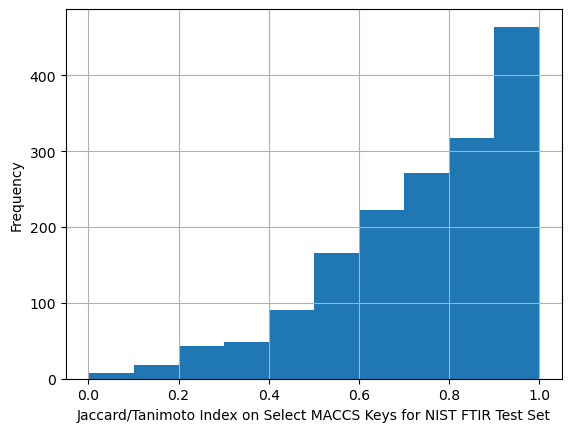

In [152]:
Top = (final_results_df.place == 1).sum()/final_results_df.place.shape[0]
Top10 = (final_results_df.place <= 10).sum()/final_results_df.place.shape[0]
Top50 = (final_results_df.place <= 50).sum()/final_results_df.place.shape[0]

print('Overall after completion of modeling the following percentage of molecules were correctly identified: {0:.2f}%'.format(Top*100))
print('{0:0.0f}% of correctly identified molecules were uniquely identified. '.format(final_results_df.correct_unique.sum()/final_results_df.correct_unique.sum()*100))
print('This percentage of molecules were in the top 10 (out of {1:d}): {0:.2f}%'.format(Top10*100,final_results_df.shape[0]))
print('This percentage of molecules were in the top 50 (out of {1:d}): {0:.2f}%'.format(Top50*100,final_results_df.shape[0]))

ax = plt.subplot(111)
final_results_df.jacc_index.hist()
ax.set_xlabel('Jaccard/Tanimoto Index on Select MACCS Keys for NIST FTIR Test Set')
ax.set_ylabel('Frequency')


# Conclusions and Future Directions

A unique correct match was obtained for 44% of the tested molecules, and a match in the top 10 within the test set of 1648 molecules was obtained for 76% of molecules in the test set.  The approach summarized briefly here was to obtain
    
    1) Obtain FTIR spectra, InChI, names, cas, and various other meta data from NIST
    2) Clean the data to get spectra in the same state (gas), y-units (transmittince), and x-units (wavenumber)
    3) Genearte MACCS keys from the InChI for each molecule with RDKit (166 bits - some removed in cleaning)
    4) Normalize the the transmittance spectra with Min Max normalization and reduce dimensionality with PCA (sklearn)
    5) Initial modeling with K-Nearest Neighbors, Suppor Vector Classifier, Logisitic Regression, Decision Tree, Random Forest, Adaboost, and Naive-Bayes scored with Jaccard/Tanimoto Index
    6) Modeled expected molecular Jaccard Index expected from obtaining particular Jaccard Index Values for MACCS Keys bits
    7) Optimized the two most promising models (KNN and SVC) with a scoring metric of getting as many as possible bit Jaccard index values above 0.8 as possible.
    8) Chose SVC to move forward (optimized C value of 3) --> Tested different Jaccard value index cutoffs for removing MACCS keys bits from the analysis (tested this on the final test set).
    9) Selected a cutoff of 0.3 based on the trade-off between obtaining a higher Jaccard Index and maintaining bits to keep molecules unique from one another.
    10) Generated the final SVC model.
    
Going back through on this post analysis, there is a clear mismatch between the obtained molecular jaccard index (greater thatn 50% above 0.5) and the cutoff for the bits (Jaccard Index of 0.3).  If you look back at 6 where I modeled the expected molecular Jaccard index - I did not take into account the distribution of Jaccard index.  I simply modeled the Jaccard index as a monolithic value.  Perhaps the distribution of Jaccard index for the features would aid future modeling of expected molecular Jaccard index.  In fact,  some additional work in this area could aid in determining how useful adding more bits would be to this process.

In the future it would be interested to generate these fingerprints for a larger database of values (PubChem for instance) and see how well the fingerprints generated from these spectra allow for identification of a molecule fro PubChem.  My guess would be that the lower jaccard index matches would not fare well as the database size increases.

For the preprocessing of the data with PCA, I didn't put any time or analysis into evaluation or optimization of that step. Removing the processing step, using PLS, and peak fitting could all be tried in order to improve the capture of spectral features.

I selected the MACCS keys - but there are many fingerprints available for digitizing chemical structure.  I intially started with RDKit fingerprints, but it was not clear to me from the documentation that each bit would come from a unique feature.  So, I dropped the RDKit fingerprint in favor of MACCS keys.  However, perhaps other fingerprints could be used to generate several potential FTIR fragments to be used in this type analysis.  I think this area may lead to the most improvement in future analysis.

The best next step would likely be to expand the matching to a larger database and get a benchmark of where this approach stands right now before making additional improvements.  For now, I will be moving on to other projects for a while and hopefully come back at some point to visit this project at a later date.